In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision 
from torchvision import transforms as T
from torchvision.datasets import CIFAR10, SVHN
import torch.nn.functional as F
from torch import optim

import os
import sys
from numpy.random import choice as npc
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import wandb

from siamese_dataloader import CIFAR10_TrainPair, CIFAR10_ValPair #, CIFAR10_TestPair
from siamese_resnet import BasicBlock, Siamese_ResNet
from useful_fc import show_dist, show_dist_tr, show_auroc

### Prepare dataset

In [2]:
# load cifar10 dataset
transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),])
# CIFAR10 - train
cifar10_dataset = CIFAR10(root="./data", train=True, transform=transform, download = False)  
torch.manual_seed(2021)
cifar10_dataset_train, cifar10_dataset_val = torch.utils.data.random_split(cifar10_dataset, [40000, 10000])
# CIFAR10 - test
cifar10_dataset_test = CIFAR10(root="./data", train=False, transform=transform, download =False)
# SVHN
svhn_dataset = SVHN(root="./data", split = 'train', transform=transform, download = False) 
# TinyImageNet
tinyimagenet_dataset = torchvision.datasets.ImageFolder("./data/Imagenet_resize", transform=transform)
# LSUN
lsun_dataset = torchvision.datasets.ImageFolder("./data/LSUN_resize", transform=transform)

### Training

In [4]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=10):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distance, is_diff):
        loss = torch.mean((1-is_diff) * torch.pow(distance, 2) +                           #same class
               is_diff * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))       #different classes

        return loss

In [5]:
# size = # of pairs of images
# trainset = CIFAR10_TrainPair(cifar10_dataset_train, train_size = 50000, seen_classes = list(range(6)))
# valset = CIFAR10_ValPair(cifar10_dataset_val, val_size = 10000, seen_classes = list(range(6)), ood_classes = [6,7])
trainset = CIFAR10_TrainPair(cifar10_dataset_train, train_size = 40000, seen_classes = [4,5,6,7,8,9])
valset = CIFAR10_ValPair(cifar10_dataset_val, val_size = 10000, seen_classes = [4,5,6,7,8,9], ood_classes = [2,3])

In [6]:
train_dataloader = DataLoader(
            trainset,
            shuffle = True,
            batch_size=512,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )
val_dataloader = DataLoader(
            valset,
            shuffle = True,
            batch_size=512,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )

In [7]:
wandb.login()

wandb: Currently logged in as: zoey7407 (use `wandb login --relogin` to force relogin)


True

In [9]:
def train():
    wandb.finish() 
    
    wandb.init(name='Siamese without OE - best - rotation', 
               project='training-siamese',
               config={"model": 'resnet18',
                       "resnet_layers": [2,2,2,2],
                       "loss_margin": 17,
                       "learning_rate": 0.001,
                       "weight_decay": 0.0006,
                       "max_epoch": 1000, #10
                       "early_stop_patience": 20,
                       "early_stop_by_auroc": True,
                       "show_dist_every": 10,
                       "seed": 2021})

    model = Siamese_ResNet(BasicBlock, wandb.config.resnet_layers).cuda()
    #model.load_state_dict(torch.load("./stat_dict/siamese_without_oe_best.pth"))
    criterion = ContrastiveLoss(margin = wandb.config.loss_margin)
    optimizer = optim.Adam(model.parameters(),lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)


    num_epochs = wandb.config.max_epoch
    early_stop_counter = 0
    early_stop_patience = wandb.config.early_stop_patience
    early_stop = False
    best_val_loss = 9999
    best_val_auroc_ood = 0
    show_dist_every = wandb.config.show_dist_every

    torch.manual_seed(wandb.config.seed)
    wandb.watch(model)

    for epoch in range(0,num_epochs):
        #train
        model.train()
        train_loss = 0
        for i, tr_batch in enumerate(train_dataloader,0):
            tr_img1, tr_img2, tr_class_1, tr_class_2, tr_is_diff, tr_is_ood = tr_batch
            tr_img1, tr_img2 , tr_is_diff = tr_img1.cuda(), tr_img2.cuda() , tr_is_diff.cuda()
            optimizer.zero_grad()
            _,_, tr_dist = model(tr_img1,tr_img2)
            tr_loss = criterion(tr_dist,tr_is_diff)
            tr_loss.backward()
            optimizer.step()
            train_loss += tr_loss.item()   

        train_loss = train_loss/len(train_dataloader)   # mean epoch loss


        #validation
        model.eval()
        val_loss = 0
        val_is_diff_all = []
        val_is_ood_all = []
        val_dist_all = []
        for j, val_batch in enumerate(val_dataloader,0):
            val_img1, val_img2 , val_class_1, val_class_2, val_is_diff, val_is_ood = val_batch
            val_img1, val_img2 , val_is_diff = val_img1.cuda(), val_img2.cuda() , val_is_diff.cuda()
            _,_,val_dist = model(val_img1,val_img2)
            val_batch_loss = criterion(val_dist,val_is_diff)
            val_loss += val_batch_loss.item()
            val_is_diff_all += val_is_diff.cpu().detach().numpy().squeeze().tolist()
            val_is_ood_all += val_is_ood.cpu().detach().numpy().squeeze().tolist()
            val_dist_all += val_dist.cpu().detach().numpy().squeeze().tolist()

        val_loss = val_loss/len(val_dataloader)
        val_auroc_diff = show_auroc(val_is_diff_all, val_dist_all, display = False)
        val_auroc_ood = show_auroc(val_is_ood_all, val_dist_all, display = False)


        print("\nEpoch {}, Train loss {}, Val loss {}\nVal auroc diff {}, Val auroc ood {}"
                .format(epoch, train_loss, val_loss, val_auroc_diff, val_auroc_ood))

        # display the distance distribution in last training and validation batch
        if epoch % show_dist_every ==0:
            tr_mean_same_dist, tr_mean_diff_seen_dist, tr_mean_diff_ood_dist, val_mean_same_dist, val_mean_diff_seen_dist, val_mean_diff_ood_dist = show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood, plot = True) 
        else:
            tr_mean_same_dist, tr_mean_diff_seen_dist, tr_mean_diff_ood_dist, val_mean_same_dist, val_mean_diff_seen_dist, val_mean_diff_ood_dist = show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood, plot = False) 

        wandb.log({
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Val Loss": val_loss, 
            "Val auroc diff": val_auroc_diff, 
            "Val auroc ood": val_auroc_ood,
            "Train mean distance (same)": tr_mean_same_dist,
            "Train mean distance (diff_seen)": tr_mean_diff_seen_dist,
            "Train mean distance (diff_ood)": tr_mean_diff_ood_dist,
            "Val mean distance (same)": val_mean_same_dist,
            "Val mean distance (diff_seen)": val_mean_diff_seen_dist,
            "Val mean distance (diff_ood)": val_mean_diff_ood_dist
            })

        # early stop by loss
        if wandb.config.early_stop_by_auroc == False:
            if val_loss > best_val_loss:
                early_stop_counter += 1
                print(f'EarlyStopping counter: {early_stop_counter} out of {early_stop_patience}, best val loss: {best_val_loss}')
                if early_stop_counter >= early_stop_patience:
                    early_stop = True
            else:
                best_val_loss = val_loss
                early_stop_counter = 0            
        # early stop by validation ood auroc
        else:
            if val_auroc_ood < best_val_auroc_ood:
                early_stop_counter += 1
                print(f'EarlyStopping counter: {early_stop_counter} out of {early_stop_patience}, best val auroc ood: {best_val_auroc_ood}')
                if early_stop_counter >= early_stop_patience:
                    early_stop = True
            else:
                best_val_auroc_ood = val_auroc_ood
                torch.save(model.state_dict(), "./stat_dict/siamese_without_oe_best_rotation.pth")
                early_stop_counter = 0

        if early_stop:
            print("Early stopping")
            break

    wandb.finish()
    
    tr_mean_same_dist, tr_mean_diff_seen_dist, tr_mean_diff_ood_dist, val_mean_same_dist, val_mean_diff_seen_dist, val_mean_diff_ood_dist = show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood, plot = True) 
    show_dist(tr_dist, tr_is_diff, tr_is_ood, val_dist, val_is_diff, val_is_ood) 
    # auroc for val_is_diff
    show_auroc(val_is_diff.cpu().detach().numpy().squeeze(), val_dist.cpu().detach().numpy().squeeze())
    # auroc for val_is_ood
    show_auroc(val_is_ood.cpu().detach().numpy().squeeze(), val_dist.cpu().detach().numpy().squeeze())
    
    return model

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 58.687065360472374, Val loss 58.03145258050216
Val auroc diff 0.7477955170013985, Val auroc ood 0.5958500055269438
Distance distribution of last training batch:
mean_same = 6.5203423500061035, mean_diff_seen = 10.78363037109375, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.385418891906738, mean_diff_seen = 11.126672744750977, mean_diff_ood = 9.535073280334473


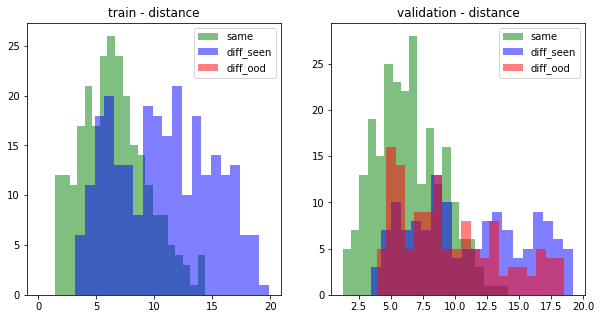


Epoch 1, Train loss 46.63312794006977, Val loss 53.72902719598068
Val auroc diff 0.7910215713900649, Val auroc ood 0.6233161079420324
Distance distribution of last training batch:
mean_same = 5.2826690673828125, mean_diff_seen = 11.383291244506836, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.909964561462402, mean_diff_seen = 11.456819534301758, mean_diff_ood = 9.658023834228516

Epoch 2, Train loss 38.85903041878927, Val loss 53.998191231175475
Val auroc diff 0.7961190415606088, Val auroc ood 0.629926740174601
Distance distribution of last training batch:
mean_same = 4.820839881896973, mean_diff_seen = 13.240713119506836, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.57603120803833, mean_diff_seen = 12.105978012084961, mean_diff_ood = 10.911066055297852

Epoch 3, Train loss 32.24730405119276, Val loss 51.1695835715846
Val auroc diff 0.8204440730486027, Val auroc ood 0.6531999330271914
Distance distribution of last

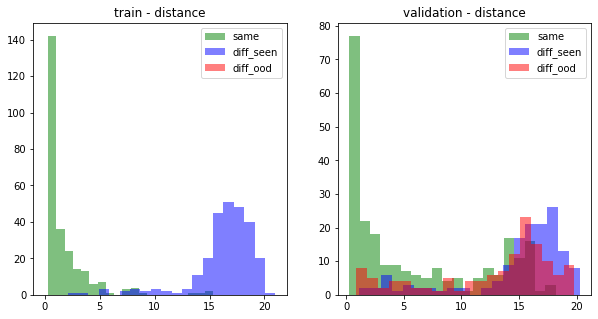

EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6620598845556092

Epoch 11, Train loss 7.946447741125048, Val loss 53.98225904765882
Val auroc diff 0.8349360573639776, Val auroc ood 0.6534202562747734
Distance distribution of last training batch:
mean_same = 1.8046897649765015, mean_diff_seen = 16.835491180419922, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.204191207885742, mean_diff_seen = 15.103034973144531, mean_diff_ood = 13.99514102935791
EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6620598845556092

Epoch 12, Train loss 6.828446924071951, Val loss 52.758439917313424
Val auroc diff 0.8426913732412227, Val auroc ood 0.6577684545192698
Distance distribution of last training batch:
mean_same = 1.5077751874923706, mean_diff_seen = 16.850540161132812, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.726167678833008, mean_diff_seen = 14.267830848693848, mean_diff_ood = 12.249741554260254
EarlySto

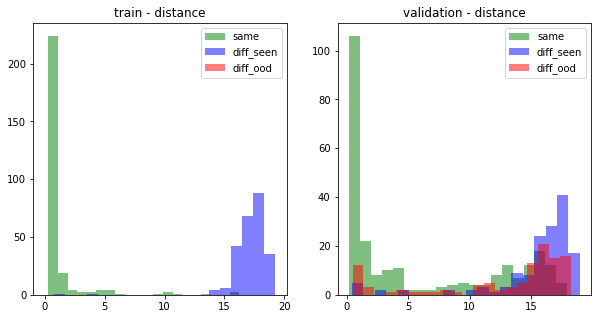


Epoch 21, Train loss 4.0216215664578465, Val loss 52.210430346037214
Val auroc diff 0.8482470583884142, Val auroc ood 0.6619794930191985
Distance distribution of last training batch:
mean_same = 1.153988242149353, mean_diff_seen = 16.881643295288086, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.768891334533691, mean_diff_seen = 15.513020515441895, mean_diff_ood = 13.256298065185547
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.665963813753563

Epoch 22, Train loss 3.412827687165172, Val loss 54.61560640837017
Val auroc diff 0.8409749380422138, Val auroc ood 0.661898376626298
Distance distribution of last training batch:
mean_same = 0.9743403196334839, mean_diff_seen = 16.97974395751953, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.437757968902588, mean_diff_seen = 14.990986824035645, mean_diff_ood = 13.897831916809082
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.665963813753563

Epoch 23, 

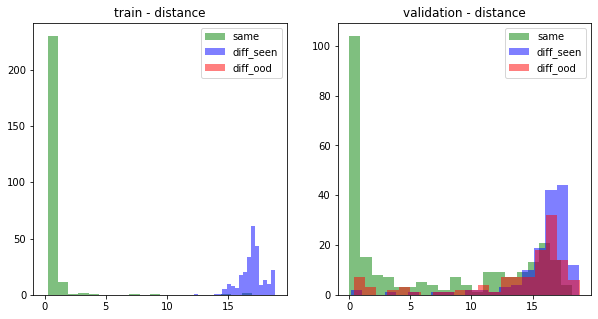

EarlyStopping counter: 10 out of 20, best val auroc ood: 0.665963813753563

Epoch 31, Train loss 2.175062768852588, Val loss 58.42467358237818
Val auroc diff 0.8361522057539319, Val auroc ood 0.657220982946772
Distance distribution of last training batch:
mean_same = 0.8582919836044312, mean_diff_seen = 17.408021926879883, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.125992298126221, mean_diff_seen = 15.432535171508789, mean_diff_ood = 14.179858207702637
EarlyStopping counter: 11 out of 20, best val auroc ood: 0.665963813753563

Epoch 32, Train loss 2.1376903708448114, Val loss 57.402834038985404
Val auroc diff 0.8333139181723667, Val auroc ood 0.656802211749538
Distance distribution of last training batch:
mean_same = 0.9179033637046814, mean_diff_seen = 17.434389114379883, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.464601516723633, mean_diff_seen = 15.190923690795898, mean_diff_ood = 12.955137252807617
EarlySto

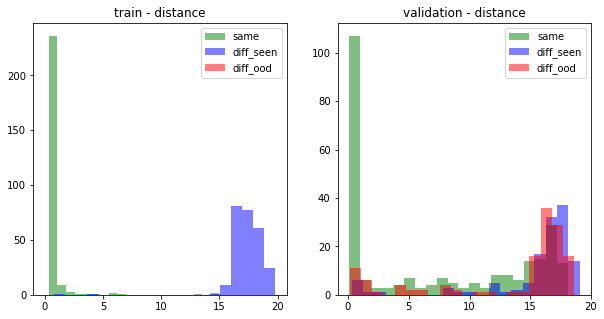

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6678442844943877

Epoch 41, Train loss 1.540935190989799, Val loss 60.08370509900545
Val auroc diff 0.8267655656033912, Val auroc ood 0.6534626559996389
Distance distribution of last training batch:
mean_same = 0.6772523522377014, mean_diff_seen = 17.508562088012695, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.057929992675781, mean_diff_seen = 15.893442153930664, mean_diff_ood = 13.304842948913574
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6678442844943877

Epoch 42, Train loss 1.5139284450368784, Val loss 57.89681645443565
Val auroc diff 0.837061689560521, Val auroc ood 0.6643364506873445
Distance distribution of last training batch:
mean_same = 0.6563470959663391, mean_diff_seen = 17.263444900512695, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.222804546356201, mean_diff_seen = 15.335762977600098, mean_diff_ood = 13.893111228942871
EarlySto

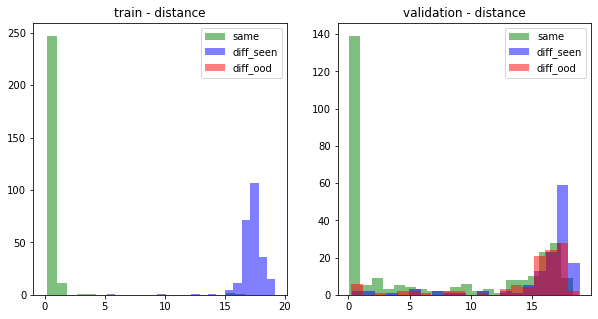

EarlyStopping counter: 7 out of 20, best val auroc ood: 0.6691829170564569

Epoch 51, Train loss 1.3859346521269416, Val loss 60.96425427888569
Val auroc diff 0.8282073518424495, Val auroc ood 0.6546107359229898
Distance distribution of last training batch:
mean_same = 0.8789569735527039, mean_diff_seen = 17.092897415161133, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.654738426208496, mean_diff_seen = 15.204841613769531, mean_diff_ood = 13.806429862976074
EarlyStopping counter: 8 out of 20, best val auroc ood: 0.6691829170564569

Epoch 52, Train loss 1.397593250286948, Val loss 57.03308687712017
Val auroc diff 0.8420897250973494, Val auroc ood 0.6675835181874161
Distance distribution of last training batch:
mean_same = 0.8671573996543884, mean_diff_seen = 17.192325592041016, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.888514518737793, mean_diff_seen = 15.585128784179688, mean_diff_ood = 13.95529842376709
EarlySto

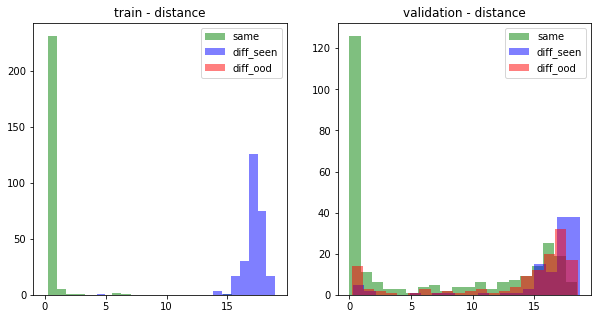

EarlyStopping counter: 17 out of 20, best val auroc ood: 0.6691829170564569

Epoch 61, Train loss 1.609583908135129, Val loss 57.77988694843493
Val auroc diff 0.8376610835976714, Val auroc ood 0.6556542725997045
Distance distribution of last training batch:
mean_same = 0.7497671246528625, mean_diff_seen = 17.4100284576416, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.424651145935059, mean_diff_seen = 14.817666053771973, mean_diff_ood = 13.133861541748047
EarlyStopping counter: 18 out of 20, best val auroc ood: 0.6691829170564569

Epoch 62, Train loss 1.4393440918209626, Val loss 57.02517077797338
Val auroc diff 0.841026444662924, Val auroc ood 0.6597095731897982
Distance distribution of last training batch:
mean_same = 0.7639918327331543, mean_diff_seen = 17.10854148864746, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.232112884521484, mean_diff_seen = 15.367302894592285, mean_diff_ood = 13.607080459594727
EarlyStop

Epoch,63
Train Loss,1.05879
Val Loss,61.97495
Val auroc diff,0.8186
Val auroc ood,0.65334
Train mean distance (same),0.59995
Train mean distance (diff_seen),17.38435
Train mean distance (diff_ood),NA
Val mean distance (same),7.15779
Val mean distance (diff_seen),15.74046
Val mean distance (diff_ood),13.21279


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▅▃▁▂▁▁▂▃▂▃▂▃▅▂▃▄▆▆▅▅▅▆▅▆▅▇▅▄▆▆▆▆▇▇▆▆▆▇▅█
Val auroc diff,▁▄▆▆▇█▇▇█▇██▇█▇▇▇▇█▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▆
Val auroc ood,▁▄▆▅▆▇▇▆▇▆▇▇▆▇▇▆▆▇▇█▇▇▇█▇▆██▇▇▇▇▇▆▇▇▇█▇▆
Train mean distance (same),█▇▆▅▅▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▂▄▅▆▇▇▇▇▇▇▇▇▇▇████▇████████████████████
Val mean distance (same),▅▃▂▃▄▄▂▄▂▄▃▃▅▂▅▃▆▁▃▅▅▄▅▅▃█▄▄▁▇▅▄▆▆▄█▄▇▅█
Val mean distance (diff_seen),▁▁▃▄▄▅▇▆▅▅▆▇▇▇▆▇▇▆█▇▆▆▇▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▆▇
Val mean distance (diff_ood),▁▁▂▃▅▅▅▇▄▅▅▆▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▇▆▇▆▇▆▇▇▇▆█▅▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.5999463200569153, mean_diff_seen = 17.384347915649414, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.157785415649414, mean_diff_seen = 15.740462303161621, mean_diff_ood = 13.212793350219727


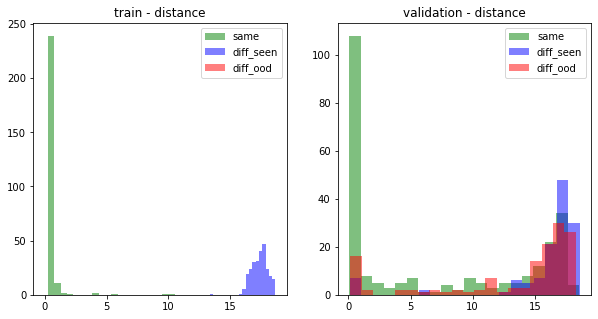

Distance distribution of last training batch:
mean_same = 0.5999463200569153, mean_diff_seen = 17.384347915649414, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.157785415649414, mean_diff_seen = 15.740462303161621, mean_diff_ood = 13.212793350219727


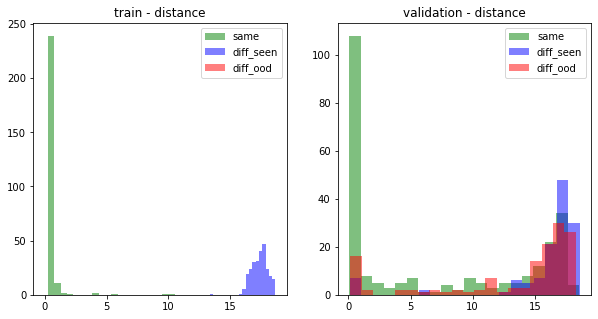

auroc: 0.7885839937697559


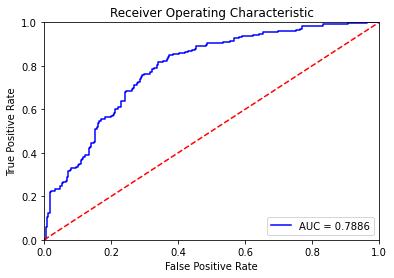

auroc: 0.603645181476846


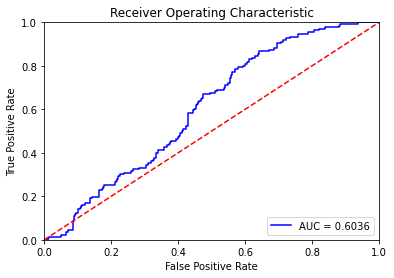

In [8]:
model = train()

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 1.3936308477957224, Val loss 59.1886823553788
Val auroc diff 0.8340723913334301, Val auroc ood 0.6587129443284175
Distance distribution of last training batch:
mean_same = 0.5380438566207886, mean_diff_seen = 17.26558494567871, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.7809224128723145, mean_diff_seen = 15.320642471313477, mean_diff_ood = 14.229836463928223


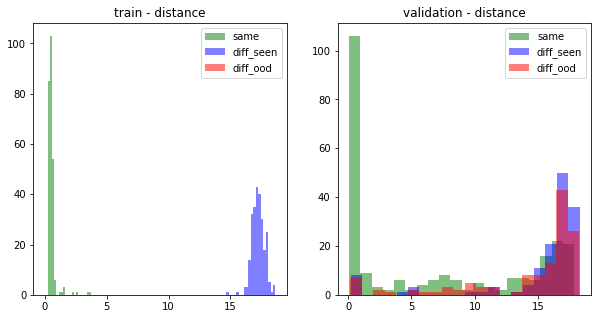


Epoch 1, Train loss 0.9610517289220672, Val loss 60.579946417557565
Val auroc diff 0.8337403359079448, Val auroc ood 0.6728116918736776
Distance distribution of last training batch:
mean_same = 0.6283602118492126, mean_diff_seen = 17.240528106689453, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.715450286865234, mean_diff_seen = 15.835225105285645, mean_diff_ood = 14.497139930725098

Epoch 2, Train loss 1.3903043356138407, Val loss 59.2569590116802
Val auroc diff 0.8311466807222447, Val auroc ood 0.6583952760043621
Distance distribution of last training batch:
mean_same = 0.7729458808898926, mean_diff_seen = 17.25063133239746, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.389036178588867, mean_diff_seen = 15.344783782958984, mean_diff_ood = 14.375804901123047
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6728116918736776

Epoch 3, Train loss 1.1545050528246104, Val loss 60.0326311211837
Val auroc diff 0.

Epoch,9
Train Loss,0.93539
Val Loss,61.59446
Val auroc diff,0.83454
Val auroc ood,0.65825
Train mean distance (same),0.49911
Train mean distance (diff_seen),17.70853
Train mean distance (diff_ood),NA
Val mean distance (same),6.51321
Val mean distance (diff_seen),16.77967
Val mean distance (diff_ood),14.39495


Epoch,▁▂▃▃▄▅▆▆▇█
Train Loss,█▁█▄▇▅▆▅▂▁
Val Loss,▁▅▁▄▁▃▂▇▃█
Val auroc diff,▆▆▅▄▇█▄▁▁▆
Val auroc ood,▃█▃▂▅▁▂▃▁▃
Train mean distance (same),▃▅█▅▄▇▁▁▅▂
Train mean distance (diff_seen),▁▁▁▃▃▂▂▄▁█
Val mean distance (same),▇▆▅▄█▁█▇▂▅
Val mean distance (diff_seen),▂▄▂▂▁▅▂▃▃█
Val mean distance (diff_ood),▅█▇▁▁▆▄▁▆▇
_runtime,▁▂▃▃▄▅▆▆▇█


Distance distribution of last training batch:
mean_same = 0.4991094768047333, mean_diff_seen = 17.70853042602539, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.513206481933594, mean_diff_seen = 16.7796688079834, mean_diff_ood = 14.394948959350586


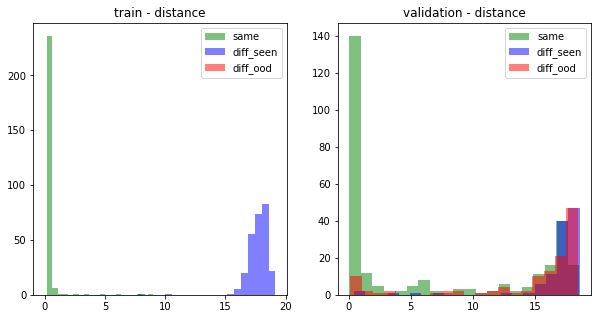

Distance distribution of last training batch:
mean_same = 0.4991094768047333, mean_diff_seen = 17.70853042602539, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.513206481933594, mean_diff_seen = 16.7796688079834, mean_diff_ood = 14.394948959350586


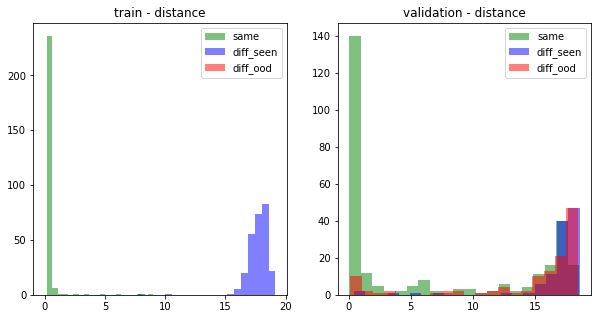

auroc: 0.8462284482758621


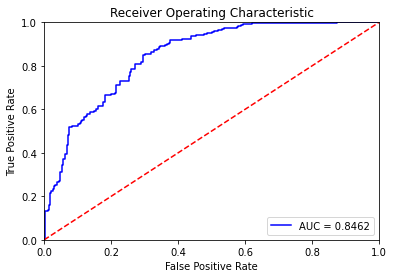

auroc: 0.6682589672591996


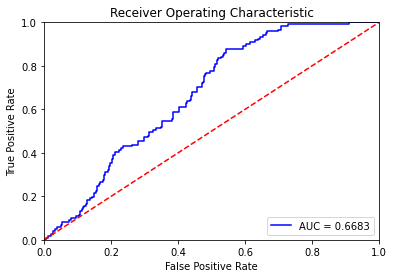

In [8]:
#train 10 more epochs for comparison
model = train()
torch.save(model.state_dict(), "./stat_dict/siamese_without_oe_best_continue.pth")

wandb: Agent Starting Run: p14kppi3 with config:
wandb: 	learning_rate: 0.0001263441077349458
wandb: 	loss_margin: 19
wandb: 	weight_decay: 0.0004068659243330564
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 82.42930225490295, Val loss 76.2354591771176
Val auroc diff 0.7221047450397837, Val auroc ood 0.5975833070925947
Distance distribution of last training batch:
mean_same = 7.80349063873291, mean_diff_seen = 11.711213111877441, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.926233291625977, mean_diff_seen = 11.585116386413574, mean_diff_ood = 10.563514709472656


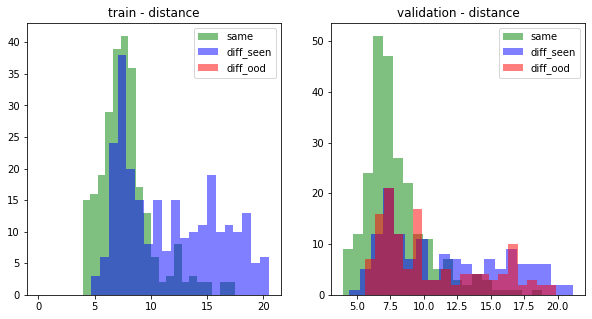


Epoch 1, Train loss 63.274011670928644, Val loss 72.57541696648849
Val auroc diff 0.7508315148404195, Val auroc ood 0.6085277340171698
Distance distribution of last training batch:
mean_same = 7.224661350250244, mean_diff_seen = 13.449045181274414, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.933004379272461, mean_diff_seen = 12.794331550598145, mean_diff_ood = 11.3241548538208

Epoch 2, Train loss 49.65164821664083, Val loss 72.70402105231034
Val auroc diff 0.7613097386727623, Val auroc ood 0.6189694002641233
Distance distribution of last training batch:
mean_same = 5.734653472900391, mean_diff_seen = 14.93572998046875, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.133970260620117, mean_diff_seen = 13.102152824401855, mean_diff_ood = 11.943748474121094

Epoch 3, Train loss 37.149159972200685, Val loss 74.48505522075452
Val auroc diff 0.7517810410171907, Val auroc ood 0.6022504986267865
Distance distribution of las

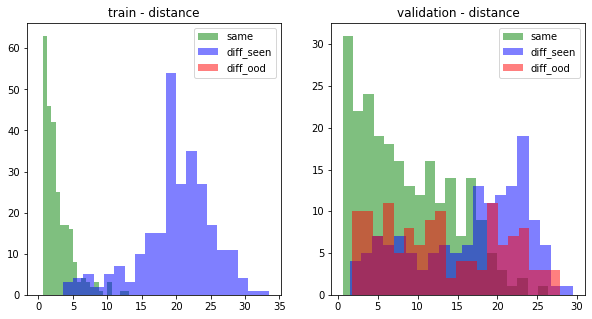

EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6260244992588809

Epoch 11, Train loss 11.570281938179251, Val loss 80.0864237735146
Val auroc diff 0.7665662332954652, Val auroc ood 0.6144380009546193
Distance distribution of last training batch:
mean_same = 3.1106743812561035, mean_diff_seen = 21.31031608581543, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.091082572937012, mean_diff_seen = 15.477063179016113, mean_diff_ood = 14.04960823059082
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6260244992588809

Epoch 12, Train loss 10.77811477110558, Val loss 82.70934295654297
Val auroc diff 0.7597988966324125, Val auroc ood 0.6102786813379879
Distance distribution of last training batch:
mean_same = 2.9269306659698486, mean_diff_seen = 20.65199089050293, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.467668533325195, mean_diff_seen = 16.01891326904297, mean_diff_ood = 12.388486862182617
EarlyStoppin

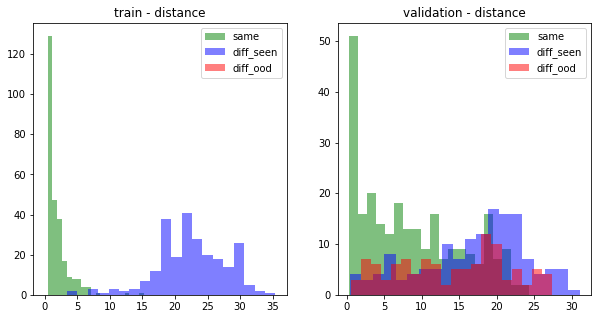


Epoch 21, Train loss 5.9617785522618245, Val loss 87.04463075336658
Val auroc diff 0.7650231260600105, Val auroc ood 0.6150043395627885
Distance distribution of last training batch:
mean_same = 2.2837748527526855, mean_diff_seen = 21.25885772705078, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.738090515136719, mean_diff_seen = 17.468265533447266, mean_diff_ood = 15.840209007263184
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6315614594361616

Epoch 22, Train loss 5.473710613152416, Val loss 88.24678882799651
Val auroc diff 0.7632358328507362, Val auroc ood 0.6168514715409117
Distance distribution of last training batch:
mean_same = 2.1625282764434814, mean_diff_seen = 21.440563201904297, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.959031105041504, mean_diff_seen = 18.21689796447754, mean_diff_ood = 14.353986740112305
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6315614594361616

Epoch 23

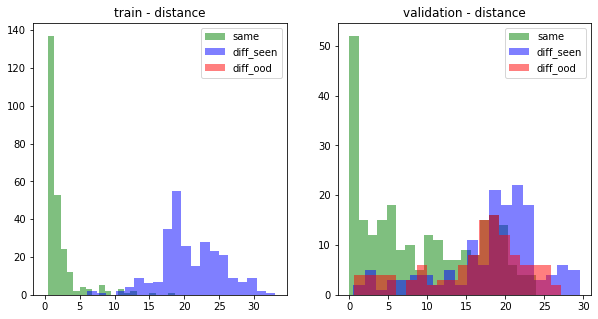


Epoch 31, Train loss 6.076298777590093, Val loss 91.7912079660516
Val auroc diff 0.7588725161249309, Val auroc ood 0.615068757771815
Distance distribution of last training batch:
mean_same = 1.9979686737060547, mean_diff_seen = 21.212932586669922, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 9.394111633300781, mean_diff_seen = 17.599443435668945, mean_diff_ood = 14.142308235168457
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6366911223211276

Epoch 32, Train loss 5.582695840560284, Val loss 88.48592577482525
Val auroc diff 0.781293241617691, Val auroc ood 0.6428624495515963
Distance distribution of last training batch:
mean_same = 1.7231508493423462, mean_diff_seen = 21.087785720825195, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 9.897954940795898, mean_diff_seen = 17.03533363342285, mean_diff_ood = 16.14413833618164

Epoch 33, Train loss 4.575670453690991, Val loss 92.14196536415501
Val auroc diff 0.779

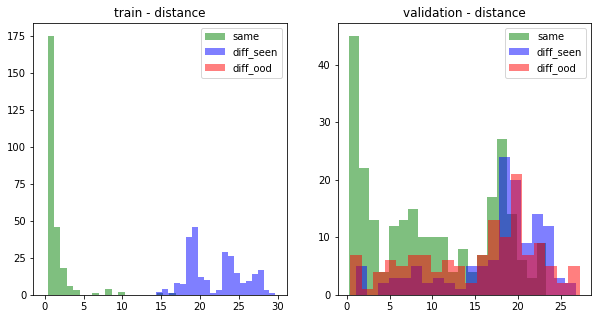

EarlyStopping counter: 8 out of 20, best val auroc ood: 0.6428624495515963

Epoch 41, Train loss 1.9558039879061513, Val loss 94.3732825831363
Val auroc diff 0.7741403880508883, Val auroc ood 0.6292871126808242
Distance distribution of last training batch:
mean_same = 0.9671076536178589, mean_diff_seen = 22.353076934814453, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 9.887295722961426, mean_diff_seen = 17.881925582885742, mean_diff_ood = 14.86365032196045
EarlyStopping counter: 9 out of 20, best val auroc ood: 0.6428624495515963

Epoch 42, Train loss 1.8533775794137384, Val loss 91.99724538702714
Val auroc diff 0.7707108154968666, Val auroc ood 0.6294187239460322
Distance distribution of last training batch:
mean_same = 1.1996504068374634, mean_diff_seen = 21.537757873535156, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 9.28150749206543, mean_diff_seen = 17.212125778198242, mean_diff_ood = 15.575542449951172
EarlyStop

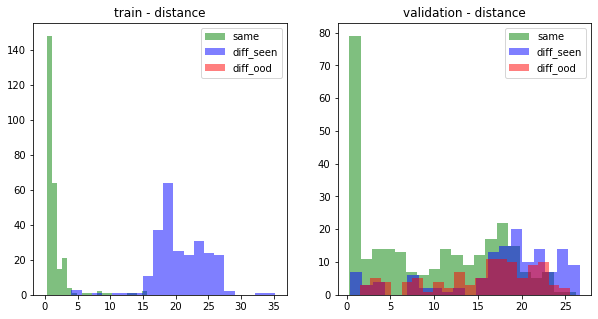

EarlyStopping counter: 18 out of 20, best val auroc ood: 0.6428624495515963

Epoch 51, Train loss 3.5146277467000115, Val loss 97.48054223311574
Val auroc diff 0.7764594438270456, Val auroc ood 0.6374134024848268
Distance distribution of last training batch:
mean_same = 1.418497920036316, mean_diff_seen = 21.193811416625977, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 9.737664222717285, mean_diff_seen = 17.345626831054688, mean_diff_ood = 15.5773344039917
EarlyStopping counter: 19 out of 20, best val auroc ood: 0.6428624495515963

Epoch 52, Train loss 2.5930995179205825, Val loss 95.16195156699733
Val auroc diff 0.768293722624652, Val auroc ood 0.6374476939944962
Distance distribution of last training batch:
mean_same = 1.220649242401123, mean_diff_seen = 21.25421905517578, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.707869529724121, mean_diff_seen = 17.473657608032227, mean_diff_ood = 15.183036804199219
EarlyStopp

Epoch,52
Train Loss,2.5931
Val Loss,95.16195
Val auroc diff,0.76829
Val auroc ood,0.63745
Train mean distance (same),1.22065
Train mean distance (diff_seen),21.25422
Train mean distance (diff_ood),NA
Val mean distance (same),8.70787
Val mean distance (diff_seen),17.47366
Val mean distance (diff_ood),15.18304


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▆▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
Val Loss,▂▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▆▆▇▇█▇▇▆▇▇▇█▆▇▇▇▇
Val auroc diff,▁▄▆▆▅▇▇▇▆▅▆▆▇▇▇█▆▆██▇▇▆▇███▇▇▇▇▇▇▇▇▇▅▅▇▆
Val auroc ood,▁▃▄▄▂▄▅▅▃▃▄▃▅▅▆▆▄▄▆▆▅▇▄▇█▇▇▇▆▆▆▆▆▅▆▆▅▄▇▇
Train mean distance (same),█▇▆▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁
Train mean distance (diff_seen),▁▂▃▅▅▆▆▆▆▇▇▇█▇██▇▇█████▇▇▇▇█████▇██▇▇▆▇▇
Val mean distance (same),▃▃▃▂▁▄▄▄▄▄▄▃▅▅▄▅▅▅▅▆▅▄▆▆▇▆▇▆▄█▇▇▆▄▇▆▅▄▆▅
Val mean distance (diff_seen),▁▂▃▄▅▅▅▇▆▆▆▆▇▇█▇▇████▆▇█▇▇▇▇▆▇▇█▇▇█▆▅▆▇▇
Val mean distance (diff_ood),▁▂▃▃▃▅▄▆▄▃▄▄▄▆▆▅▇▅▇▇▆▅▆▇▇█▇▇▇▆▆▆▇███▆▇▆▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 1.220649242401123, mean_diff_seen = 21.25421905517578, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.707869529724121, mean_diff_seen = 17.473657608032227, mean_diff_ood = 15.183036804199219


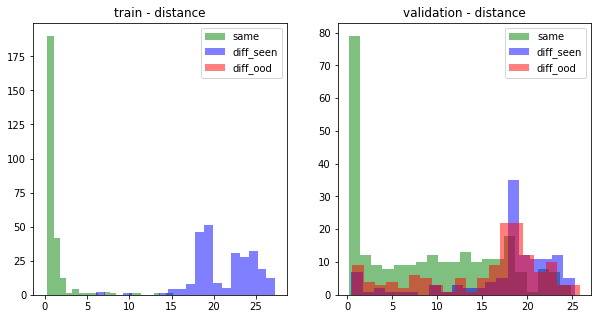

Distance distribution of last training batch:
mean_same = 1.220649242401123, mean_diff_seen = 21.25421905517578, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.707869529724121, mean_diff_seen = 17.473657608032227, mean_diff_ood = 15.183036804199219


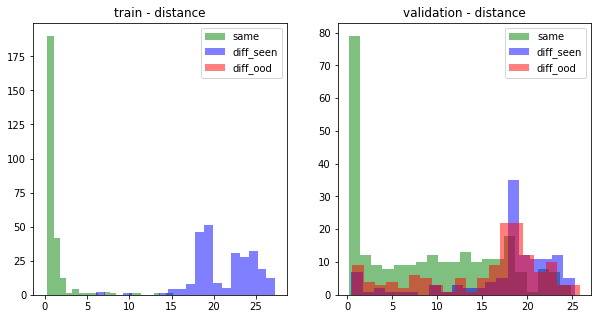

auroc: 0.782513160906386


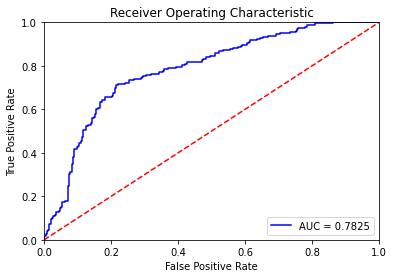

auroc: 0.6309840425531915


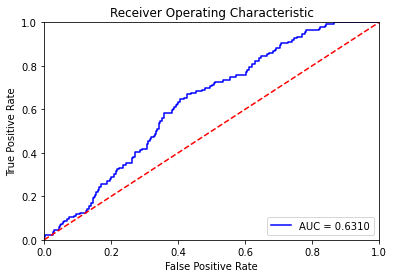

wandb: Agent Starting Run: 9rv4fbhv with config:
wandb: 	learning_rate: 0.0006312074116185295
wandb: 	loss_margin: 2
wandb: 	weight_decay: 0.00011172449796775063
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 3.949973083648485, Val loss 0.9501664575777555
Val auroc diff 0.6169991370964214, Val auroc ood 0.532047797100355
Distance distribution of last training batch:
mean_same = 0.9313802123069763, mean_diff_seen = 1.1008483171463013, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9264002442359924, mean_diff_seen = 1.0832698345184326, mean_diff_ood = 1.0094640254974365


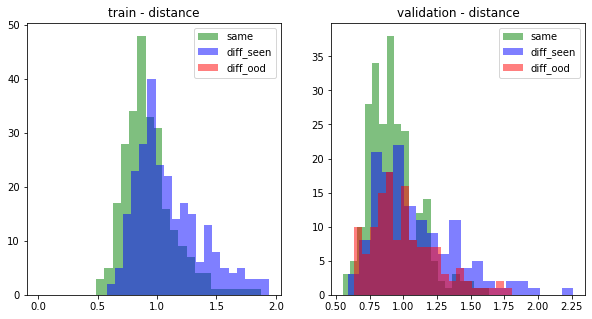


Epoch 1, Train loss 0.8689036314020452, Val loss 0.900783824293237
Val auroc diff 0.6669614465976398, Val auroc ood 0.5574980611723759
Distance distribution of last training batch:
mean_same = 0.9122922420501709, mean_diff_seen = 1.2099272012710571, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9059146046638489, mean_diff_seen = 1.1839196681976318, mean_diff_ood = 1.0399266481399536

Epoch 2, Train loss 0.7981610642266028, Val loss 0.869317164546565
Val auroc diff 0.6962743559809049, Val auroc ood 0.5695034831122344
Distance distribution of last training batch:
mean_same = 0.8442654609680176, mean_diff_seen = 1.321178674697876, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8668487668037415, mean_diff_seen = 1.2137385606765747, mean_diff_ood = 1.0889102220535278

Epoch 3, Train loss 0.7401384219680864, Val loss 0.8443363371648287
Val auroc diff 0.7163697859901907, Val auroc ood 0.5806547596870659
Distance distributio

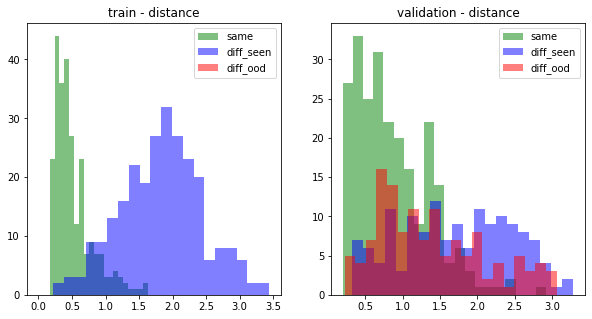


Epoch 11, Train loss 0.29284123492609593, Val loss 0.845211829009809
Val auroc diff 0.7536568614260828, Val auroc ood 0.6110603879912783
Distance distribution of last training batch:
mean_same = 0.5111414790153503, mean_diff_seen = 1.9031211137771606, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9204397797584534, mean_diff_seen = 1.5340780019760132, mean_diff_ood = 1.4036234617233276

Epoch 12, Train loss 0.26504747246958543, Val loss 0.8256112619450218
Val auroc diff 0.7536137570968211, Val auroc ood 0.6050205381042438
Distance distribution of last training batch:
mean_same = 0.48918843269348145, mean_diff_seen = 1.784739375114441, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8169269561767578, mean_diff_seen = 1.455354928970337, mean_diff_ood = 1.1645845174789429
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6110603879912783

Epoch 13, Train loss 0.2444726732588306, Val loss 0.8796188705845883
Val aur

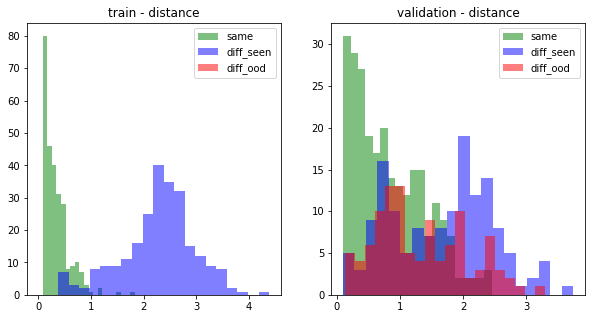

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6294254891374665

Epoch 21, Train loss 0.15496274106895802, Val loss 0.8620126529743797
Val auroc diff 0.7770473669472227, Val auroc ood 0.6290946140943829
Distance distribution of last training batch:
mean_same = 0.4018368721008301, mean_diff_seen = 2.1590240001678467, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8124476671218872, mean_diff_seen = 1.7397570610046387, mean_diff_ood = 1.5518723726272583
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6294254891374665

Epoch 22, Train loss 0.14565529198068933, Val loss 0.9255671312934474
Val auroc diff 0.7687514315711423, Val auroc ood 0.6138054808263304
Distance distribution of last training batch:
mean_same = 0.3428792655467987, mean_diff_seen = 2.1653928756713867, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9291303753852844, mean_diff_seen = 1.8898522853851318, mean_diff_ood = 1.4845800399780273


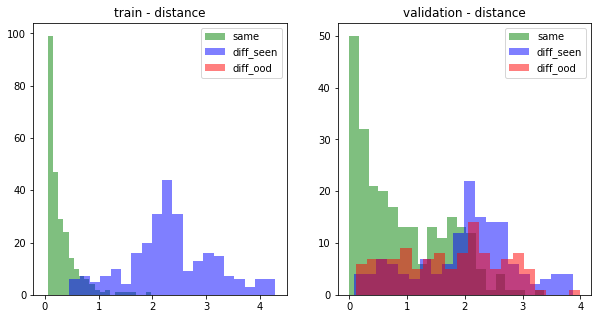

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.633509035140286

Epoch 31, Train loss 0.12372688449842413, Val loss 0.9503223801914015
Val auroc diff 0.7603898844198904, Val auroc ood 0.6125732246955796
Distance distribution of last training batch:
mean_same = 0.2615341544151306, mean_diff_seen = 2.1448636054992676, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9295422434806824, mean_diff_seen = 1.831350564956665, mean_diff_ood = 1.5107229948043823
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.633509035140286

Epoch 32, Train loss 0.11629369255808211, Val loss 1.0013611693131297
Val auroc diff 0.7788691432381116, Val auroc ood 0.6329346613548068
Distance distribution of last training batch:
mean_same = 0.25327086448669434, mean_diff_seen = 2.276357650756836, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9627312421798706, mean_diff_seen = 1.959791660308838, mean_diff_ood = 1.6862282752990723
Earl

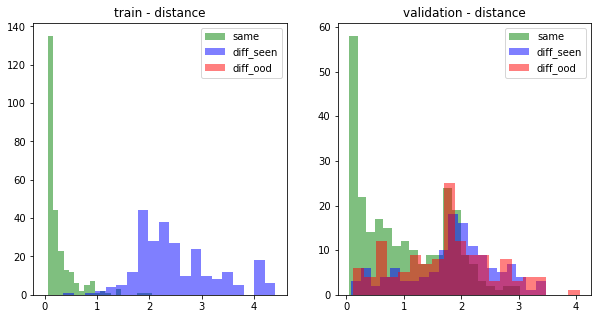

EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6404509556039504

Epoch 41, Train loss 0.08924760174044628, Val loss 1.0681623502781517
Val auroc diff 0.7741415715581232, Val auroc ood 0.6230667046557289
Distance distribution of last training batch:
mean_same = 0.17971982061862946, mean_diff_seen = 2.2700438499450684, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9216329455375671, mean_diff_seen = 2.040778875350952, mean_diff_ood = 1.6535764932632446
EarlyStopping counter: 5 out of 20, best val auroc ood: 0.6404509556039504

Epoch 42, Train loss 0.08850340522134427, Val loss 1.068782222898383
Val auroc diff 0.7855096654642779, Val auroc ood 0.6428447008630659
Distance distribution of last training batch:
mean_same = 0.24358703196048737, mean_diff_seen = 2.5164952278137207, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9698824882507324, mean_diff_seen = 1.9869465827941895, mean_diff_ood = 1.7039029598236084


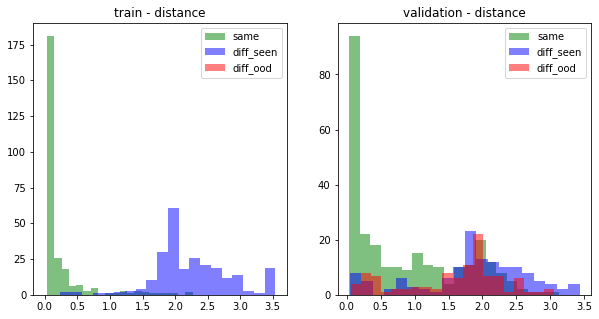


Epoch 51, Train loss 0.06973109052506919, Val loss 1.018650167866757
Val auroc diff 0.7828783489802098, Val auroc ood 0.6393357803400822
Distance distribution of last training batch:
mean_same = 0.2576411962509155, mean_diff_seen = 2.3661880493164062, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9764318466186523, mean_diff_seen = 1.9285751581192017, mean_diff_ood = 1.745431900024414
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6463196984288435

Epoch 52, Train loss 0.0695357904145398, Val loss 1.0255432285760577
Val auroc diff 0.7848563986326196, Val auroc ood 0.6466977608207363
Distance distribution of last training batch:
mean_same = 0.18919523060321808, mean_diff_seen = 2.428008794784546, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8406379818916321, mean_diff_seen = 1.982163906097412, mean_diff_ood = 1.7850974798202515

Epoch 53, Train loss 0.07261850320033192, Val loss 1.0863160553731417
Val auro

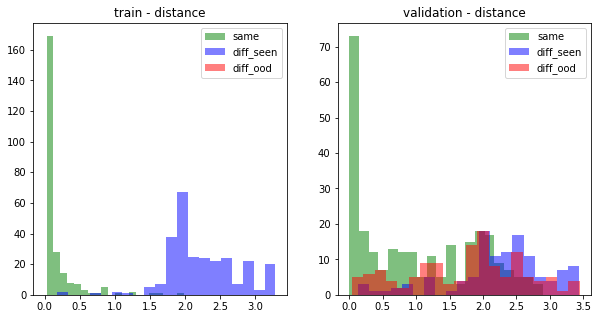

EarlyStopping counter: 5 out of 20, best val auroc ood: 0.6498830746018991

Epoch 61, Train loss 0.07276984941713589, Val loss 1.0363015187414069
Val auroc diff 0.7871363697941532, Val auroc ood 0.6460927855817413
Distance distribution of last training batch:
mean_same = 0.16538074612617493, mean_diff_seen = 2.28479266166687, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8851925730705261, mean_diff_seen = 1.9991095066070557, mean_diff_ood = 1.6627392768859863
EarlyStopping counter: 6 out of 20, best val auroc ood: 0.6498830746018991

Epoch 62, Train loss 0.06460114220906164, Val loss 1.0757325636713129
Val auroc diff 0.7841225929329297, Val auroc ood 0.6381288575120152
Distance distribution of last training batch:
mean_same = 0.18932810425758362, mean_diff_seen = 2.3823482990264893, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.984926700592041, mean_diff_seen = 2.042274236679077, mean_diff_ood = 1.8047884702682495
Ea

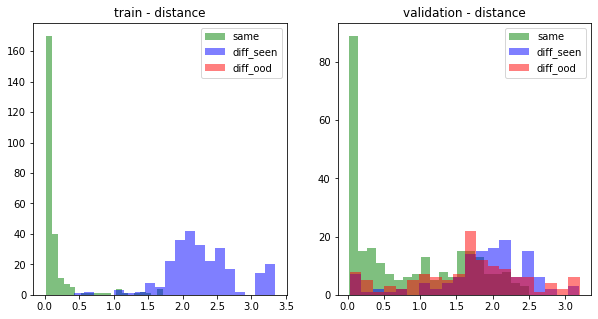

EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6535920384805423

Epoch 71, Train loss 0.05159119295782035, Val loss 1.1087754964828491
Val auroc diff 0.7867657563692976, Val auroc ood 0.6502519226387927
Distance distribution of last training batch:
mean_same = 0.18074746429920197, mean_diff_seen = 2.3328192234039307, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9538731575012207, mean_diff_seen = 2.1084327697753906, mean_diff_ood = 1.823271632194519
EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6535920384805423

Epoch 72, Train loss 0.055896224473247824, Val loss 1.0509251826687862
Val auroc diff 0.7962517644827065, Val auroc ood 0.6516999844350414
Distance distribution of last training batch:
mean_same = 0.17545612156391144, mean_diff_seen = 2.274320125579834, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9126712083816528, mean_diff_seen = 2.0741214752197266, mean_diff_ood = 1.912329912185669


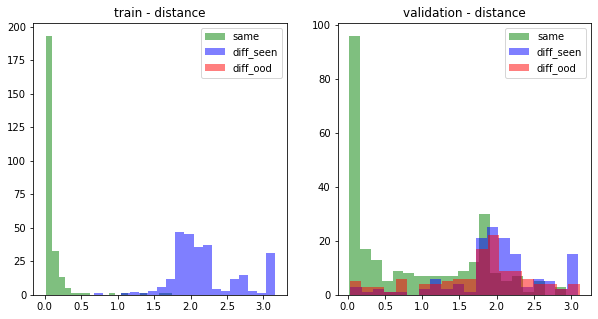

EarlyStopping counter: 12 out of 20, best val auroc ood: 0.6535920384805423

Epoch 81, Train loss 0.04416143037762839, Val loss 1.0354141247899908
Val auroc diff 0.7880318253549095, Val auroc ood 0.648020506288413
Distance distribution of last training batch:
mean_same = 0.13491475582122803, mean_diff_seen = 2.185433864593506, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 1.0055952072143555, mean_diff_seen = 2.000446319580078, mean_diff_ood = 1.69098961353302
EarlyStopping counter: 13 out of 20, best val auroc ood: 0.6535920384805423

Epoch 82, Train loss 0.04522043061394667, Val loss 1.0870906051836515
Val auroc diff 0.793079723150208, Val auroc ood 0.6468960171880884
Distance distribution of last training batch:
mean_same = 0.12114884704351425, mean_diff_seen = 2.3095149993896484, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.9584571123123169, mean_diff_seen = 2.053236961364746, mean_diff_ood = 1.7837742567062378
Ear

Epoch,88
Train Loss,0.0494
Val Loss,1.00997
Val auroc diff,0.78553
Val auroc ood,0.64545
Train mean distance (same),0.13442
Train mean distance (diff_seen),2.31827
Train mean distance (diff_ood),NA
Val mean distance (same),0.86635
Val mean distance (diff_seen),1.89798
Val mean distance (diff_ood),1.71832


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▄▂▁▁▁▁▂▁▂▂▃▄▂▃▄▅▅▇▆▇▆▅▆▆▂▅▆█▇▄█▇▇▄▄▅▆▄▇▆
Val auroc diff,▁▄▅▅▆▆▆▇▇▇▇▇█▇▇▇▇▆▇█▇▇▇▇▇█▇▇▇██▇█▇████▇█
Val auroc ood,▁▃▄▅▅▆▅▆▆▆▆▆▇▇▆▇▇▆▇▇▇█▆▇▇▇█▇▇█████▇███▇█
Train mean distance (same),█▇▇▆▅▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▂▃▃▄▅▆▆▆▇▆███▆▇▇███▇▇▇▇▆▇▇▇▆▇▇▇▇▆▆▇▆▆▇▇
Val mean distance (same),▅▃▃▄▂▅▄▂▂▂▅▆▁▃▅▃▅▆▆▆▃█▅▆▁▄▆▇▅▄▂█▄▄▅▃▇▂█▃
Val mean distance (diff_seen),▁▂▃▃▄▄▅▄▅▄▆▆▅▆▅▅▆▆▆▆▆▆▆▆▅▇▆█▇▆▇▆▇▅▅▆▆▆▇▆
Val mean distance (diff_ood),▁▂▂▃▃▄▃▃▄▃▅▅▅▅▅▆▆▅▆▆▆▅▇▆▅▆▆▆▆▅▇██▆▆▇▆▆▆▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.13441501557826996, mean_diff_seen = 2.3182690143585205, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8663464784622192, mean_diff_seen = 1.8979811668395996, mean_diff_ood = 1.718320608139038


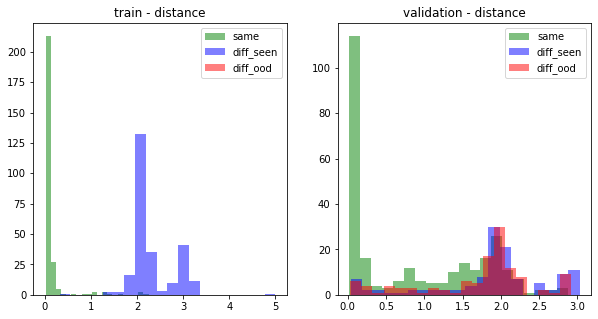

Distance distribution of last training batch:
mean_same = 0.13441501557826996, mean_diff_seen = 2.3182690143585205, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 0.8663464784622192, mean_diff_seen = 1.8979811668395996, mean_diff_ood = 1.718320608139038


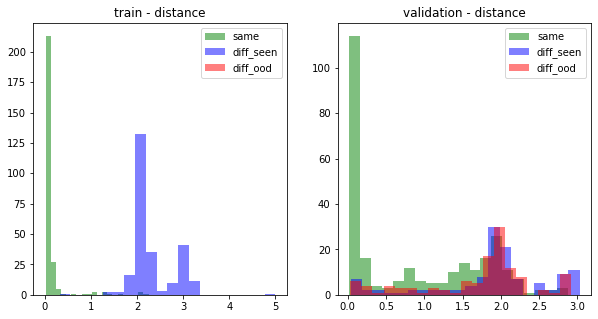

auroc: 0.7998221186284733


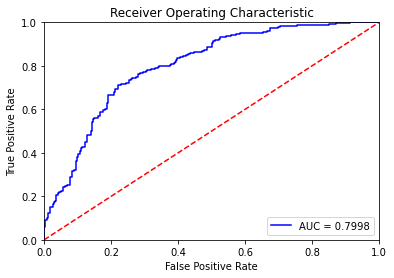

auroc: 0.6717284694140927


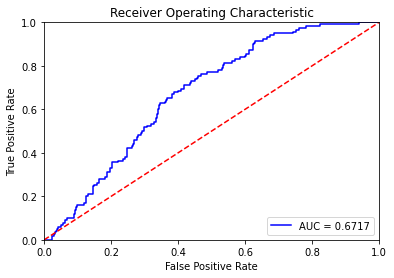

wandb: Agent Starting Run: oeu33570 with config:
wandb: 	learning_rate: 0.0005160083882774818
wandb: 	loss_margin: 11
wandb: 	weight_decay: 0.0003566797786402078
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 27.531433813350716, Val loss 24.87919265345523
Val auroc diff 0.739256639105742, Val auroc ood 0.6013318804290355
Distance distribution of last training batch:
mean_same = 4.160733699798584, mean_diff_seen = 6.71160364151001, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.257737159729004, mean_diff_seen = 7.031440258026123, mean_diff_ood = 6.130396842956543


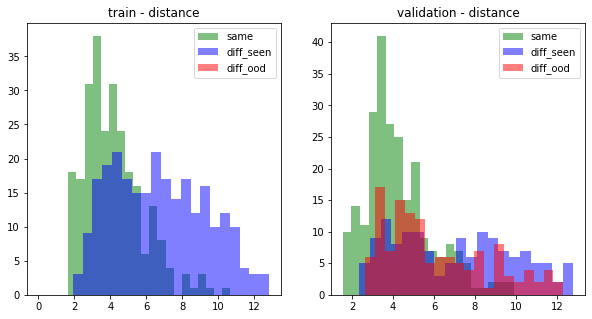


Epoch 1, Train loss 20.301889478545828, Val loss 22.82830137955515
Val auroc diff 0.7837874165827533, Val auroc ood 0.6328733909532186
Distance distribution of last training batch:
mean_same = 3.642580032348633, mean_diff_seen = 7.422521114349365, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.239089488983154, mean_diff_seen = 7.328981876373291, mean_diff_ood = 6.4941792488098145

Epoch 2, Train loss 16.343874823186816, Val loss 22.73910281532689
Val auroc diff 0.790914920075102, Val auroc ood 0.6249284149104495
Distance distribution of last training batch:
mean_same = 3.2289655208587646, mean_diff_seen = 8.885488510131836, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.180390357971191, mean_diff_seen = 8.118078231811523, mean_diff_ood = 6.7840189933776855
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6328733909532186

Epoch 3, Train loss 13.11653250271512, Val loss 23.01141949703819
Val auroc diff 0.78576

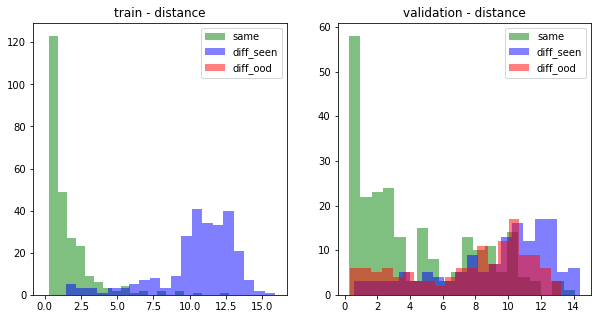


Epoch 11, Train loss 4.487176919720836, Val loss 25.302127637361224
Val auroc diff 0.8023466520723169, Val auroc ood 0.6369365827523491
Distance distribution of last training batch:
mean_same = 1.5570582151412964, mean_diff_seen = 11.296319961547852, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.420322418212891, mean_diff_seen = 9.65162467956543, mean_diff_ood = 8.326150894165039
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6428042729826136

Epoch 12, Train loss 3.997391056768673, Val loss 24.31342215287058
Val auroc diff 0.8154359240323131, Val auroc ood 0.647246790331704
Distance distribution of last training batch:
mean_same = 1.2899377346038818, mean_diff_seen = 10.621099472045898, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.190967082977295, mean_diff_seen = 9.280333518981934, mean_diff_ood = 7.242715835571289

Epoch 13, Train loss 3.757503049889791, Val loss 24.498740647968493
Val auroc diff 0.80

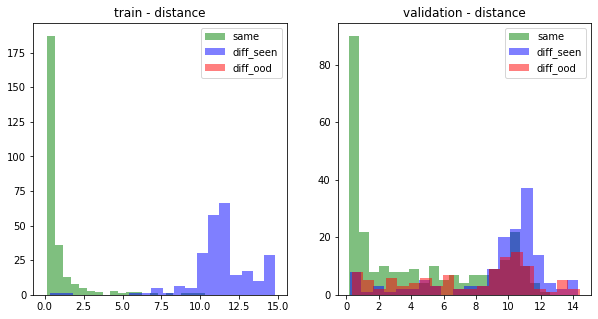

EarlyStopping counter: 6 out of 20, best val auroc ood: 0.65308535837984

Epoch 21, Train loss 2.0228351293150912, Val loss 25.16612213536313
Val auroc diff 0.808196737941638, Val auroc ood 0.6325552595168031
Distance distribution of last training batch:
mean_same = 0.9764533042907715, mean_diff_seen = 11.105820655822754, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.305419445037842, mean_diff_seen = 9.575870513916016, mean_diff_ood = 8.671857833862305
EarlyStopping counter: 7 out of 20, best val auroc ood: 0.65308535837984

Epoch 22, Train loss 2.0232687955050124, Val loss 24.833960984882555
Val auroc diff 0.8183619153023867, Val auroc ood 0.6460484953932807
Distance distribution of last training batch:
mean_same = 1.0318504571914673, mean_diff_seen = 11.116267204284668, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.315577983856201, mean_diff_seen = 10.248976707458496, mean_diff_ood = 8.462323188781738
EarlyStopping

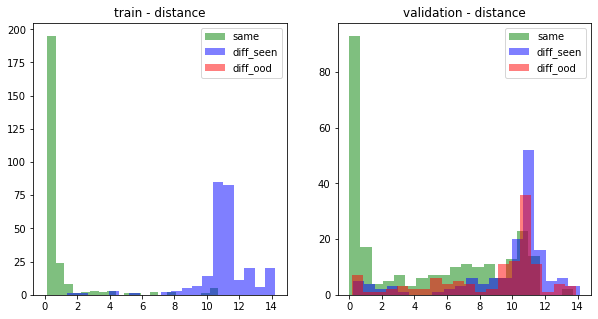

EarlyStopping counter: 16 out of 20, best val auroc ood: 0.65308535837984

Epoch 31, Train loss 1.3600560343757118, Val loss 26.853839071173418
Val auroc diff 0.8119389835219597, Val auroc ood 0.6371067859532324
Distance distribution of last training batch:
mean_same = 0.747809886932373, mean_diff_seen = 11.716453552246094, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.865009307861328, mean_diff_seen = 10.51891803741455, mean_diff_ood = 8.90949535369873
EarlyStopping counter: 17 out of 20, best val auroc ood: 0.65308535837984

Epoch 32, Train loss 1.4036484508170295, Val loss 26.100801467895508
Val auroc diff 0.8115183781617142, Val auroc ood 0.640670078528182
Distance distribution of last training batch:
mean_same = 0.8657954335212708, mean_diff_seen = 11.352699279785156, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.500710964202881, mean_diff_seen = 10.109100341796875, mean_diff_ood = 9.078408241271973
EarlyStoppin

Epoch,34
Train Loss,1.27917
Val Loss,26.67956
Val auroc diff,0.81257
Val auroc ood,0.63775
Train mean distance (same),0.56368
Train mean distance (diff_seen),11.19438
Train mean distance (diff_ood),NA
Val mean distance (same),4.81923
Val mean distance (diff_seen),10.39305
Val mean distance (diff_ood),8.84373


Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▄▁▁▁▄▂▄▂▂▂▂▄▃▃▃▃▄▄▄▄▄▄▄▅▆▆▇▅█▆▆▆▅▆▆
Val auroc diff,▁▅▆▅▅▇▆▇█▇▇▇█▇█▇▇█▇██▇█▇██▇█▆▇▇▇▇█▇
Val auroc ood,▁▅▄▄▃▆▄▆▆▆▇▆▇▅█▆▅▇▆▆▇▅▇▆▇▇▆█▆▆▇▆▆▇▆
Train mean distance (same),█▇▆▅▅▄▅▄▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁
Train mean distance (diff_seen),▁▂▄▃▆▅▇▆▆▇▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇▇▇█▇▇▇
Val mean distance (same),▄▄▃▁▃▂▆▁▂▂▃▅▃▂▄▂▇▆▂▆▃▄▄▆▄▆█▅▅▅▅▇▅▃▇
Val mean distance (diff_seen),▁▂▃▂▄▄▅▅▅▆▅▆▅▅█▆▅▆▅▇▆▆▇▆▇██▆▇▇▆█▇▆█
Val mean distance (diff_ood),▁▂▃▁▄▄▅▅▅▄▄▆▄▄▅▆▄▆▆▇▄▇▆▅▇█▇▆▇▆▇▇█▇▇
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.5636779069900513, mean_diff_seen = 11.194380760192871, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.819231986999512, mean_diff_seen = 10.393051147460938, mean_diff_ood = 8.843729019165039


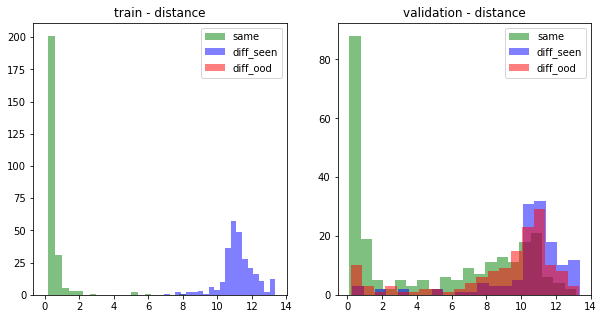

Distance distribution of last training batch:
mean_same = 0.5636779069900513, mean_diff_seen = 11.194380760192871, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.819231986999512, mean_diff_seen = 10.393051147460938, mean_diff_ood = 8.843729019165039


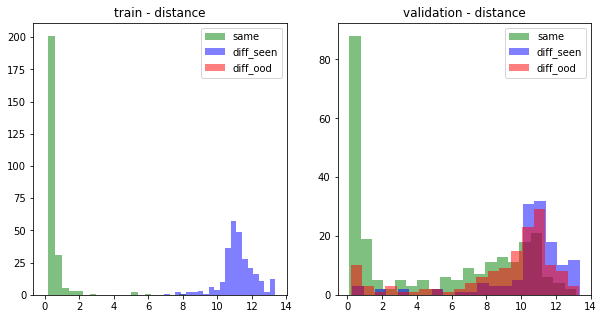

auroc: 0.8146311600857055


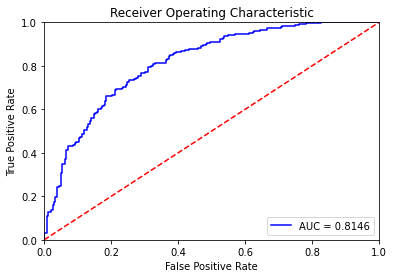

auroc: 0.6155684272906272


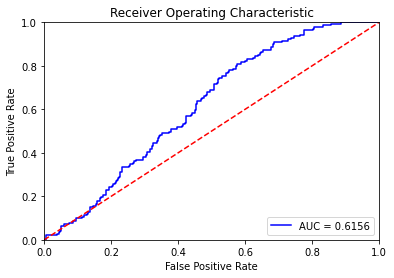

wandb: Agent Starting Run: 98rn1xym with config:
wandb: 	learning_rate: 0.0005931989685542704
wandb: 	loss_margin: 18
wandb: 	weight_decay: 0.00021772148747021075
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 66.14479949793865, Val loss 64.04201788651316
Val auroc diff 0.759434401892428, Val auroc ood 0.612347226344511
Distance distribution of last training batch:
mean_same = 7.039487361907959, mean_diff_seen = 11.999726295471191, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.795471668243408, mean_diff_seen = 12.276705741882324, mean_diff_ood = 10.51308536529541


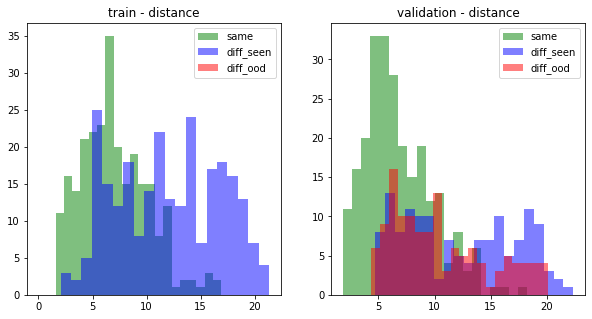


Epoch 1, Train loss 50.85120855901659, Val loss 62.12888356258995
Val auroc diff 0.7776269218022052, Val auroc ood 0.6130682724032546
Distance distribution of last training batch:
mean_same = 5.484472274780273, mean_diff_seen = 12.721672058105469, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.3860931396484375, mean_diff_seen = 12.130494117736816, mean_diff_ood = 10.22171401977539

Epoch 2, Train loss 40.67669968752517, Val loss 61.642088639108756
Val auroc diff 0.7980603767109102, Val auroc ood 0.6343464639390464
Distance distribution of last training batch:
mean_same = 4.951513767242432, mean_diff_seen = 14.688446998596191, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.861382007598877, mean_diff_seen = 13.810050010681152, mean_diff_ood = 11.75696849822998

Epoch 3, Train loss 33.19605213833838, Val loss 63.173445450632194
Val auroc diff 0.7869213151555077, Val auroc ood 0.6230328995455287
Distance distribution of l

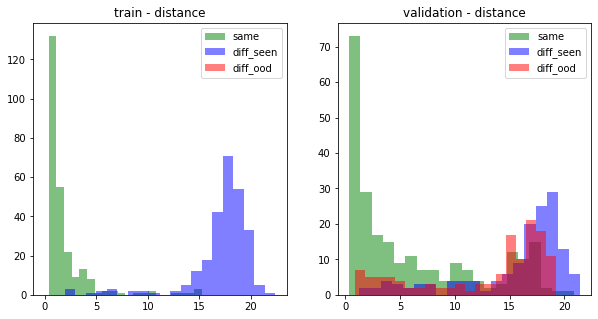


Epoch 11, Train loss 9.357937596507908, Val loss 62.149621060020046
Val auroc diff 0.8242304627378497, Val auroc ood 0.6463276946674636
Distance distribution of last training batch:
mean_same = 1.899465560913086, mean_diff_seen = 17.5075626373291, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.800048828125, mean_diff_seen = 15.111825942993164, mean_diff_ood = 14.176087379455566
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6490527728120202

Epoch 12, Train loss 8.258081711444659, Val loss 62.73852298134252
Val auroc diff 0.8259543512516443, Val auroc ood 0.6512094942944079
Distance distribution of last training batch:
mean_same = 1.8300824165344238, mean_diff_seen = 17.500295639038086, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.940683364868164, mean_diff_seen = 15.12255859375, mean_diff_ood = 12.240528106689453

Epoch 13, Train loss 7.410300441623963, Val loss 65.96934248271741
Val auroc diff 0.8158633

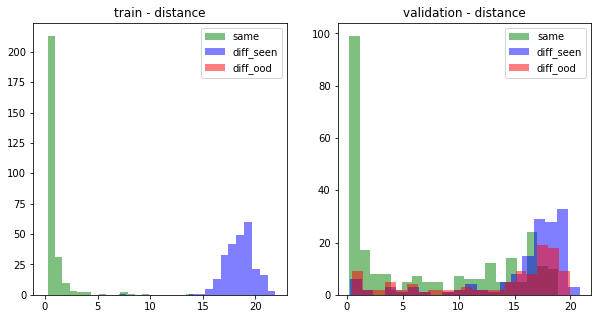


Epoch 21, Train loss 4.477581530502162, Val loss 67.58086857042815
Val auroc diff 0.8165479666291535, Val auroc ood 0.6400317006204511
Distance distribution of last training batch:
mean_same = 1.5114696025848389, mean_diff_seen = 17.874889373779297, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.564363479614258, mean_diff_seen = 16.28118133544922, mean_diff_ood = 13.302384376525879
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6555527116872547

Epoch 22, Train loss 4.741854136752099, Val loss 66.42096609818309
Val auroc diff 0.8198197455648715, Val auroc ood 0.6450938888988861
Distance distribution of last training batch:
mean_same = 1.4920668601989746, mean_diff_seen = 17.467601776123047, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.321357250213623, mean_diff_seen = 15.904947280883789, mean_diff_ood = 14.224882125854492
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6555527116872547

Epoch 23

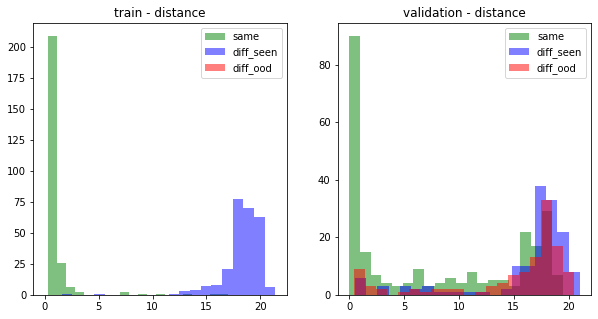

EarlyStopping counter: 10 out of 20, best val auroc ood: 0.6555527116872547

Epoch 31, Train loss 3.02844661535676, Val loss 70.8665855809262
Val auroc diff 0.820695536586673, Val auroc ood 0.6482477612317759
Distance distribution of last training batch:
mean_same = 1.1140315532684326, mean_diff_seen = 18.55217170715332, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.680594444274902, mean_diff_seen = 17.057884216308594, mean_diff_ood = 14.66235065460205
EarlyStopping counter: 11 out of 20, best val auroc ood: 0.6555527116872547

Epoch 32, Train loss 2.4948466967061624, Val loss 72.49466203388415
Val auroc diff 0.8136861837360944, Val auroc ood 0.6447055835828388
Distance distribution of last training batch:
mean_same = 0.9254890084266663, mean_diff_seen = 18.554738998413086, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.817877769470215, mean_diff_seen = 16.49764633178711, mean_diff_ood = 13.591341018676758
EarlyStoppi

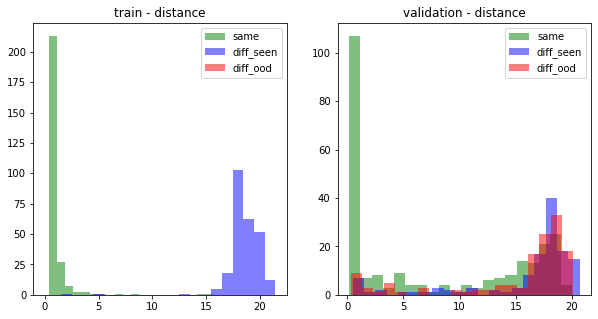

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6583359877708765

Epoch 41, Train loss 1.8264241470504052, Val loss 71.52757925736277
Val auroc diff 0.8051206765265501, Val auroc ood 0.6332679244431405
Distance distribution of last training batch:
mean_same = 0.8838229775428772, mean_diff_seen = 18.293689727783203, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.870460510253906, mean_diff_seen = 16.049516677856445, mean_diff_ood = 13.44633674621582
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6583359877708765

Epoch 42, Train loss 1.8082531810421305, Val loss 73.02087020874023
Val auroc diff 0.8129548795652801, Val auroc ood 0.6461826366219993
Distance distribution of last training batch:
mean_same = 0.8402074575424194, mean_diff_seen = 18.690345764160156, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.344254970550537, mean_diff_seen = 16.30532455444336, mean_diff_ood = 14.170797348022461
EarlySto

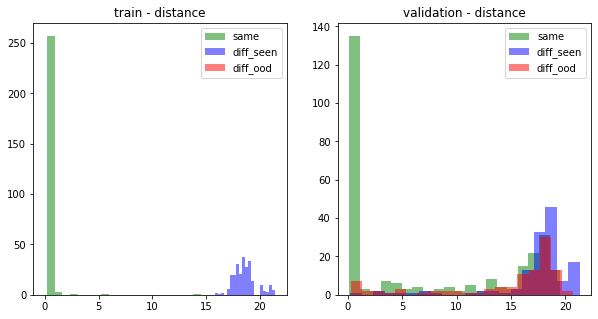

EarlyStopping counter: 13 out of 20, best val auroc ood: 0.6583359877708765

Epoch 51, Train loss 1.426449079796211, Val loss 70.99139484606292
Val auroc diff 0.8158611640451026, Val auroc ood 0.6532031309305629
Distance distribution of last training batch:
mean_same = 0.7507122755050659, mean_diff_seen = 18.528703689575195, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.176380634307861, mean_diff_seen = 16.83854866027832, mean_diff_ood = 14.927536964416504
EarlyStopping counter: 14 out of 20, best val auroc ood: 0.6583359877708765

Epoch 52, Train loss 1.6444139849279344, Val loss 76.34865851151316
Val auroc diff 0.800665683927996, Val auroc ood 0.6432052045557397
Distance distribution of last training batch:
mean_same = 0.8188812732696533, mean_diff_seen = 18.691818237304688, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.864112377166748, mean_diff_seen = 16.480051040649414, mean_diff_ood = 15.238812446594238
EarlySt

Epoch,57
Train Loss,1.29992
Val Loss,71.51916
Val auroc diff,0.82276
Val auroc ood,0.64423
Train mean distance (same),0.57908
Train mean distance (diff_seen),18.50842
Train mean distance (diff_ood),NA
Val mean distance (same),7.45319
Val mean distance (diff_seen),17.21012
Val mean distance (diff_ood),13.84937


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▃▂▂▂▂▁▃▂▂▄▄▃▄▄▄▄▄▅▆▄▅▅▆▆▆▆▇▅▇▇▆▅▆▇▆▆█▆▆▆
Val auroc diff,▁▃▅▅▆▇▆██▇▆▇▇██▇▇▆▇█▇▇▆▇▇▇▆▇▆▆▇▇▇▇▇▇▅▇▇▇
Val auroc ood,▁▁▄▄▅▆▅▇▆█▆▇▆▆█▅▇▆▅▇▆▆▆█▅▆▅▇▆▆▆▇▆▇▇▇▆▇▆▆
Train mean distance (same),█▆▆▅▄▃▃▂▂▃▃▃▂▂▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▂▄▅▅▅▆▆▇▆▇▇▇▇█▇▇▇██▇▇██▇▇████▇█▇█▇███▇█
Val mean distance (same),▄▃▄▃▁▃▄▂▄▄▃▅▆▄▄▆▇▄▆▄▆▇▆▅█▅▆▄▆▅▅▄█▆▃▅▄▅▅▆
Val mean distance (diff_seen),▁▁▃▃▄▄▄▆▅▅▅▅▇▇▆▇▆▅▇▆▇▆▇▇▇▆▆█▆▇▇▇▆█▇▇▇▇▇█
Val mean distance (diff_ood),▁▁▃▃▃▅▅▅▇▄▅▆▇▇▅▅▅▇▇▆▇▇▆█▆▇▇▇█▇▇█▆█████▇▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.5790780186653137, mean_diff_seen = 18.50841522216797, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.453192710876465, mean_diff_seen = 17.210121154785156, mean_diff_ood = 13.849370956420898


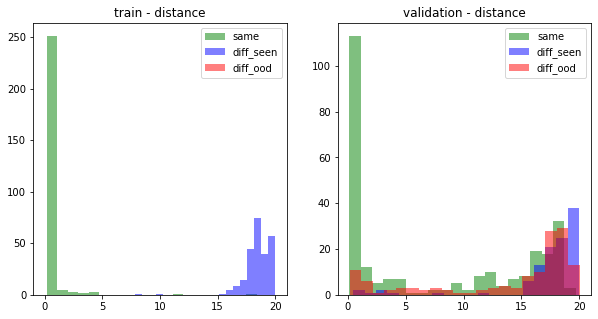

Distance distribution of last training batch:
mean_same = 0.5790780186653137, mean_diff_seen = 18.50841522216797, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 7.453192710876465, mean_diff_seen = 17.210121154785156, mean_diff_ood = 13.849370956420898


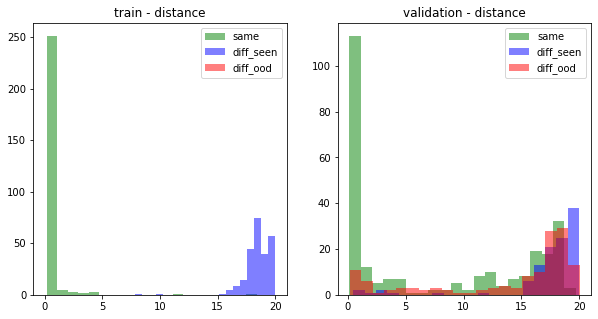

auroc: 0.8191056910569106


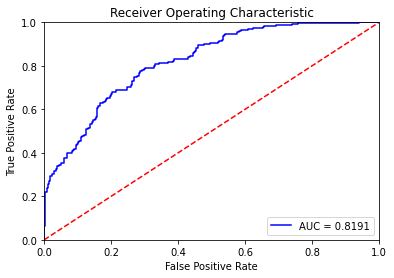

auroc: 0.6346399449847726


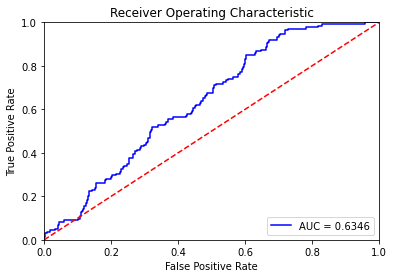

wandb: Agent Starting Run: m3jh677r with config:
wandb: 	learning_rate: 2.025159224450489e-05
wandb: 	loss_margin: 17
wandb: 	weight_decay: 0.0008709241588264325
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 80.23048322225354, Val loss 72.05263358668277
Val auroc diff 0.534910039713008, Val auroc ood 0.5017314366459658
Distance distribution of last training batch:
mean_same = 8.690084457397461, mean_diff_seen = 8.863157272338867, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.625472068786621, mean_diff_seen = 8.85710620880127, mean_diff_ood = 8.764481544494629


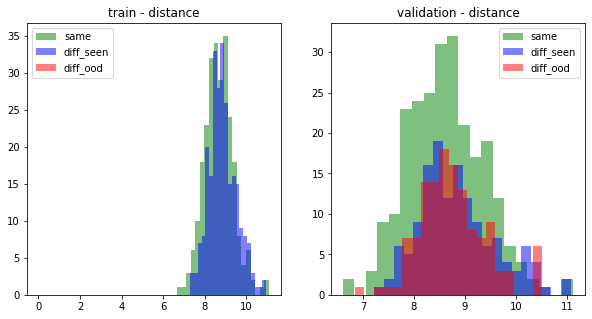


Epoch 1, Train loss 69.37677119933453, Val loss 70.1580790469521
Val auroc diff 0.5926055337725276, Val auroc ood 0.5280166784212313
Distance distribution of last training batch:
mean_same = 8.759467124938965, mean_diff_seen = 9.352991104125977, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.724198341369629, mean_diff_seen = 9.233863830566406, mean_diff_ood = 9.261881828308105

Epoch 2, Train loss 65.13213977617087, Val loss 67.2696822317023
Val auroc diff 0.6374008494213064, Val auroc ood 0.5452359967836049
Distance distribution of last training batch:
mean_same = 8.195121765136719, mean_diff_seen = 9.94328784942627, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.20737361907959, mean_diff_seen = 9.521873474121094, mean_diff_ood = 9.043534278869629

Epoch 3, Train loss 59.81003952026367, Val loss 64.47302205939042
Val auroc diff 0.6782578519893172, Val auroc ood 0.5683752918205789
Distance distribution of last trainin

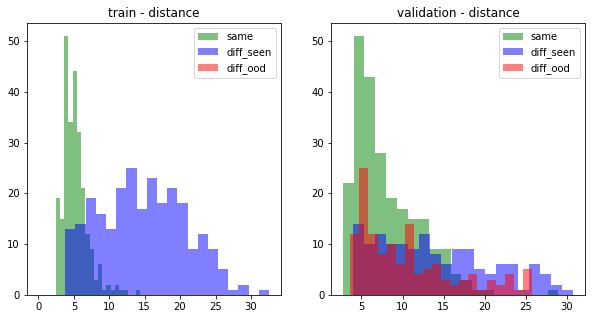

EarlyStopping counter: 5 out of 20, best val auroc ood: 0.5761930456353759

Epoch 11, Train loss 28.447587377017307, Val loss 72.02791555304276
Val auroc diff 0.6801361127690796, Val auroc ood 0.5670635058659146
Distance distribution of last training batch:
mean_same = 5.239624977111816, mean_diff_seen = 15.358972549438477, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.4794921875, mean_diff_seen = 13.086307525634766, mean_diff_ood = 12.440104484558105
EarlyStopping counter: 6 out of 20, best val auroc ood: 0.5761930456353759

Epoch 12, Train loss 26.35994203311881, Val loss 73.9063287032278
Val auroc diff 0.6804937172633236, Val auroc ood 0.5690801367573926
Distance distribution of last training batch:
mean_same = 4.995100975036621, mean_diff_seen = 16.115642547607422, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.360997200012207, mean_diff_seen = 13.239339828491211, mean_diff_ood = 10.670165061950684
EarlyStopping c

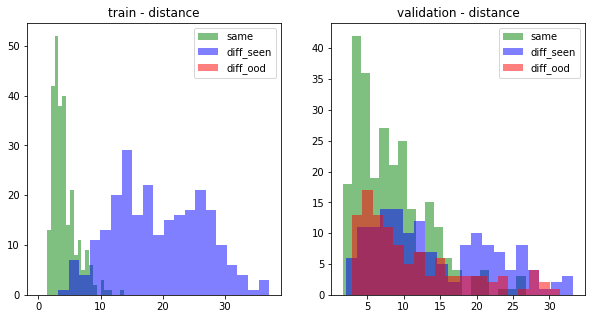

EarlyStopping counter: 15 out of 20, best val auroc ood: 0.5761930456353759

Epoch 21, Train loss 16.58700241993383, Val loss 82.69053930985301
Val auroc diff 0.6798564990199032, Val auroc ood 0.5711493314691752
Distance distribution of last training batch:
mean_same = 4.477031707763672, mean_diff_seen = 18.174203872680664, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.618046760559082, mean_diff_seen = 14.388452529907227, mean_diff_ood = 13.146623611450195
EarlyStopping counter: 16 out of 20, best val auroc ood: 0.5761930456353759

Epoch 22, Train loss 15.914170324187918, Val loss 82.13690105237458
Val auroc diff 0.6751727617624268, Val auroc ood 0.5645265178780299
Distance distribution of last training batch:
mean_same = 4.008579254150391, mean_diff_seen = 18.193334579467773, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 9.633852005004883, mean_diff_seen = 15.949897766113281, mean_diff_ood = 12.104700088500977
EarlySt

Epoch,25
Train Loss,14.35498
Val Loss,81.60719
Val auroc diff,0.67941
Val auroc ood,0.56559
Train mean distance (same),3.8997
Train mean distance (diff_seen),19.49301
Train mean distance (diff_ood),NA
Val mean distance (same),8.73717
Val mean distance (diff_seen),15.08802
Val mean distance (diff_ood),12.45933


Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Train Loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Val Loss,▄▃▂▁▁▁▁▂▂▃▄▄▅▅▅▆▆▇▇▇▇█████
Val auroc diff,▁▄▅▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Val auroc ood,▁▃▅▇██████▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇
Train mean distance (same),██▇▇▆▅▅▄▄▃▃▃▃▂▃▂▂▂▁▂▁▂▁▁▁▁
Train mean distance (diff_seen),▁▁▂▂▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
Val mean distance (same),▅▅▃▂▂▁▂▃▂▂▂▄▄▃▃▄▄▅▃▆▄▄██▄▅
Val mean distance (diff_seen),▁▁▂▂▃▃▃▄▄▅▆▅▅▅▅▆▆█▆▆▆▆██▇▇
Val mean distance (diff_ood),▁▂▁▁▂▃▄▃▅▅▄▇▄▄▄▅▆▇▆▇▅█▆▇▇▇
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


Distance distribution of last training batch:
mean_same = 3.89970326423645, mean_diff_seen = 19.49300765991211, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.73716926574707, mean_diff_seen = 15.08801555633545, mean_diff_ood = 12.459328651428223


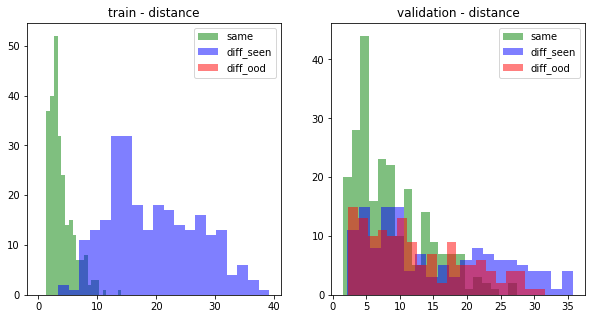

Distance distribution of last training batch:
mean_same = 3.89970326423645, mean_diff_seen = 19.49300765991211, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 8.73716926574707, mean_diff_seen = 15.08801555633545, mean_diff_ood = 12.459328651428223


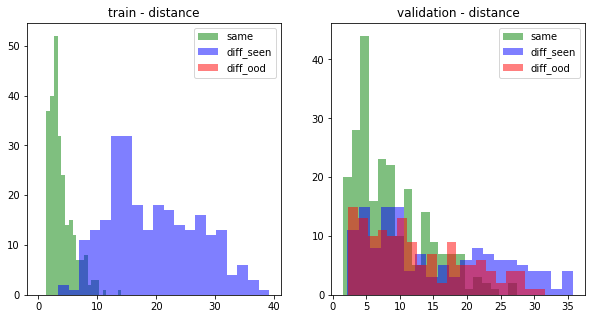

auroc: 0.6700537955768081


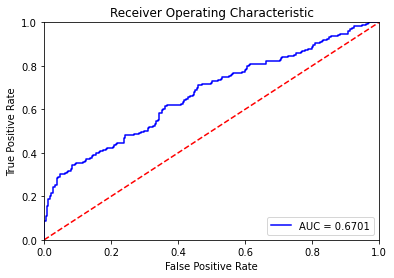

auroc: 0.5662351376720901


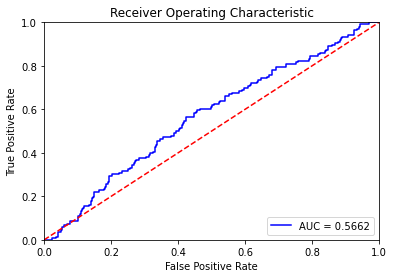

wandb: Agent Starting Run: aeh4i1kl with config:
wandb: 	learning_rate: 0.0009219190817934646
wandb: 	loss_margin: 13
wandb: 	weight_decay: 0.0007968960936262007
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 35.443653008372515, Val loss 34.94609170210989
Val auroc diff 0.7338350558647115, Val auroc ood 0.5851464685315713
Distance distribution of last training batch:
mean_same = 5.327194690704346, mean_diff_seen = 8.538432121276855, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.963625431060791, mean_diff_seen = 8.369900703430176, mean_diff_ood = 6.8831257820129395


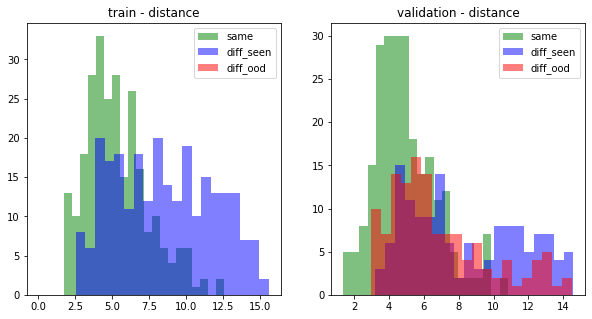


Epoch 1, Train loss 27.429558606491874, Val loss 31.521052410728053
Val auroc diff 0.7896494540801638, Val auroc ood 0.6266433309283764
Distance distribution of last training batch:
mean_same = 4.140521049499512, mean_diff_seen = 8.697748184204102, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.657529354095459, mean_diff_seen = 9.019706726074219, mean_diff_ood = 7.423704624176025

Epoch 2, Train loss 22.84502460047142, Val loss 30.33531419854415
Val auroc diff 0.8094681141545139, Val auroc ood 0.6357371431600292
Distance distribution of last training batch:
mean_same = 3.577669620513916, mean_diff_seen = 9.947770118713379, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.779466152191162, mean_diff_seen = 9.3480863571167, mean_diff_ood = 8.124236106872559

Epoch 3, Train loss 19.02564046800751, Val loss 30.687077572471217
Val auroc diff 0.8082227546595843, Val auroc ood 0.6347887330781322
Distance distribution of last tr

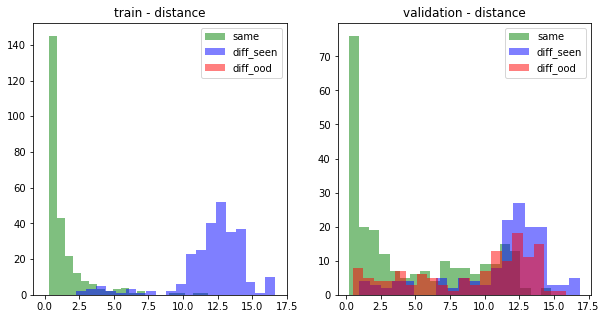

EarlyStopping counter: 2 out of 20, best val auroc ood: 0.653493459503744

Epoch 11, Train loss 5.402019399957559, Val loss 31.95058923018606
Val auroc diff 0.8344361095862873, Val auroc ood 0.6495905886952973
Distance distribution of last training batch:
mean_same = 1.5449808835983276, mean_diff_seen = 13.395541191101074, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.161487579345703, mean_diff_seen = 11.970067977905273, mean_diff_ood = 10.768574714660645
EarlyStopping counter: 3 out of 20, best val auroc ood: 0.653493459503744

Epoch 12, Train loss 4.767149335330295, Val loss 31.013912301314505
Val auroc diff 0.838365968566028, Val auroc ood 0.658674698896948
Distance distribution of last training batch:
mean_same = 1.4178012609481812, mean_diff_seen = 12.365140914916992, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.5435309410095215, mean_diff_seen = 11.069246292114258, mean_diff_ood = 9.252100944519043

Epoch 13, 

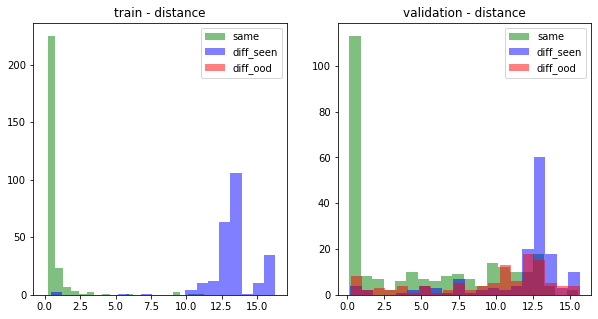

EarlyStopping counter: 2 out of 20, best val auroc ood: 0.661005235171882

Epoch 21, Train loss 2.179217674068569, Val loss 33.43393225418894
Val auroc diff 0.8448793714699341, Val auroc ood 0.6642587017136519
Distance distribution of last training batch:
mean_same = 1.1554882526397705, mean_diff_seen = 13.59150505065918, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.982666969299316, mean_diff_seen = 12.116866111755371, mean_diff_ood = 11.357483863830566

Epoch 22, Train loss 2.1240897759334327, Val loss 33.3363632402922
Val auroc diff 0.8398958731314866, Val auroc ood 0.656601745964622
Distance distribution of last training batch:
mean_same = 0.9680294394493103, mean_diff_seen = 13.081391334533691, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.034271717071533, mean_diff_seen = 12.495636940002441, mean_diff_ood = 10.907326698303223
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6642587017136519

Epoch 23, 

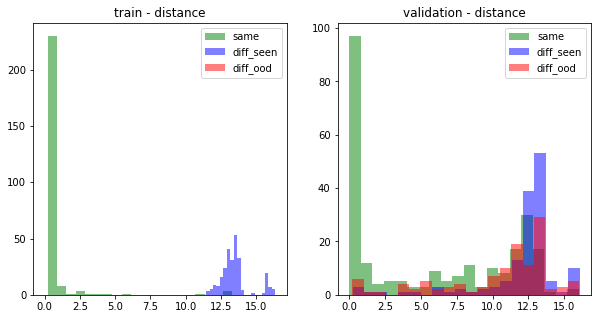

EarlyStopping counter: 9 out of 20, best val auroc ood: 0.6642587017136519

Epoch 31, Train loss 1.3975553908913405, Val loss 32.60118042795282
Val auroc diff 0.8412472891230665, Val auroc ood 0.655013911647827
Distance distribution of last training batch:
mean_same = 0.654857337474823, mean_diff_seen = 13.214946746826172, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.157077789306641, mean_diff_seen = 12.079222679138184, mean_diff_ood = 9.856363296508789
EarlyStopping counter: 10 out of 20, best val auroc ood: 0.6642587017136519

Epoch 32, Train loss 1.5223879900175272, Val loss 32.844853150217155
Val auroc diff 0.8459706024311697, Val auroc ood 0.6565718164645624
Distance distribution of last training batch:
mean_same = 0.6435007452964783, mean_diff_seen = 13.502697944641113, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.872358322143555, mean_diff_seen = 11.874635696411133, mean_diff_ood = 10.46332836151123
EarlySto

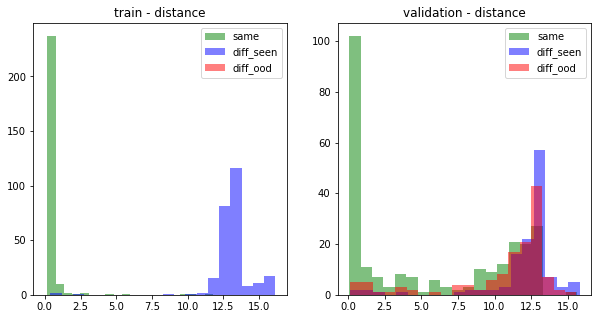

EarlyStopping counter: 19 out of 20, best val auroc ood: 0.6642587017136519

Epoch 41, Train loss 1.2764743521963198, Val loss 34.46015809711657
Val auroc diff 0.8346722181609608, Val auroc ood 0.6522435738304259
Distance distribution of last training batch:
mean_same = 0.6512113213539124, mean_diff_seen = 13.379203796386719, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.177732944488525, mean_diff_seen = 12.088178634643555, mean_diff_ood = 9.672443389892578
EarlyStopping counter: 20 out of 20, best val auroc ood: 0.6642587017136519
Early stopping


Epoch,41
Train Loss,1.27647
Val Loss,34.46016
Val auroc diff,0.83467
Val auroc ood,0.65224
Train mean distance (same),0.65121
Train mean distance (diff_seen),13.3792
Train mean distance (diff_ood),NA
Val mean distance (same),5.17773
Val mean distance (diff_seen),12.08818
Val mean distance (diff_ood),9.67244


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Train Loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▇▃▂▂▃▄▂▁▂▃▂▄▃▄▃▄▂▃▃▅▅▅▄▄▆▅▅▆▅▇▄▅█▆▆▇▇▅█▇
Val auroc diff,▁▄▆▆▅▆▇▇▇▇▇▇▇▇▇▇███▇█████▇█▇█▇██▇▇▇▇█▇▇▇
Val auroc ood,▁▅▅▅▅▆▆▆▇▇▇▇█▇█▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇█▆▇▆▇▇▇▇
Train mean distance (same),█▆▅▆▅▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
Train mean distance (diff_seen),▁▁▃▄▄▅▆▆▆▇▆█▆▇▇▇▇▇▇██▇▇█████▇█▇██████▇██
Val mean distance (same),▅▄▄▂▃▁▃▂▄▄▄▆▃▅▅▄▅▄▃▄▅▅▆▃▅▆▃▆▃█▆▅▄▄▇▅▅▄▄▆
Val mean distance (diff_seen),▁▂▃▃▃▅▄▆▆▇▆▇▆▆▇▆▆▇▆█▇█▇▆█▇▇▆▇▇▇▇█▇▇▇▇▆█▇
Val mean distance (diff_ood),▁▂▃▂▃▄▄▅▅▅▄▇▅▆▆▆▅▇▆▆█▇▅▇▇▆▅▆▆▇▆▇█▆▆▇▇▇▇▅
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██


Distance distribution of last training batch:
mean_same = 0.6512113213539124, mean_diff_seen = 13.379203796386719, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.177732944488525, mean_diff_seen = 12.088178634643555, mean_diff_ood = 9.672443389892578


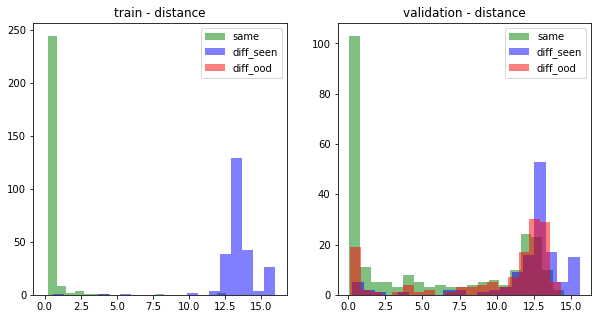

Distance distribution of last training batch:
mean_same = 0.6512113213539124, mean_diff_seen = 13.379203796386719, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.177732944488525, mean_diff_seen = 12.088178634643555, mean_diff_ood = 9.672443389892578


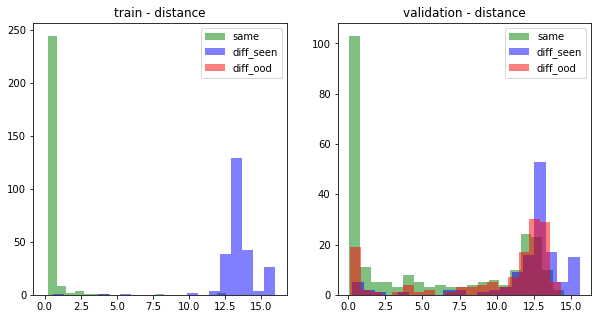

auroc: 0.8050711212506316


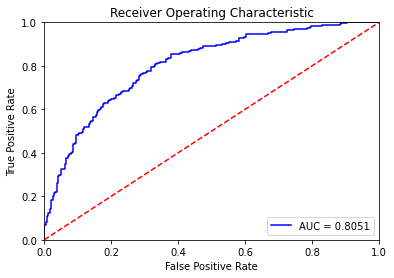

auroc: 0.5832603406326035


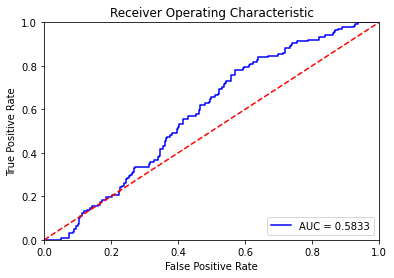

wandb: Agent Starting Run: g71bgyjm with config:
wandb: 	learning_rate: 0.0007668954136412774
wandb: 	loss_margin: 12
wandb: 	weight_decay: 0.0008854109985439915
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 31.42476182131423, Val loss 30.4235570807206
Val auroc diff 0.7227595626856231, Val auroc ood 0.5817611024320135
Distance distribution of last training batch:
mean_same = 4.632870674133301, mean_diff_seen = 7.485074043273926, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.429225921630859, mean_diff_seen = 7.433808326721191, mean_diff_ood = 6.283897876739502


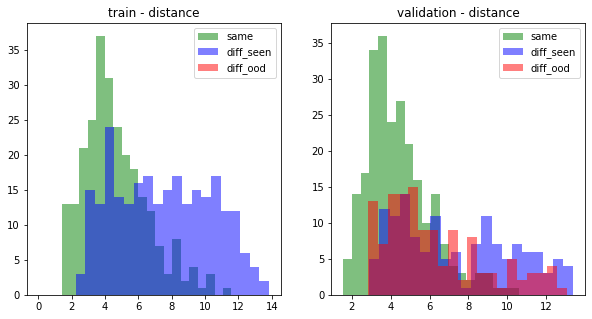


Epoch 1, Train loss 23.82030376945574, Val loss 27.714024995502673
Val auroc diff 0.7759487177601359, Val auroc ood 0.6219410546861981
Distance distribution of last training batch:
mean_same = 3.9820375442504883, mean_diff_seen = 8.127494812011719, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.538356304168701, mean_diff_seen = 8.251945495605469, mean_diff_ood = 7.352248191833496

Epoch 2, Train loss 19.811353565491352, Val loss 27.545997619628906
Val auroc diff 0.7884545951004418, Val auroc ood 0.6284246938391148
Distance distribution of last training batch:
mean_same = 3.419196367263794, mean_diff_seen = 9.187395095825195, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.529481410980225, mean_diff_seen = 8.43925666809082, mean_diff_ood = 7.3816423416137695

Epoch 3, Train loss 16.574779461339578, Val loss 26.9514382011012
Val auroc diff 0.7950506784138213, Val auroc ood 0.6244279876341912
Distance distribution of last

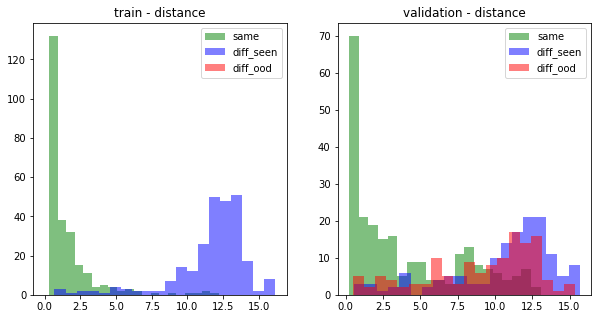

EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6524342608016568

Epoch 11, Train loss 5.002746355902288, Val loss 28.038613168816816
Val auroc diff 0.8187081067073185, Val auroc ood 0.6369584836400369
Distance distribution of last training batch:
mean_same = 1.4261020421981812, mean_diff_seen = 12.079779624938965, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.569005966186523, mean_diff_seen = 10.208158493041992, mean_diff_ood = 9.08924388885498
EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6524342608016568

Epoch 12, Train loss 4.241018838489179, Val loss 27.018254229896947
Val auroc diff 0.832510457138413, Val auroc ood 0.6542330118245083
Distance distribution of last training batch:
mean_same = 1.2535849809646606, mean_diff_seen = 11.648666381835938, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.613582611083984, mean_diff_seen = 10.58150863647461, mean_diff_ood = 8.756839752197266

Epoch 13, 

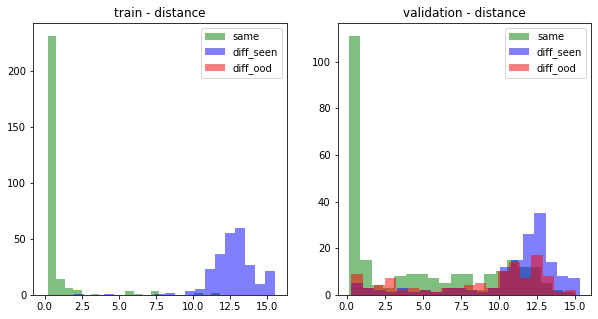

EarlyStopping counter: 7 out of 20, best val auroc ood: 0.6548805625264134

Epoch 21, Train loss 2.093117204523578, Val loss 27.51448751750745
Val auroc diff 0.8364477272847354, Val auroc ood 0.65403972126344
Distance distribution of last training batch:
mean_same = 0.7191367149353027, mean_diff_seen = 11.92910099029541, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.447683811187744, mean_diff_seen = 10.949136734008789, mean_diff_ood = 9.497063636779785
EarlyStopping counter: 8 out of 20, best val auroc ood: 0.6548805625264134

Epoch 22, Train loss 1.7430045789050073, Val loss 30.373084118491725
Val auroc diff 0.8291785593534521, Val auroc ood 0.6502832525058034
Distance distribution of last training batch:
mean_same = 0.8070740699768066, mean_diff_seen = 12.198102951049805, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.210384845733643, mean_diff_seen = 11.374119758605957, mean_diff_ood = 9.719717979431152
EarlyStoppi

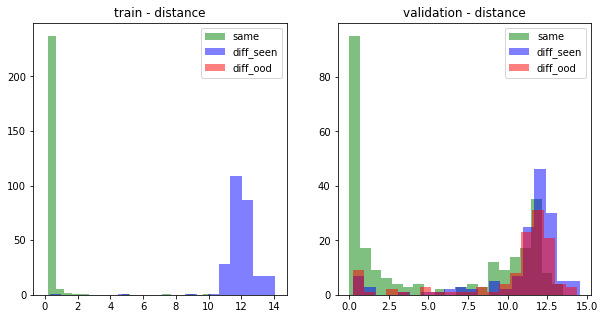


Epoch 31, Train loss 1.0157038855183984, Val loss 30.617895327116315
Val auroc diff 0.832988297262418, Val auroc ood 0.6575031222741492
Distance distribution of last training batch:
mean_same = 0.48323309421539307, mean_diff_seen = 12.5265474319458, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.021174907684326, mean_diff_seen = 11.448149681091309, mean_diff_ood = 9.824495315551758
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6579570534573428

Epoch 32, Train loss 1.102865691037522, Val loss 29.555774287173623
Val auroc diff 0.8196195301922732, Val auroc ood 0.6512506910304878
Distance distribution of last training batch:
mean_same = 0.7021780014038086, mean_diff_seen = 11.941311836242676, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.818726062774658, mean_diff_seen = 10.584090232849121, mean_diff_ood = 9.476069450378418
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6579570534573428

Epoch 33

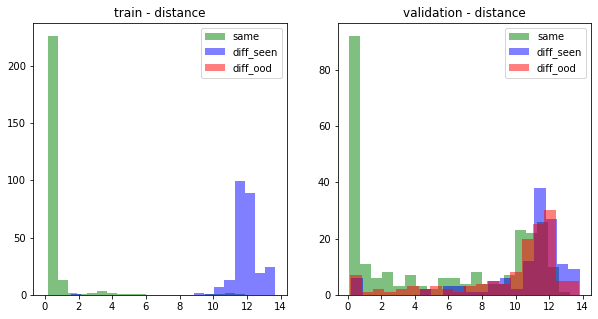

EarlyStopping counter: 10 out of 20, best val auroc ood: 0.6579570534573428

Epoch 41, Train loss 1.0233032356217964, Val loss 29.966878188283818
Val auroc diff 0.8256409378534011, Val auroc ood 0.6490306300918509
Distance distribution of last training batch:
mean_same = 0.5444149374961853, mean_diff_seen = 12.422431945800781, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.786401271820068, mean_diff_seen = 10.824251174926758, mean_diff_ood = 9.189212799072266
EarlyStopping counter: 11 out of 20, best val auroc ood: 0.6579570534573428

Epoch 42, Train loss 0.9667012355069524, Val loss 30.161358381572523
Val auroc diff 0.8321515643875383, Val auroc ood 0.6581228103045182
Distance distribution of last training batch:
mean_same = 0.6357494592666626, mean_diff_seen = 12.176316261291504, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.477235794067383, mean_diff_seen = 10.665253639221191, mean_diff_ood = 9.798742294311523

Epo

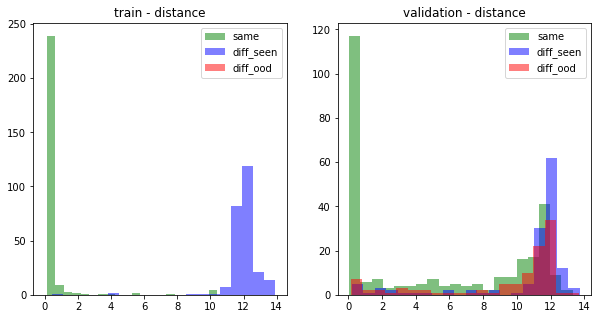

EarlyStopping counter: 8 out of 20, best val auroc ood: 0.6581228103045182

Epoch 51, Train loss 0.747558816652937, Val loss 31.543561734651263
Val auroc diff 0.823424440946884, Val auroc ood 0.6558446319029494
Distance distribution of last training batch:
mean_same = 0.6824840903282166, mean_diff_seen = 12.194790840148926, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.475485801696777, mean_diff_seen = 10.766633987426758, mean_diff_ood = 10.307183265686035
EarlyStopping counter: 9 out of 20, best val auroc ood: 0.6581228103045182

Epoch 52, Train loss 0.7682992625482303, Val loss 30.95160654971474
Val auroc diff 0.8276165839792463, Val auroc ood 0.6549912962896769
Distance distribution of last training batch:
mean_same = 0.6079875230789185, mean_diff_seen = 12.326465606689453, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.3630218505859375, mean_diff_seen = 11.250882148742676, mean_diff_ood = 10.220598220825195
EarlyS

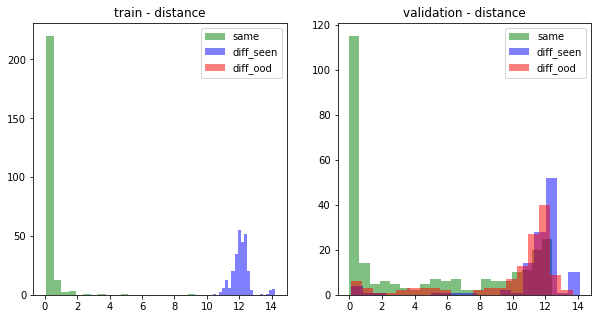

EarlyStopping counter: 18 out of 20, best val auroc ood: 0.6581228103045182

Epoch 61, Train loss 0.6449057799331921, Val loss 31.36922966806512
Val auroc diff 0.8161215370526883, Val auroc ood 0.648756176496735
Distance distribution of last training batch:
mean_same = 0.5129266977310181, mean_diff_seen = 12.174199104309082, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.649013519287109, mean_diff_seen = 11.10034465789795, mean_diff_ood = 9.8107328414917
EarlyStopping counter: 19 out of 20, best val auroc ood: 0.6581228103045182

Epoch 62, Train loss 0.5786060520361379, Val loss 30.463030965704668
Val auroc diff 0.8256332829778439, Val auroc ood 0.6503405159953038
Distance distribution of last training batch:
mean_same = 0.5926805734634399, mean_diff_seen = 12.281570434570312, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.816643238067627, mean_diff_seen = 11.456480979919434, mean_diff_ood = 9.856588363647461
EarlyStop

Epoch,62
Train Loss,0.57861
Val Loss,30.46303
Val auroc diff,0.82563
Val auroc ood,0.65034
Train mean distance (same),0.59268
Train mean distance (diff_seen),12.28157
Train mean distance (diff_ood),NA
Val mean distance (same),4.81664
Val mean distance (diff_seen),11.45648
Val mean distance (diff_ood),9.85659


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Train Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▆▃▂▃▂▂▁▄▂▄▄▄▄▆▆▇▆▅▅▆▇▆▇▇▇▆▆▆▇▇▇▇▆▇██▇█▇█
Val auroc diff,▁▄▆▆▇▇█▇█▇█████▇▇█▇██▇▇▇▇███▇▇▇▇▇█▆█▇▇▇▇
Val auroc ood,▁▅▅▅▆▇▇▆█▇▇█▇▇▇▆██▇███▇▇▇▇▇█▆█▇▇▇█▆▇▇▆▇▇
Train mean distance (same),█▇▆▅▅▄▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▂▃▅▆▆▆▇▇▇▇▇▇█▇▇█▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇██▇▇▇
Val mean distance (same),▄▄▂▄▅▃▃▄▄▄▄▁▅▄▇▇▄▂▄▇▆▃▆▅▃▃▅▄▄█▇▃▇▃▇▆▅▅▄▅
Val mean distance (diff_seen),▁▂▂▄▄▅▆▆▆▆▇▇▇▇▇▆▇▆▇▇█▇▇▇▆▇▇▆▆▆▇▇▆▇▇▇█▆▇▇
Val mean distance (diff_ood),▁▃▂▄▅▆▅▆▅▅▇▇▆▅▇▆█▆▇█▇▆▇▆▇▇▆▇▇▇▆▇▆█▇▇▆▆▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


Distance distribution of last training batch:
mean_same = 0.5926805734634399, mean_diff_seen = 12.281570434570312, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.816643238067627, mean_diff_seen = 11.456480979919434, mean_diff_ood = 9.856588363647461


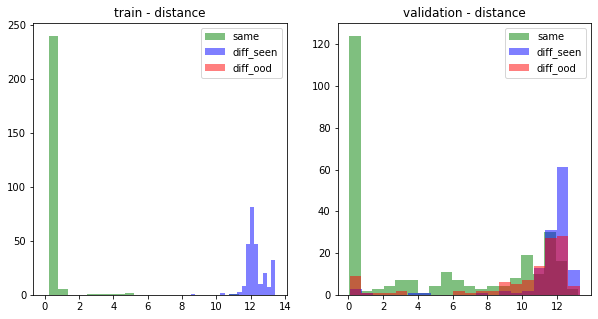

Distance distribution of last training batch:
mean_same = 0.5926805734634399, mean_diff_seen = 12.281570434570312, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.816643238067627, mean_diff_seen = 11.456480979919434, mean_diff_ood = 9.856588363647461


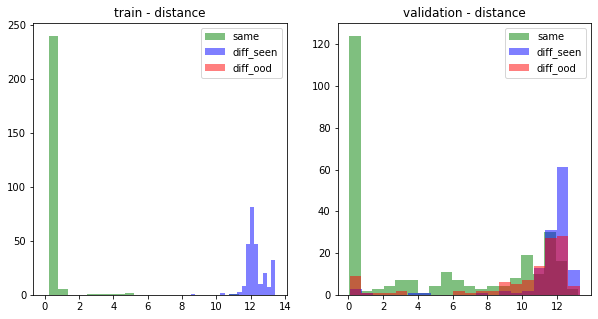

auroc: 0.8476673148474223


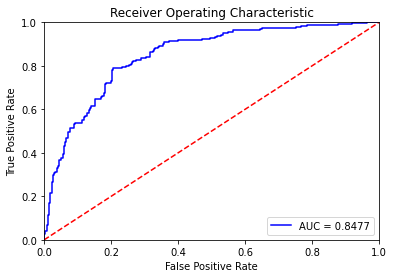

auroc: 0.6354241071428571


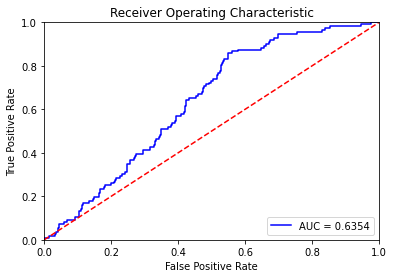

wandb: Agent Starting Run: 8onuuds1 with config:
wandb: 	learning_rate: 0.0004865978509907298
wandb: 	loss_margin: 10
wandb: 	weight_decay: 7.480388564037534e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 23.458605461513873, Val loss 20.82634072554739
Val auroc diff 0.7335169037590937, Val auroc ood 0.5956954149875796
Distance distribution of last training batch:
mean_same = 3.834040403366089, mean_diff_seen = 6.1518049240112305, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.9707651138305664, mean_diff_seen = 6.434327125549316, mean_diff_ood = 5.58720064163208


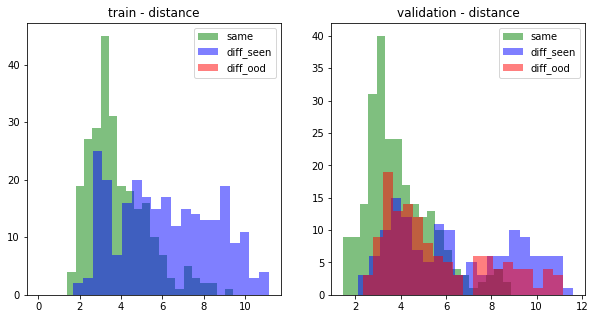


Epoch 1, Train loss 16.95426654815674, Val loss 19.268281836258737
Val auroc diff 0.7739422572018724, Val auroc ood 0.6221897977133994
Distance distribution of last training batch:
mean_same = 3.4739086627960205, mean_diff_seen = 6.758510112762451, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.8707778453826904, mean_diff_seen = 6.691521167755127, mean_diff_ood = 5.9058427810668945

Epoch 2, Train loss 13.970185437153296, Val loss 19.47756616692794
Val auroc diff 0.7779936437113828, Val auroc ood 0.6176358425049085
Distance distribution of last training batch:
mean_same = 3.1680562496185303, mean_diff_seen = 7.926664352416992, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.9049293994903564, mean_diff_seen = 7.322605133056641, mean_diff_ood = 6.202621936798096
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6221897977133994

Epoch 3, Train loss 11.03208640187057, Val loss 19.29026985168457
Val auroc diff 0.78

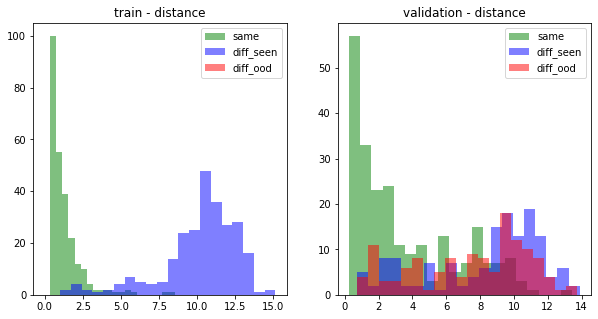

EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6428847525654042

Epoch 11, Train loss 3.4439563308794474, Val loss 19.701153403834294
Val auroc diff 0.8177801938257124, Val auroc ood 0.654146565250242
Distance distribution of last training batch:
mean_same = 1.29910147190094, mean_diff_seen = 10.543558120727539, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.911287546157837, mean_diff_seen = 8.737836837768555, mean_diff_ood = 8.032023429870605

Epoch 12, Train loss 3.089006288764403, Val loss 19.56271663464998
Val auroc diff 0.819781955560966, Val auroc ood 0.6541248661553046
Distance distribution of last training batch:
mean_same = 1.241745948791504, mean_diff_seen = 10.00692367553711, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.6219992637634277, mean_diff_seen = 8.266432762145996, mean_diff_ood = 6.95053768157959
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.654146565250242

Epoch 13, Train 

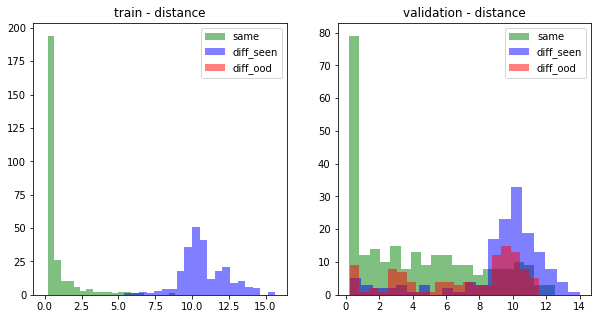

EarlyStopping counter: 9 out of 20, best val auroc ood: 0.654146565250242

Epoch 21, Train loss 1.8895624255396657, Val loss 21.244484550074528
Val auroc diff 0.8063944797561118, Val auroc ood 0.6438615996916848
Distance distribution of last training batch:
mean_same = 0.8835991024971008, mean_diff_seen = 10.146822929382324, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.152721405029297, mean_diff_seen = 8.769373893737793, mean_diff_ood = 7.9374260902404785
EarlyStopping counter: 10 out of 20, best val auroc ood: 0.654146565250242

Epoch 22, Train loss 1.6901807078381175, Val loss 21.548500362195465
Val auroc diff 0.8121881161514956, Val auroc ood 0.6520118125910996
Distance distribution of last training batch:
mean_same = 0.9886504411697388, mean_diff_seen = 10.348343849182129, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.591787338256836, mean_diff_seen = 9.806049346923828, mean_diff_ood = 8.486330032348633
EarlySto

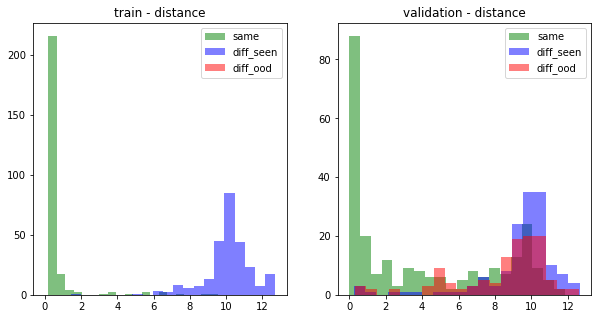

EarlyStopping counter: 19 out of 20, best val auroc ood: 0.654146565250242

Epoch 31, Train loss 1.162042442363562, Val loss 23.444448069522256
Val auroc diff 0.7914771567776615, Val auroc ood 0.6323056473251634
Distance distribution of last training batch:
mean_same = 0.6559879183769226, mean_diff_seen = 10.3351469039917, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.409429550170898, mean_diff_seen = 9.32793140411377, mean_diff_ood = 7.447037696838379
EarlyStopping counter: 20 out of 20, best val auroc ood: 0.654146565250242
Early stopping


Epoch,31
Train Loss,1.16204
Val Loss,23.44445
Val auroc diff,0.79148
Val auroc ood,0.63231
Train mean distance (same),0.65599
Train mean distance (diff_seen),10.33515
Train mean distance (diff_ood),NA
Val mean distance (same),4.40943
Val mean distance (diff_seen),9.32793
Val mean distance (diff_ood),7.44704


Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Train Loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▄▁▁▁▁▂▂▁▃▂▃▂▂▄▃▆▃▅▄▅▅▄▅▆█▇▆▅██▅█
Val auroc diff,▁▄▅▅▆▆▆▇▇▇▆██▇▇▇▇▇▇▇█▇▇▇▆▆▇▇▇▇▇▆
Val auroc ood,▁▄▄▄▅▆▅▆▆▇▆██▆▇▇▇▇▇▆▇▇█▆▇▆▇▇▆▇▇▅
Train mean distance (same),█▇▇▆▅▄▄▄▃▃▂▂▂▂▃▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇████▇▇▇
Val mean distance (same),▄▄▄▁▂▁▃▂▅▃▂▄▃▄▄▅▆▄▃▅▅▆█▇▆▅▆▄▆▇▅▇
Val mean distance (diff_seen),▁▂▃▂▃▅▄▅▆▆▅▆▅▅▆▆▅▆▆▆▇▆█▇▇▇▆▆▆█▇▇
Val mean distance (diff_ood),▁▂▂▁▂▄▅▄▅▅▅▇▄▅▅▇▅█▆▆▄▇█▅▇██▆▇▇█▅
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.6559879183769226, mean_diff_seen = 10.3351469039917, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.409429550170898, mean_diff_seen = 9.32793140411377, mean_diff_ood = 7.447037696838379


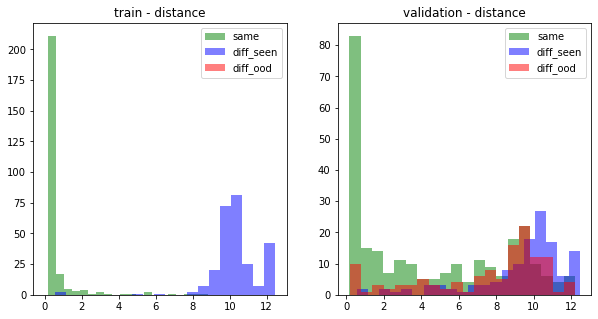

Distance distribution of last training batch:
mean_same = 0.6559879183769226, mean_diff_seen = 10.3351469039917, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.409429550170898, mean_diff_seen = 9.32793140411377, mean_diff_ood = 7.447037696838379


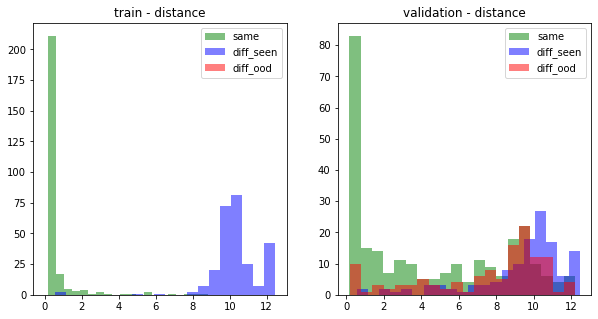

auroc: 0.7853008994151511


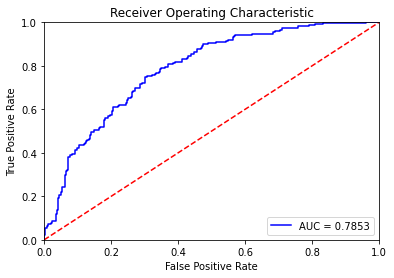

auroc: 0.5840909565907999


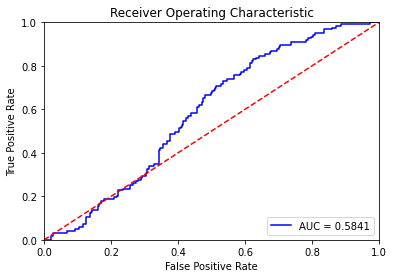

wandb: Agent Starting Run: cqgtn1vt with config:
wandb: 	learning_rate: 0.000987623758080835
wandb: 	loss_margin: 13
wandb: 	weight_decay: 0.0005802432422271941
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 35.683372399241655, Val loss 34.13068530434057
Val auroc diff 0.7487417733038386, Val auroc ood 0.600834398974814
Distance distribution of last training batch:
mean_same = 4.913601875305176, mean_diff_seen = 8.43284797668457, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.047981262207031, mean_diff_seen = 8.510595321655273, mean_diff_ood = 7.134748935699463


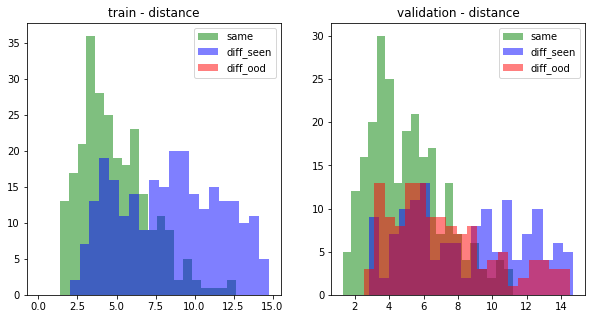


Epoch 1, Train loss 27.847553803748692, Val loss 31.71456527709961
Val auroc diff 0.7866896294061706, Val auroc ood 0.6244074584739603
Distance distribution of last training batch:
mean_same = 4.243359088897705, mean_diff_seen = 9.057110786437988, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.8199615478515625, mean_diff_seen = 8.789896965026855, mean_diff_ood = 7.626975059509277

Epoch 2, Train loss 23.29198988688361, Val loss 31.307193454943206
Val auroc diff 0.8016792935803936, Val auroc ood 0.6328164489510063
Distance distribution of last training batch:
mean_same = 3.9142444133758545, mean_diff_seen = 10.206954002380371, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.7575249671936035, mean_diff_seen = 9.70514965057373, mean_diff_ood = 8.457951545715332

Epoch 3, Train loss 19.3692524015289, Val loss 30.853140780800267
Val auroc diff 0.8072029729701742, Val auroc ood 0.6431300767297038
Distance distribution of las

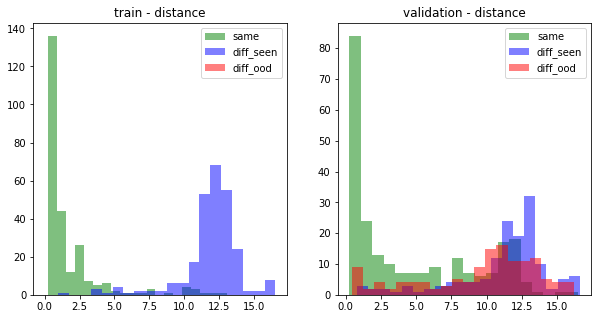

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6664224585722328

Epoch 11, Train loss 5.216318012512836, Val loss 31.138668562236585
Val auroc diff 0.8394009486073719, Val auroc ood 0.6479056578533399
Distance distribution of last training batch:
mean_same = 1.637826681137085, mean_diff_seen = 12.905553817749023, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.651392459869385, mean_diff_seen = 11.520726203918457, mean_diff_ood = 10.327908515930176
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6664224585722328

Epoch 12, Train loss 4.239250718932791, Val loss 31.403257871928968
Val auroc diff 0.8378219353060721, Val auroc ood 0.6528029043067092
Distance distribution of last training batch:
mean_same = 1.2336137294769287, mean_diff_seen = 12.352288246154785, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.433087348937988, mean_diff_seen = 11.19245719909668, mean_diff_ood = 8.927388191223145
EarlyStop

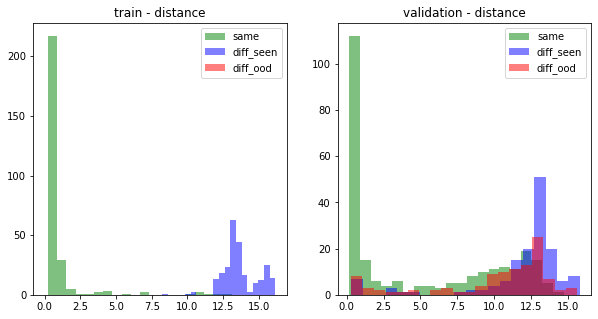

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6684885483496937

Epoch 21, Train loss 2.234277758401694, Val loss 31.847413615176553
Val auroc diff 0.8456740794750273, Val auroc ood 0.6646522505933709
Distance distribution of last training batch:
mean_same = 0.9514735341072083, mean_diff_seen = 13.034634590148926, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.5516862869262695, mean_diff_seen = 11.969697952270508, mean_diff_ood = 10.265300750732422
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6684885483496937

Epoch 22, Train loss 1.9588935602571547, Val loss 32.08762249193693
Val auroc diff 0.8466585739968477, Val auroc ood 0.6669621126576811
Distance distribution of last training batch:
mean_same = 0.8183059692382812, mean_diff_seen = 12.851935386657715, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.452162265777588, mean_diff_seen = 12.297418594360352, mean_diff_ood = 10.830913543701172
Early

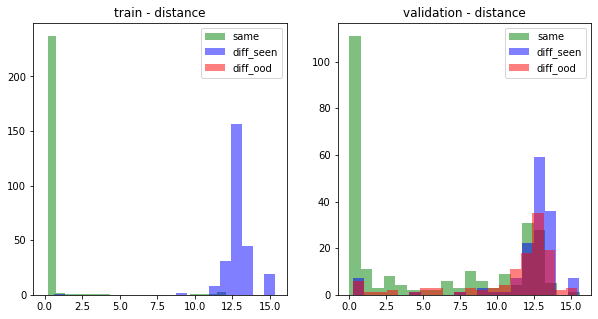

EarlyStopping counter: 13 out of 20, best val auroc ood: 0.6684885483496937

Epoch 31, Train loss 1.4997011718061781, Val loss 34.20017764442846
Val auroc diff 0.8379048816327193, Val auroc ood 0.6566232009525222
Distance distribution of last training batch:
mean_same = 0.7292114496231079, mean_diff_seen = 13.448452949523926, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.90020227432251, mean_diff_seen = 11.886192321777344, mean_diff_ood = 10.753711700439453
EarlyStopping counter: 14 out of 20, best val auroc ood: 0.6684885483496937

Epoch 32, Train loss 1.6692264135350887, Val loss 35.10065179122122
Val auroc diff 0.8272741194312214, Val auroc ood 0.6512096458675317
Distance distribution of last training batch:
mean_same = 0.7817440629005432, mean_diff_seen = 13.22565746307373, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.85778284072876, mean_diff_seen = 11.165099143981934, mean_diff_ood = 10.021941184997559
EarlySt

Epoch,37
Train Loss,1.14137
Val Loss,33.79113
Val auroc diff,0.84306
Val auroc ood,0.66458
Train mean distance (same),0.65077
Train mean distance (diff_seen),13.17957
Train mean distance (diff_ood),NA
Val mean distance (same),4.66685
Val mean distance (diff_seen),11.84759
Val mean distance (diff_ood),10.14994


Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▆▃▃▂▂▁▁▁▂▁▂▃▃▃▃▄▅▃▆▃▇▄▄▅█▆▅▄▇▅▇▆▇▇█▆▇▆
Val auroc diff,▁▄▅▅▆▇▇▇▇█▇▇▇▇█▇▇█▇█▇██▇▆▇▇█▇█▇▇▇▇▆▇▇█
Val auroc ood,▁▃▄▅▄▆▆█▇▇▇▆▆▆█▇▇█▇█▆██▆▇▇█▇██▆▇▆▇▇▇▇█
Train mean distance (same),█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▂▃▃▅▄▆▆▆▆▆▇▆▆▇▇█▇▇▇█▇▇▇▇█▇███▇█▇▇▇▇▇▇
Val mean distance (same),▆▅▅▃▃▁▅▃▄▅▄▄▃▃▃▃█▅▄▅▆▄▃▇▇▄▇▃▅▃▇▅▅▅█▇▅▄
Val mean distance (diff_seen),▁▂▃▂▄▄▄▆▅▇▆▆▆▅▇▇▇▆▇▇▇▇█▇▇█▇▇█▇█▇▆▆▇█▇▇
Val mean distance (diff_ood),▁▂▃▂▄▄▅▆▅▅▅▆▄▄▆▇▅▇▆▆▆▆▇▅▇▇▇▆▇▆▇▇▆▇▇▇█▆
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.6507703065872192, mean_diff_seen = 13.179574966430664, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.666850566864014, mean_diff_seen = 11.847589492797852, mean_diff_ood = 10.149935722351074


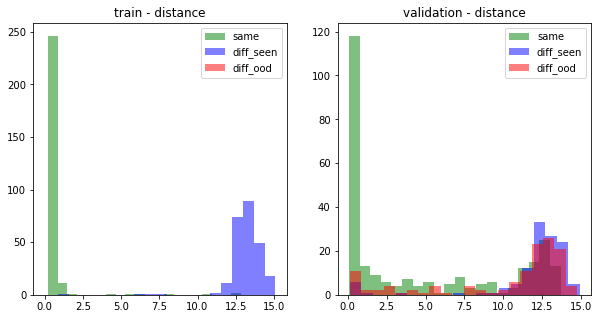

Distance distribution of last training batch:
mean_same = 0.6507703065872192, mean_diff_seen = 13.179574966430664, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.666850566864014, mean_diff_seen = 11.847589492797852, mean_diff_ood = 10.149935722351074


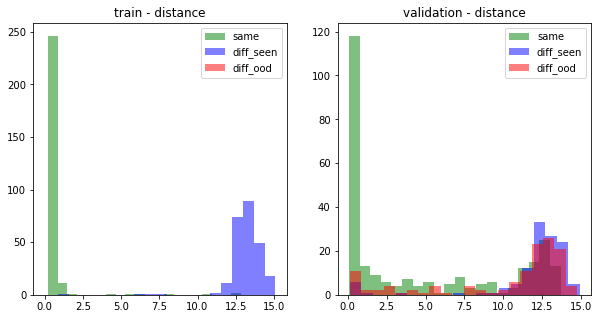

auroc: 0.8258492179863147


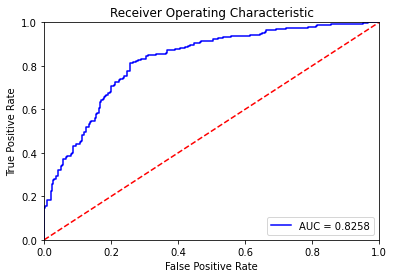

auroc: 0.663818359375


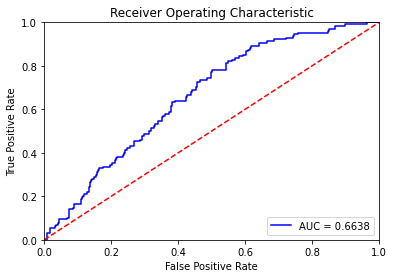

wandb: Agent Starting Run: 6w533332 with config:
wandb: 	learning_rate: 0.0009169214061090893
wandb: 	loss_margin: 10
wandb: 	weight_decay: 9.97653173955823e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 0, Train loss 22.33013896352237, Val loss 20.492091429860967
Val auroc diff 0.7409393961872891, Val auroc ood 0.5956812302954282
Distance distribution of last training batch:
mean_same = 3.8459372520446777, mean_diff_seen = 6.455523490905762, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.95469331741333, mean_diff_seen = 6.4414191246032715, mean_diff_ood = 5.4892144203186035


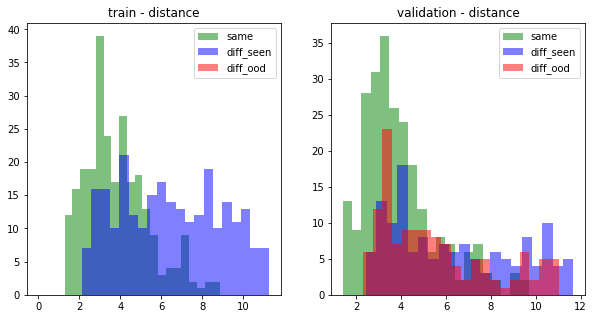


Epoch 1, Train loss 16.790380704034234, Val loss 18.87522978531687
Val auroc diff 0.7851524327988196, Val auroc ood 0.630082723311959
Distance distribution of last training batch:
mean_same = 3.1944570541381836, mean_diff_seen = 6.626588344573975, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.678553342819214, mean_diff_seen = 6.830738067626953, mean_diff_ood = 5.953656196594238

Epoch 2, Train loss 14.1884628374552, Val loss 18.519454052573757
Val auroc diff 0.795360391166627, Val auroc ood 0.6291749134719811
Distance distribution of last training batch:
mean_same = 2.967287302017212, mean_diff_seen = 7.478598594665527, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.8208658695220947, mean_diff_seen = 6.9269633293151855, mean_diff_ood = 6.212347030639648
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.630082723311959

Epoch 3, Train loss 12.009199073634196, Val loss 18.557430166947213
Val auroc diff 0.793610

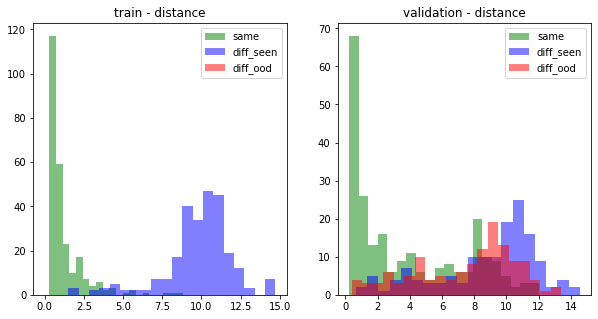

EarlyStopping counter: 3 out of 20, best val auroc ood: 0.6485292023999949

Epoch 11, Train loss 3.249637407125886, Val loss 18.369753486231755
Val auroc diff 0.8332469583516197, Val auroc ood 0.6423284572806134
Distance distribution of last training batch:
mean_same = 1.1914857625961304, mean_diff_seen = 10.078851699829102, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 3.9306156635284424, mean_diff_seen = 8.823765754699707, mean_diff_ood = 7.772067546844482
EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6485292023999949

Epoch 12, Train loss 2.878270725614017, Val loss 19.84750566984478
Val auroc diff 0.8204864598232853, Val auroc ood 0.6427900963231318
Distance distribution of last training batch:
mean_same = 1.2029409408569336, mean_diff_seen = 10.091768264770508, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.012848377227783, mean_diff_seen = 8.648008346557617, mean_diff_ood = 6.9491496086120605
EarlyStop

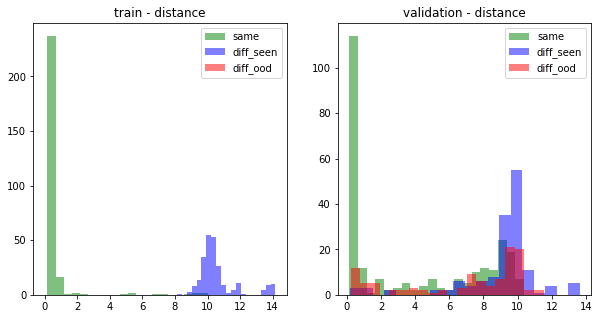


Epoch 21, Train loss 1.2980071846971806, Val loss 21.811165558664424
Val auroc diff 0.8084348777124379, Val auroc ood 0.6385915098072312
Distance distribution of last training batch:
mean_same = 0.7053562998771667, mean_diff_seen = 10.305251121520996, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.11095666885376, mean_diff_seen = 9.303031921386719, mean_diff_ood = 7.779985427856445
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.652112000295602

Epoch 22, Train loss 1.2483437617415005, Val loss 21.103717402407998
Val auroc diff 0.8216586236619843, Val auroc ood 0.6505972933274549
Distance distribution of last training batch:
mean_same = 0.8271871209144592, mean_diff_seen = 10.1345853805542, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.1828203201293945, mean_diff_seen = 9.589457511901855, mean_diff_ood = 7.854677200317383
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.652112000295602

Epoch 23, T

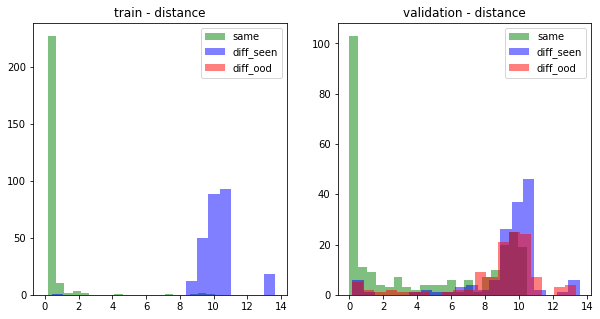

EarlyStopping counter: 4 out of 20, best val auroc ood: 0.6586284113874018

Epoch 31, Train loss 0.9939721481701762, Val loss 21.061492417988024
Val auroc diff 0.8264982968414257, Val auroc ood 0.6509358467781359
Distance distribution of last training batch:
mean_same = 0.5934651494026184, mean_diff_seen = 10.227669715881348, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.010866165161133, mean_diff_seen = 9.537219047546387, mean_diff_ood = 8.23544692993164
EarlyStopping counter: 5 out of 20, best val auroc ood: 0.6586284113874018

Epoch 32, Train loss 1.0096329920685168, Val loss 21.006390822561162
Val auroc diff 0.8294371064388015, Val auroc ood 0.6489523313963294
Distance distribution of last training batch:
mean_same = 0.5089896321296692, mean_diff_seen = 10.335236549377441, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.0134406089782715, mean_diff_seen = 9.2760648727417, mean_diff_ood = 7.650460720062256
EarlyStopp

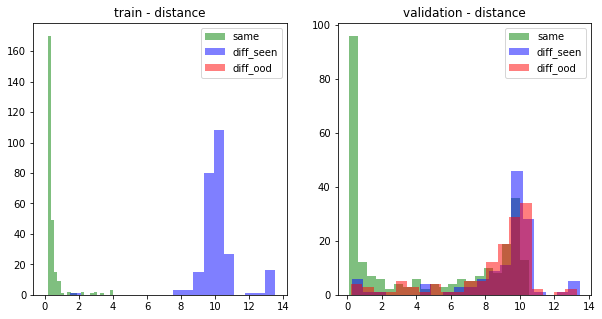

EarlyStopping counter: 14 out of 20, best val auroc ood: 0.6586284113874018

Epoch 41, Train loss 0.7276762445870134, Val loss 21.79190525255705
Val auroc diff 0.8156300939683611, Val auroc ood 0.6441375166437228
Distance distribution of last training batch:
mean_same = 0.604526162147522, mean_diff_seen = 10.175456047058105, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.249860763549805, mean_diff_seen = 9.209074974060059, mean_diff_ood = 7.75087308883667
EarlyStopping counter: 15 out of 20, best val auroc ood: 0.6586284113874018

Epoch 42, Train loss 0.5764113600106583, Val loss 21.823217693128083
Val auroc diff 0.8234038690599472, Val auroc ood 0.6476540039273607
Distance distribution of last training batch:
mean_same = 0.3940863013267517, mean_diff_seen = 10.350116729736328, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.136341571807861, mean_diff_seen = 8.941662788391113, mean_diff_ood = 7.723339557647705
EarlyStop

Epoch,46
Train Loss,0.43415
Val Loss,21.95129
Val auroc diff,0.82745
Val auroc ood,0.65512
Train mean distance (same),0.30883
Train mean distance (diff_seen),10.5188
Train mean distance (diff_ood),NA
Val mean distance (same),4.38317
Val mean distance (diff_seen),9.4431
Val mean distance (diff_ood),8.47013


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▆▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▅▂▂▂▂▂▁▂▂▂▂▄▃▄▅▄▅▅▇▆▄▅▅▇█▆▆▆▇█▆▇█▆▆▇▇▇█▇
Val auroc diff,▁▄▅▅▆▇█▇▇██▇█▇▇▇▇█▆▇██▇▆▆██▇▇▇█▇▇▇█▇▇▇▆█
Val auroc ood,▁▅▅▄▅▆▇▆▇▇▆▇▇▇▆▇▇█▆▇▇█▆▆█▇▇█▇█▇▇▇▆█▇▇███
Train mean distance (same),█▇▆▆▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁
Train mean distance (diff_seen),▁▁▃▃▅▄▆▆▇▇▇▇▇▇▇▇▇██▇▇▇████▇▇███▇█▇▇▇████
Val mean distance (same),▆▄▅▃▃▁▂▅▄▅▆▆▅▃▆▄▅▅▆▇▆▆▆▄▇▅▆▆▅█▆▆▇▅█▇▇▆▅█
Val mean distance (diff_seen),▁▂▂▂▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇█▇▇▇▇▆█▇█▇▇█▆▇▇▇▇▆▇▇▇
Val mean distance (diff_ood),▁▂▃▁▃▄▅▅▅▅▆▄▆▆▆▆▆▄▆▆▅▆▇▇▆▇█▇▇▇▇█▇▇▇▆▆█▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.30883482098579407, mean_diff_seen = 10.51879596710205, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.383169651031494, mean_diff_seen = 9.443096160888672, mean_diff_ood = 8.470128059387207


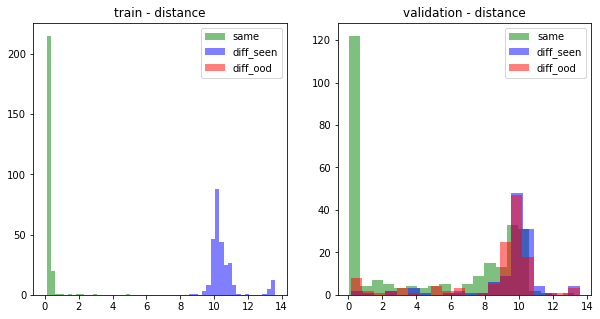

Distance distribution of last training batch:
mean_same = 0.30883482098579407, mean_diff_seen = 10.51879596710205, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.383169651031494, mean_diff_seen = 9.443096160888672, mean_diff_ood = 8.470128059387207


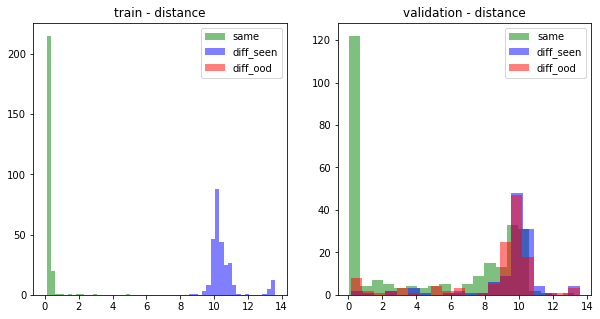

auroc: 0.8085545632493271


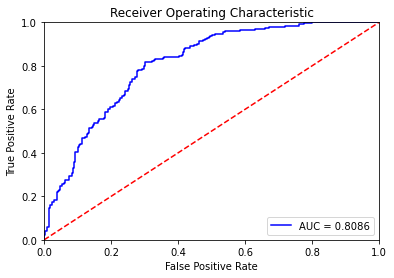

auroc: 0.6432968606196953


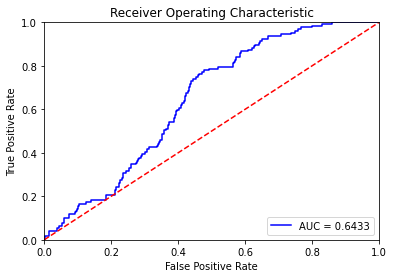

In [12]:
sweep_config = {
    "project": 'Siamese_without_OE - Sweep',
    "name" : "Siamese_without_OE - Sweep",
    "method" : "random",
    "parameters" : {"learning_rate" :{"min": 1e-5,"max": 1e-3},
                    "loss_margin": {"min": 2, "max": 20},
                    "weight_decay": {"min": 1e-5, "max":1e-3}},
    "metric": {"name": "Val auroc ood", "goal": "maximize"},

  }

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train, count=10)

### class rotation


Epoch 0, Train loss 54.4369664536309, Val loss 54.015987597013776
Val auroc diff 0.7864849391307436, Val auroc ood 0.6085726571579122
Distance distribution of last training batch:
mean_same = 5.983487606048584, mean_diff_seen = 12.130122184753418, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 6.53687047958374, mean_diff_seen = 12.178275108337402, mean_diff_ood = 9.805098533630371


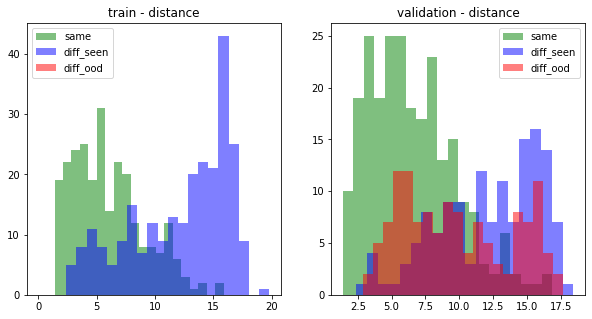


Epoch 1, Train loss 36.53157656954736, Val loss 46.25369322927374
Val auroc diff 0.8463852917410433, Val auroc ood 0.6489487433424578
Distance distribution of last training batch:
mean_same = 4.941579818725586, mean_diff_seen = 13.435476303100586, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.596675872802734, mean_diff_seen = 12.156390190124512, mean_diff_ood = 10.555716514587402

Epoch 2, Train loss 25.739234943979795, Val loss 44.498429348594264
Val auroc diff 0.8607458600432994, Val auroc ood 0.654800458325016
Distance distribution of last training batch:
mean_same = 4.342767238616943, mean_diff_seen = 15.052741050720215, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.138758182525635, mean_diff_seen = 14.339134216308594, mean_diff_ood = 11.230324745178223

Epoch 3, Train loss 17.41391964548642, Val loss 43.06087955675627
Val auroc diff 0.8732638741390778, Val auroc ood 0.6762640891844784
Distance distribution of l

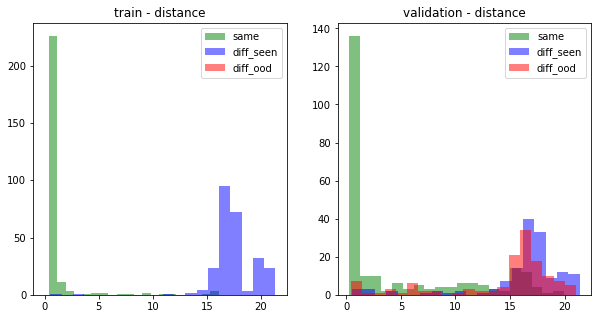


Epoch 11, Train loss 3.1393836343411317, Val loss 42.37455849898489
Val auroc diff 0.8959257764375391, Val auroc ood 0.6857263205319215
Distance distribution of last training batch:
mean_same = 0.8950356841087341, mean_diff_seen = 17.423992156982422, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.840818405151367, mean_diff_seen = 16.665910720825195, mean_diff_ood = 13.805756568908691
EarlyStopping counter: 1 out of 20, best val auroc ood: 0.6951950001614483

Epoch 12, Train loss 2.3571974487648797, Val loss 42.219789806165196
Val auroc diff 0.8986258415587138, Val auroc ood 0.6896985126239867
Distance distribution of last training batch:
mean_same = 0.993527889251709, mean_diff_seen = 17.77393913269043, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.629491806030273, mean_diff_seen = 16.2884578704834, mean_diff_ood = 14.379222869873047
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.6951950001614483

Epoch 13

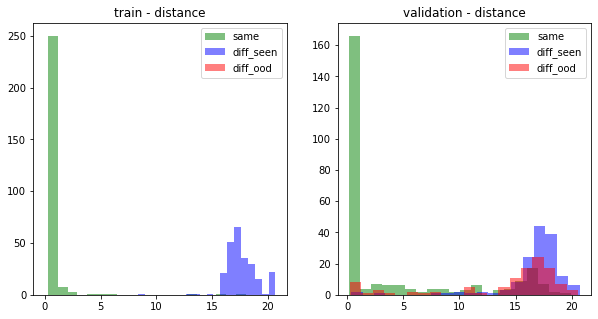

EarlyStopping counter: 5 out of 20, best val auroc ood: 0.6958249187924417

Epoch 21, Train loss 1.8918615871483517, Val loss 44.36962207994963
Val auroc diff 0.8838559283974491, Val auroc ood 0.6770164350323798
Distance distribution of last training batch:
mean_same = 0.7470773458480835, mean_diff_seen = 17.233314514160156, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.381336688995361, mean_diff_seen = 16.350618362426758, mean_diff_ood = 13.566155433654785
EarlyStopping counter: 6 out of 20, best val auroc ood: 0.6958249187924417

Epoch 22, Train loss 1.7146486255925955, Val loss 41.81972543816818
Val auroc diff 0.898488983659832, Val auroc ood 0.6882529219377014
Distance distribution of last training batch:
mean_same = 0.5407199263572693, mean_diff_seen = 17.459226608276367, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.274397373199463, mean_diff_seen = 16.461814880371094, mean_diff_ood = 13.877303123474121
EarlySt

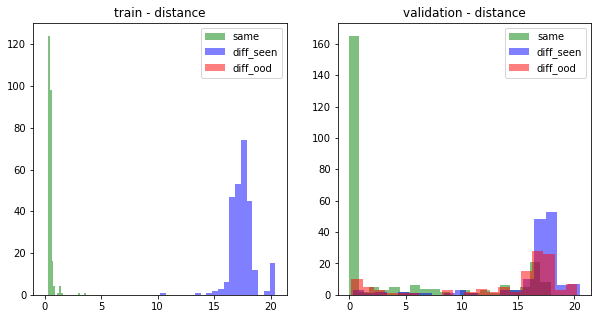

EarlyStopping counter: 1 out of 20, best val auroc ood: 0.709563456294991

Epoch 31, Train loss 1.0409990076705353, Val loss 43.53858405665348
Val auroc diff 0.8907333574093526, Val auroc ood 0.6945220261735877
Distance distribution of last training batch:
mean_same = 0.7803903818130493, mean_diff_seen = 17.490026473999023, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.523480415344238, mean_diff_seen = 16.934730529785156, mean_diff_ood = 14.411931991577148
EarlyStopping counter: 2 out of 20, best val auroc ood: 0.709563456294991

Epoch 32, Train loss 1.4751579225370564, Val loss 42.720247770610605
Val auroc diff 0.9002424373122423, Val auroc ood 0.6970282793545655
Distance distribution of last training batch:
mean_same = 0.48957493901252747, mean_diff_seen = 18.00311279296875, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.461109638214111, mean_diff_seen = 16.66195297241211, mean_diff_ood = 14.95023250579834
EarlyStop

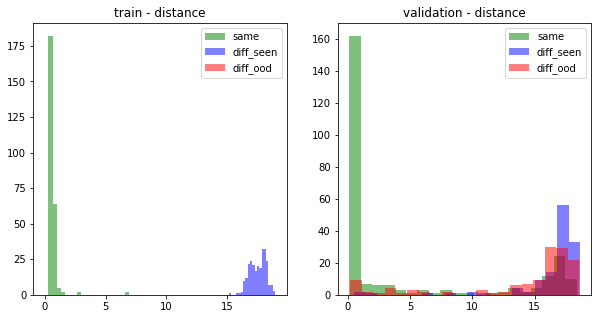

EarlyStopping counter: 11 out of 20, best val auroc ood: 0.709563456294991

Epoch 41, Train loss 0.9652030097762334, Val loss 41.86650125603927
Val auroc diff 0.8939752084821964, Val auroc ood 0.6912200412990004
Distance distribution of last training batch:
mean_same = 0.5609552264213562, mean_diff_seen = 17.487958908081055, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.956708908081055, mean_diff_seen = 16.633636474609375, mean_diff_ood = 14.906229972839355
EarlyStopping counter: 12 out of 20, best val auroc ood: 0.709563456294991

Epoch 42, Train loss 0.6344908483556866, Val loss 43.445866434197676
Val auroc diff 0.8946568162086628, Val auroc ood 0.6817118220466974
Distance distribution of last training batch:
mean_same = 0.3871295750141144, mean_diff_seen = 17.5352783203125, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 5.071386337280273, mean_diff_seen = 16.48379135131836, mean_diff_ood = 13.625288009643555
EarlySto

Epoch,49
Train Loss,1.09532
Val Loss,44.24814
Val auroc diff,0.8903
Val auroc ood,0.69506
Train mean distance (same),0.49904
Train mean distance (diff_seen),17.68736
Train mean distance (diff_ood),NA
Val mean distance (same),4.8245
Val mean distance (diff_seen),16.39058
Val mean distance (diff_ood),14.18936


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,█▄▃▂▁▁▁▁▁▂▂▂▁▃▂▂▁▃▂▂▃▂▁▃▂▂▂▃▃▂▂▃▁▂▂▂▂▂▃▃
Val auroc diff,▁▅▅▆▇██▇███▇█▇█▇█▇█▇▇▇█▇█▇█▇▇▇▇▇▇▇▇█▇▇█▇
Val auroc ood,▁▄▅▆▇▇▇▆█▇▇▇█▇▇▇▇▆▇▇▇▇█▆███▇▇▇██▇▇▇█▇▇▇█
Train mean distance (same),█▇▆▄▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train mean distance (diff_seen),▁▃▄▅▇▇█▇▇▇█▇███▇█▇▇▇▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇▇███
Val mean distance (same),█▆▄▄▂▃▃▄▃▄▃▄▄▃▂▃▂▂▂▄▅▃▁▃▁▃▃▃▃▁▃▄▃▄▄▂▃▃▁▄
Val mean distance (diff_seen),▁▁▄▅▆▇▇▆▇▇▇▇██▇▇█▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇█▆█▇
Val mean distance (diff_ood),▁▂▃▄▅▆▇▅▇▆▇▇▇▇▇▇▇▆▇▇▇▆▆▇▆▇██▇▆▇▆▇█▆▇▇▅▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Distance distribution of last training batch:
mean_same = 0.49904346466064453, mean_diff_seen = 17.687358856201172, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.824495792388916, mean_diff_seen = 16.390581130981445, mean_diff_ood = 14.189362525939941


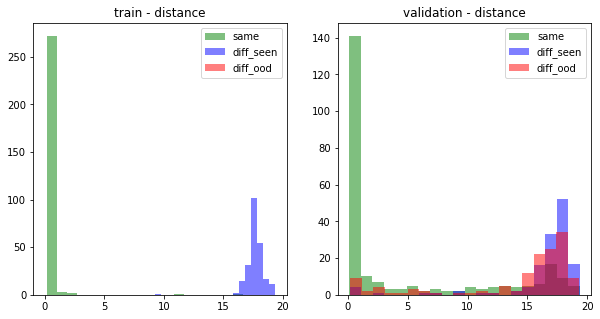

Distance distribution of last training batch:
mean_same = 0.49904346466064453, mean_diff_seen = 17.687358856201172, mean_diff_ood = NA
Distance distribution of last validation batch:
mean_same = 4.824495792388916, mean_diff_seen = 16.390581130981445, mean_diff_ood = 14.189362525939941


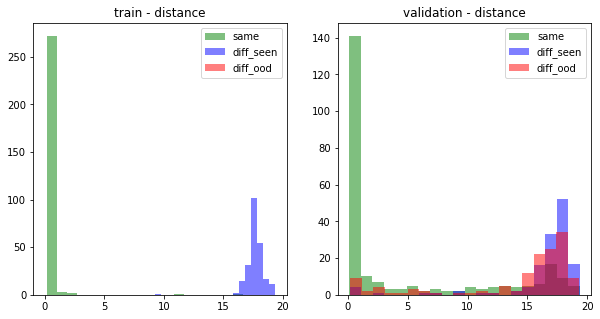

auroc: 0.8743566176470589


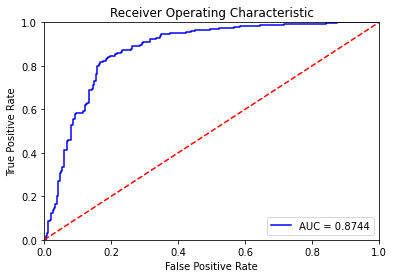

auroc: 0.6659854014598541


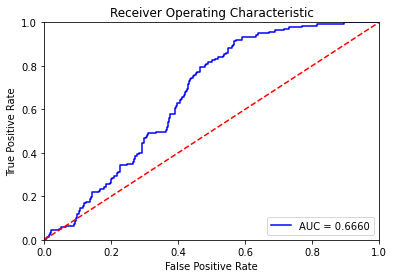

Siamese_ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [10]:
train()

### Testing - use mean class distance as ood score

In [5]:
model = Siamese_ResNet(BasicBlock, [2, 2, 2, 2]).cuda()                                                  #siamese model
#model.load_state_dict(torch.load("./stat_dict/siamese_without_oe_best.pth"))  
model.load_state_dict(torch.load("./stat_dict/siamese_without_oe_best_rotation.pth"))  
train_class_center = torch.load('./stat_dict/train_class_center_siamese_without_oe_best_rotation.pt')

test set distance distribution for all test pairs

mean_same = 2.5239346027374268, mean_diff_seen = 15.806739807128906, mean_diff_ood = 17.619707107543945


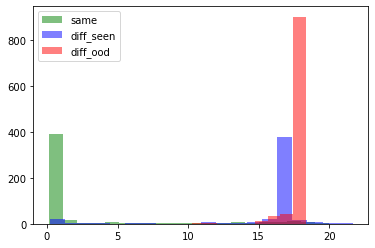

auroc of test pair_is_diff
auroc: 0.958928


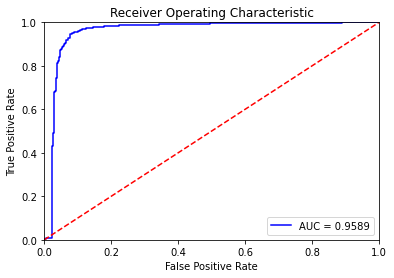

auroc of test pair_is_ood
auroc: 0.9302300000000001


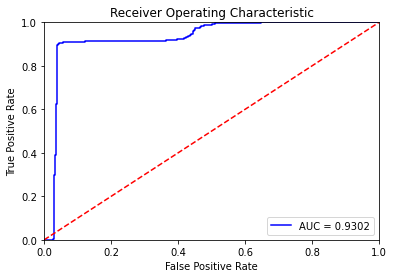

distribution of test ood score


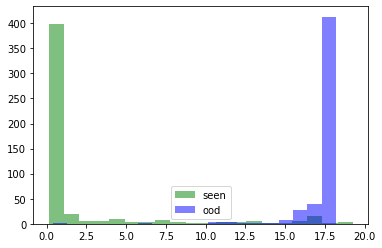

auroc of query image ood score (mean class distance)
auroc: 0.9841519999999999


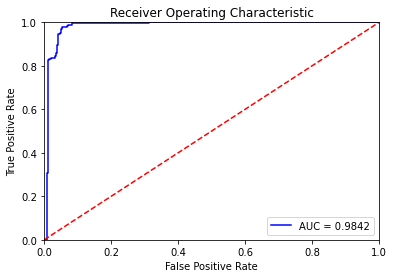

auroc of query image ood score (distance to support class center))
auroc: 0.9841519999999999


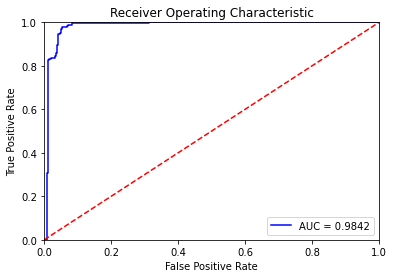

auroc of query image ideal ood score (distance to train class center)
auroc: 0.992


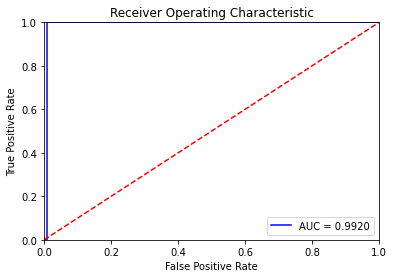

accuracy of qeury image from seen classes: 0.922


In [14]:
test_evaluation(model,train_class_center,k_shot=1,n_way=2,n_query_img=1000,seen_classes=[8,9],ood_classes=[999],
                    ood_dataset = 'gaussian',seed=2021);

test set distance distribution for all test pairs

mean_same = 5.171317100524902, mean_diff_seen = 15.860552787780762, mean_diff_ood = 12.216981887817383


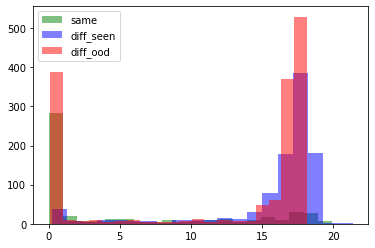

auroc of test pair_is_diff
auroc: 0.7673496


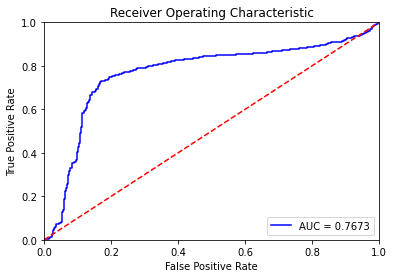

auroc of test pair_is_ood
auroc: 0.4674095555555556


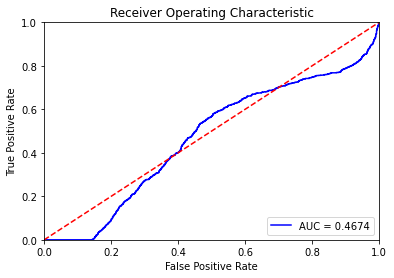

distribution of test ood score


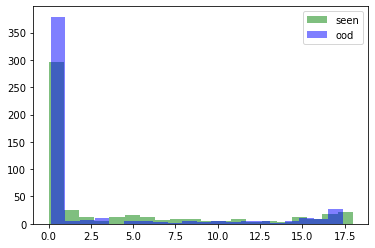

auroc of query image ood score (mean class distance)
auroc: 0.313384


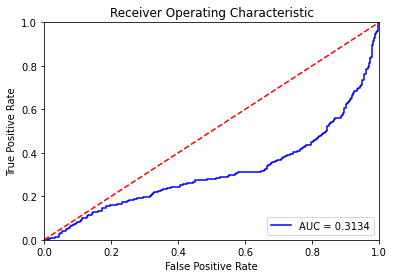

auroc of query image ood score (distance to support class center))
auroc: 0.313384


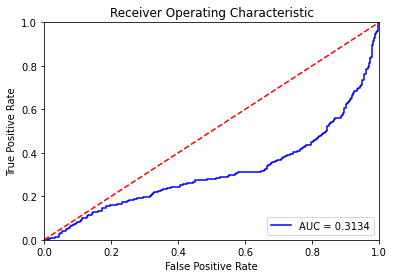

auroc of query image ideal ood score (distance to train class center)
auroc: 0.379124


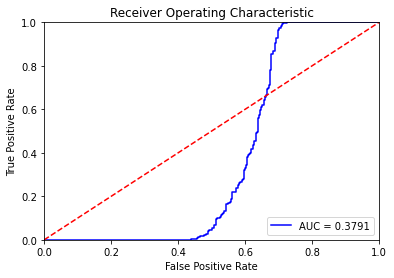

accuracy of qeury image from seen classes: 0.8


({'pair_is_ood': [0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
 

In [11]:
test_evaluation(model,train_class_center,k_shot=1,n_way=3,n_query_img=1000,seen_classes=[4,5,6],ood_classes=[999],
                    ood_dataset = 'gaussian',seed=2021);

test set distance distribution for all test pairs

mean_same = 4.389712333679199, mean_diff_seen = 17.09765625, mean_diff_ood = 14.750268936157227


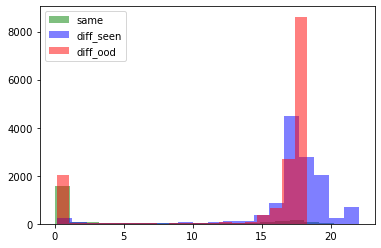

auroc of test pair_is_diff
auroc: 0.8720920145454546


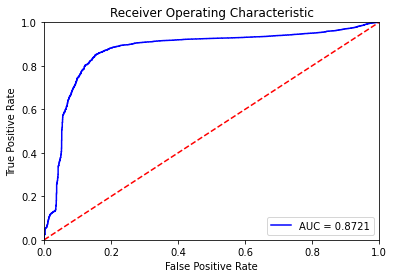

auroc of test pair_is_ood
auroc: 0.45230828


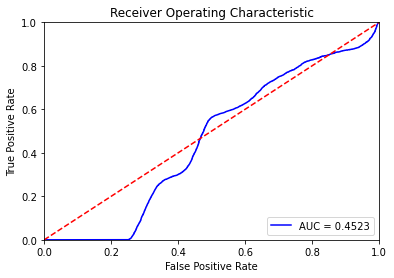

distribution of test ood score


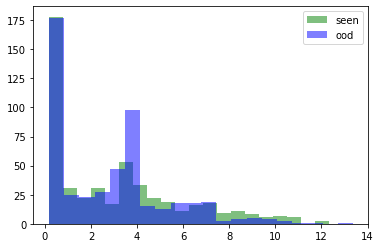

auroc of query image ood score (mean class distance)
auroc: 0.46594


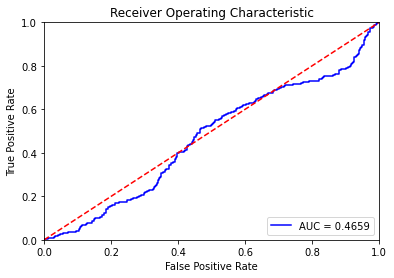

auroc of query image ood score (distance to support class center))
auroc: 0.477588


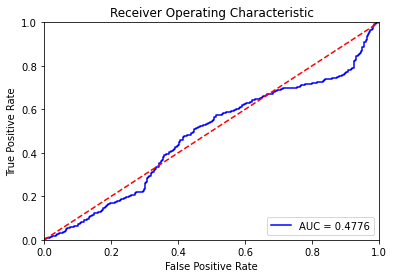

auroc of query image ideal ood score (distance to train class center)
auroc: 0.5266959999999999


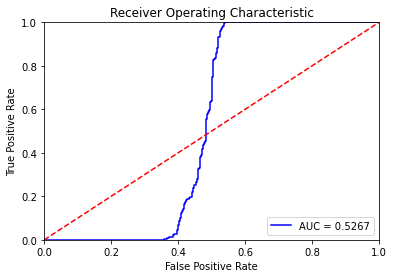

accuracy of qeury image from seen classes: 0.866


In [13]:
test_evaluation(model,train_class_center,k_shot=5,n_way=6,n_query_img=1000,seen_classes=[4,5,6,7,8,9],ood_classes=[999],
                    ood_dataset = 'gaussian',seed=2021);

test set distance distribution for all test pairs

mean_same = 5.171317100524902, mean_diff_seen = 15.860552787780762, mean_diff_ood = 16.338369369506836


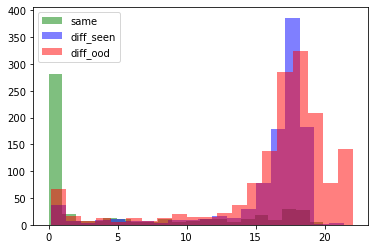

auroc of test pair_is_diff
auroc: 0.881308


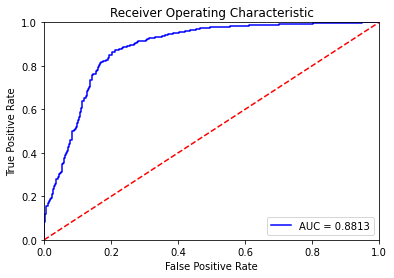

auroc of test pair_is_ood
auroc: 0.6796846666666666


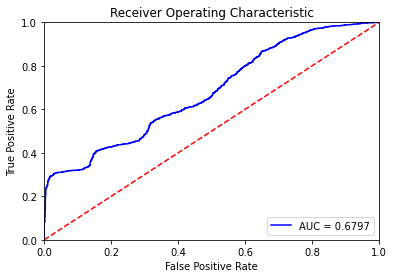

distribution of test ood score


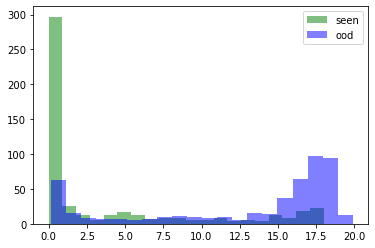

auroc of query image ood score (mean class distance)
auroc: 0.849148


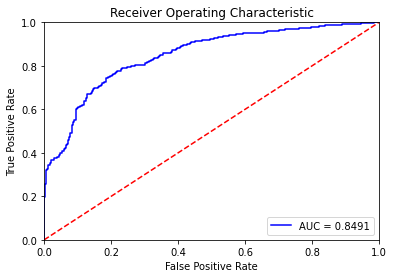

auroc of query image ood score (distance to support class center))
auroc: 0.849148


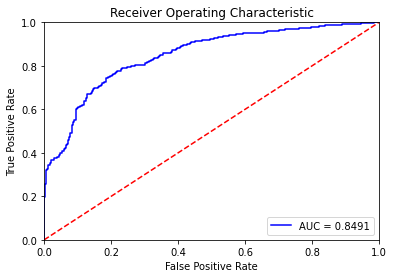

auroc of query image ideal ood score (distance to train class center)
auroc: 0.909432


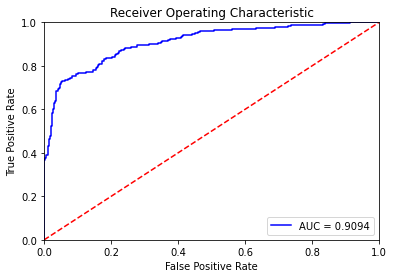

accuracy of qeury image from seen classes: 0.8


In [12]:
test_evaluation(model,train_class_center,k_shot=1,n_way=3,n_query_img=1000,seen_classes=[4,5,6],ood_classes=[999],
                    ood_dataset = 'lsun',seed=2021);

In [7]:
class CIFAR10_TestPair(Dataset):
    def __init__(
            self,
            ood_dataset = 'cifar10_test',   #'cifar10_test', 'tinyimagenet', 'lsun', 'gaussian'
            K = 5,
            N = 6,
            n_query_img = 1000,    
            seen_classes = list(range(6)),
            ood_classes = [8,9],
            seed = 2021
    ):  
        self.K = K
        self.N = N
        self.batch_size = K*N
        self.n_query_img = n_query_img
        self.seen_classes = seen_classes
        self.ood_classes = ood_classes
        self.seed = seed
        self.seen_dataset = cifar10_dataset_test
        self.seen_class_dict = {k:[] for k in seen_classes}    
        for class_id in seen_classes:
            self.seen_class_dict[class_id] = [idx for idx, item in enumerate(self.seen_dataset) if item[1] == class_id] 
        
        #ood dataset
        self.ood_dataset = ood_dataset
        if self.ood_dataset != 'gaussian':
            if self.ood_dataset == 'cifar10_test':
                self.ood_dataset = cifar10_dataset_test
                self.ood_class_dict = {k:[] for k in ood_classes}  
                for class_id in ood_classes:
                    self.ood_class_dict[class_id] = [idx for idx, item in enumerate(self.ood_dataset) if item[1] == class_id]
            if self.ood_dataset == 'tinyimagenet':
                self.ood_dataset = tinyimagenet_dataset
                self.ood_classes = [999]
                self.ood_class_dict = {999:list(range(len(tinyimagenet_dataset)))}  
            if self.ood_dataset == 'lsun':
                self.ood_dataset = lsun_dataset
                self.ood_classes = [999]
                self.ood_class_dict = {999:list(range(len(lsun_dataset)))}


    def __len__(self) -> int:
        return self.n_query_img * self.batch_size
    
    def __getitem__(self, index: int):
        query_image = None
        support_image = None
        query_class = None
        support_class = None
        if_diff = None  # if from same class
        if_ood = None   # if the query image is from ood classes
        
        batch_id = index // self.batch_size
        pair_id = index % self.batch_size   #0,...,29
        way_id = pair_id // self.K          #0,...,5
        shot_id = pair_id % self.K          #0,...,4
        
        #query image
        if batch_id % 2 == 1:   
            # query image from ood classes
            if_ood = 1
            if self.ood_dataset != 'gaussian':
                random.seed(self.seed + batch_id)   # to ensure the same query image is selected within a batch
                query_class = random.choice(self.ood_classes)
                q_img_id = random.choice(self.ood_class_dict[query_class])
                query_image = self.ood_dataset[q_img_id][0]
            # gassian ood    
            else:
                query_class = 999
                torch.manual_seed(self.seed + batch_id)
                query_image = torch.randn(3,32,32) + 0.5
                query_image = torch.clamp(query_image, 0, 1)
                query_image[0][0] = (query_image[0][0] - 0.4914) / 0.2471
                query_image[0][1] = (query_image[0][1] - 0.4822) / 0.2435
                query_image[0][2] = (query_image[0][2] - 0.4465) / 0.2616

        else:
            # query image from seen classes
            if_ood = 0
            random.seed(self.seed + batch_id)   # to ensure the same query image is selected within a batch
            query_class = random.choice(self.seen_classes)
            q_img_id = random.choice(self.seen_class_dict[query_class])
            query_image = self.seen_dataset[q_img_id][0]
        
          
        #support image:
        support_class = self.seen_classes[way_id]
        random.seed(self.seed + index)
        s_img_id = random.choice(self.seen_class_dict[support_class])
        support_image = self.seen_dataset[s_img_id][0]
                
        if_diff = int(query_class!=support_class)
        
        
        query_class = torch.from_numpy(np.array([query_class], dtype=np.int))
        support_class = torch.from_numpy(np.array([support_class], dtype=np.int))
        if_diff = torch.from_numpy(np.array([if_diff], dtype=np.int))
        if_ood = torch.from_numpy(np.array([if_ood], dtype=np.int))

        return query_image, support_image, query_class, support_class, if_diff, if_ood

In [27]:
def calc_train_class_center(cifar10_dataset_train, model, n_class = 10, emb_len = 512):
    model.eval()
    train_class_center = torch.zeros([n_class,emb_len])
    count = np.zeros([n_class])
    
    # get sum of embedding and img count of each class
    for idx, item in enumerate(cifar10_dataset_train):
        img, label = item
        emb, _, _ = model(img.unsqueeze(0).cuda(), img.unsqueeze(0).cuda())
        train_class_center[label] += emb.squeeze(0).cpu().detach()
        count[item[1]] += 1
    
    # get the average embedding (center) of each class
    for i in range(n_class):
        train_class_center[i] /= count[i]
        
    return train_class_center

In [49]:
train_class_center = calc_train_class_center(cifar10_dataset_train = cifar10_dataset_train, model = model)

In [22]:
torch.save(train_class_center, './stat_dict/train_class_center_20210705.pt')

In [9]:
def test_evaluation(model,train_class_center,k_shot=5,n_way=6,n_query_img=1000,seen_classes=list(range(6)),ood_classes=[8,9],
                    ood_dataset = 'cifar10_test', seed=2021):
    # data loading
    testset = CIFAR10_TestPair(ood_dataset,k_shot,n_way,n_query_img,seen_classes,ood_classes,seed)
    test_dataloader = DataLoader(
            testset,
            shuffle = False, # shuffle = false to ensure the N-way K-shot order
            batch_size= k_shot * n_way,
            num_workers=0,
            drop_last=True,
            pin_memory=True,
        )
    
    # distance calculation
    model.eval()
    pair_is_ood = []
    pair_is_diff = []
    pair_dist = []

    q_class = []
    q_is_ood = []
    q_pred_class = []
    q_ood_score = []
    q_ood_score_sc = []
    q_ideal_ood_score = []

    for i, test_batch in enumerate(test_dataloader,0):
        test_query_image, test_support_image, test_query_class, test_support_class, test_is_diff, test_is_ood = test_batch
        q_emb,s_emb,test_dist = model(test_query_image.cuda(), test_support_image.cuda())
        mean_class_dist = np.mean(test_dist.cpu().detach().numpy().squeeze().reshape([n_way,k_shot]),axis=1)
        
        # pair statistics
        pair_is_ood += list(test_is_ood.cpu().detach().numpy().squeeze())
        pair_is_diff += list(test_is_diff.cpu().detach().numpy().squeeze())
        pair_dist += list(test_dist.cpu().detach().numpy().squeeze())
        pair_stat = {"pair_is_ood": pair_is_ood, "pair_is_diff": pair_is_diff, "pair_dist": pair_dist}
        
        # query image statistics
        q_class.append(test_query_class[0].cpu().detach().numpy()[0])
        q_is_ood.append(test_is_ood[0].cpu().detach().numpy()[0])
        q_pred_class.append(seen_classes[mean_class_dist.argmin()])
        q_ood_score.append(mean_class_dist.min())    # use min of mean pair-wise distance of each class
        support_class_center = torch.stack([s_emb[(i*k_shot):(i*k_shot+k_shot)].mean(axis = 0) for i in range(n_way)]).cpu().detach()
        q_ood_score_sc.append(min(F.pairwise_distance(q_emb[:n_way].cpu().detach(), support_class_center)).item())   # use min distance to support class center
        q_ideal_ood_score.append(
            min(F.pairwise_distance(q_emb[:len(seen_classes)].cpu().detach(), train_class_center[seen_classes])).item())
        query_img_stat = {"q_class":q_class, "q_is_ood":q_is_ood, "q_pred_class": q_pred_class, 
                          "q_ood_score":q_ood_score, "q_ood_score_sc":q_ood_score_sc, "q_ideal_ood_score":q_ideal_ood_score}
    
    # evaluation metrics
    test_metrics = {}
    
    print("test set distance distribution for all test pairs")
    test_same_dist = [pair_dist[i] for i in range(len(pair_dist)) if pair_is_diff[i] == 0]
    test_diff_seen_dist = [pair_dist[i] for i in range(len(pair_dist)) if (pair_is_diff[i] == 1 and pair_is_ood[i] ==0)]
    test_diff_ood_dist = [pair_dist[i] for i in range(len(pair_dist)) if (pair_is_diff[i] == 1 and pair_is_ood[i] ==1)]
    test_metrics['mean_same_dist'] = np.mean(test_same_dist)
    test_metrics['mean_diff_seen_dist'] = np.mean(test_diff_seen_dist)
    test_metrics['mean_diff_ood_dist'] = np.mean(test_diff_ood_dist)
    print("\nmean_same = {}, mean_diff_seen = {}, mean_diff_ood = {}"
                      .format(np.mean(test_same_dist),np.mean(test_diff_seen_dist),np.mean(test_diff_ood_dist)))
    plt.hist(test_same_dist, alpha = 0.5, bins = 20, color='g', label='same')
    plt.hist(test_diff_seen_dist, alpha = 0.5, bins = 20, color='b', label='diff_seen')
    plt.hist(test_diff_ood_dist, alpha = 0.5, bins = 20, color='r', label='diff_ood')
    plt.legend()
    plt.show()
    
    print("auroc of test pair_is_diff")
    test_metrics["auroc_pair_is_diff"] = show_auroc(pair_is_diff, pair_dist)
               
    print("auroc of test pair_is_ood")
    test_metrics["auroc_pair_is_ood"] = show_auroc(pair_is_ood, pair_dist)
               
    print("distribution of test ood score")
    test_seen_score = q_ood_score[0::2]
    test_ood_score = q_ood_score[1::2]

    plt.hist(test_seen_score, alpha = 0.5, bins = 20, color='g', label='seen')
    plt.hist(test_ood_score, alpha = 0.5, bins = 20, color='b', label='ood')
    plt.legend()
    plt.show()
               
    print("auroc of query image ood score (mean class distance)")
    test_metrics["auroc_query_is_ood"] = show_auroc(q_is_ood,q_ood_score)
    
    print("auroc of query image ood score (distance to support class center))")
    test_metrics["auroc_query_is_ood_sc"] = show_auroc(q_is_ood,q_ood_score_sc)
    
    print("auroc of query image ideal ood score (distance to train class center)")
    test_metrics["auroc_query_is_ood_ideal"] = show_auroc(q_is_ood,q_ideal_ood_score)
               
    print("accuracy of qeury image from seen classes:", metrics.accuracy_score(q_class[0::2], q_pred_class[0::2]))
    test_metrics["accuracy_query_seen"] = metrics.accuracy_score(q_class[0::2], q_pred_class[0::2])
    
    return  pair_stat, query_img_stat, test_metrics

test set distance distribution for all test pairs

mean_same = 6.525046348571777, mean_diff_seen = 15.728719711303711, mean_diff_ood = 14.070892333984375


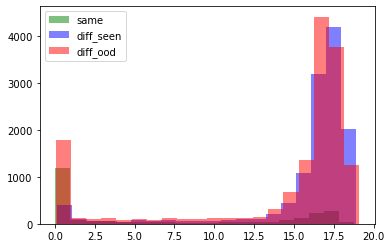

auroc of test pair_is_diff
auroc: 0.8201262327272727


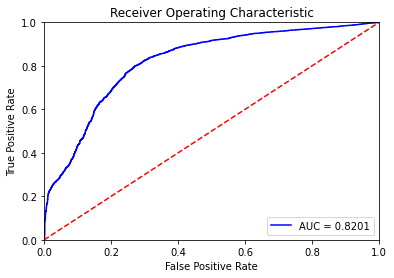

auroc of test pair_is_ood
auroc: 0.5016307111111111


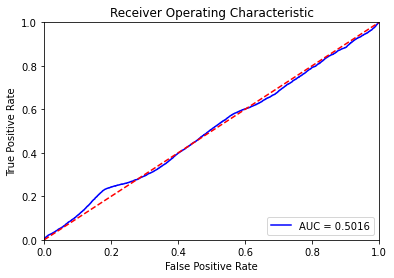

distribution of test ood score


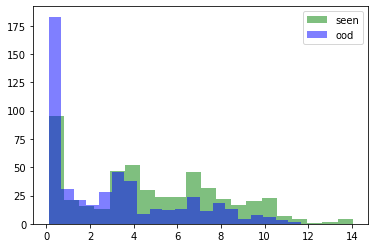

auroc of query image ood score (mean class distance)
auroc: 0.343192


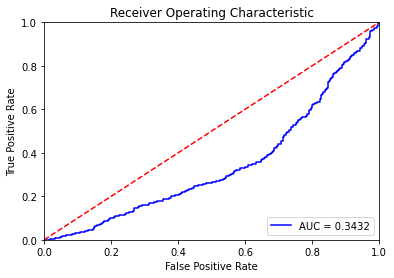

auroc of query image ood score (distance to support class center))
auroc: 0.34539200000000003


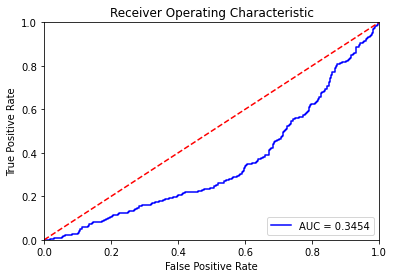

auroc of query image ideal ood score (distance to train class center)
auroc: 0.387124


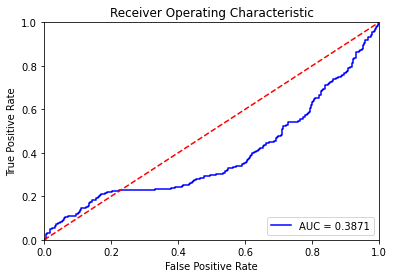

accuracy of qeury image from seen classes: 0.776


({'pair_is_ood': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
 

In [30]:
test_evaluation(k_shot=5,n_way=6,n_query_img=1000,seen_classes=list(range(6)),ood_classes=[8,9],
                    ood_dataset = 'cifar10_test', train_class_center = train_class_center, seed=2021)

test set distance distribution for all test pairs

mean_same = 6.525046348571777, mean_diff_seen = 15.728719711303711, mean_diff_ood = 13.873774528503418


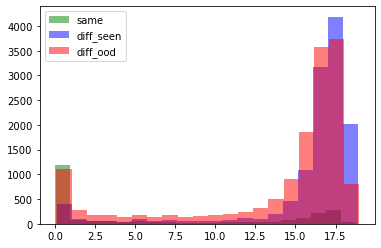

auroc of test pair_is_diff
auroc: 0.8164511054545456


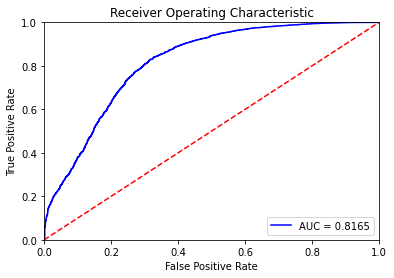

auroc of test pair_is_ood
auroc: 0.4348692755555556


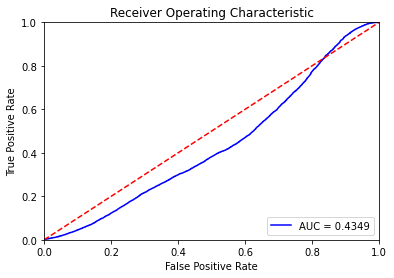

distribution of test ood score


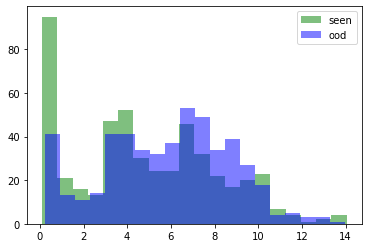

auroc of query image ood score (mean class distance)
auroc: 0.6014


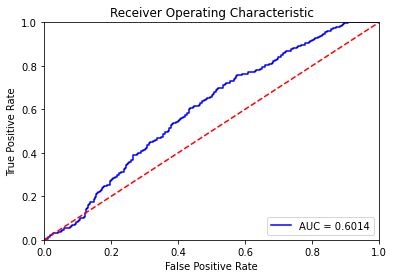

auroc of query image ood score (distance to support class center))
auroc: 0.5697639999999999


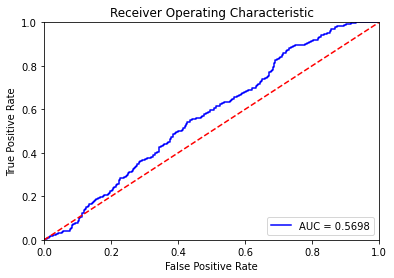

auroc of query image ideal ood score (distance to train class center)
auroc: 0.678704


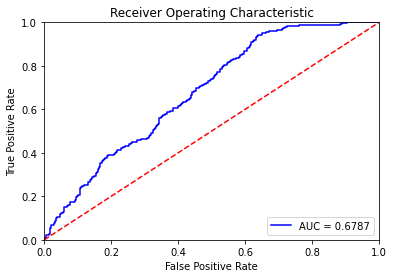

accuracy of qeury image from seen classes: 0.776


({'pair_is_ood': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
 

In [31]:
test_evaluation(k_shot=5,n_way=6,n_query_img=1000,seen_classes=list(range(6)),ood_classes=[6,7],
                    ood_dataset = 'cifar10_test', train_class_center = train_class_center, seed=2021)

test set distance distribution for all test pairs

mean_same = 6.60450553894043, mean_diff_seen = 15.547590255737305, mean_diff_ood = 13.89299488067627


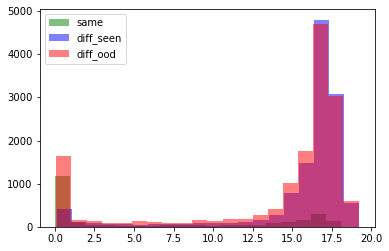

auroc of test pair_is_diff
auroc: 0.8187702036363638


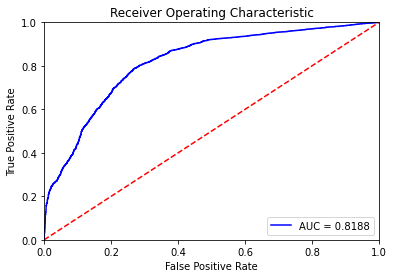

auroc of test pair_is_ood
auroc: 0.4789058977777778


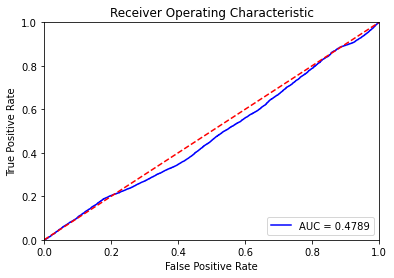

distribution of test ood score


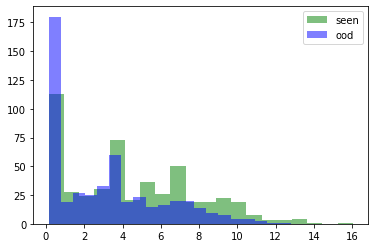

auroc of query image ood score (mean class distance)
auroc: 0.38221200000000005


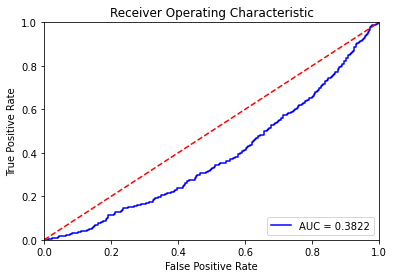

auroc of query image ood score (distance to support class center))
auroc: 0.385724


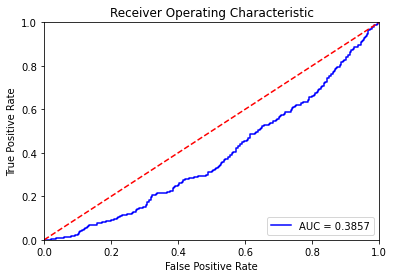

auroc of query image ideal ood score (distance to train class center)
auroc: 0.39138399999999995


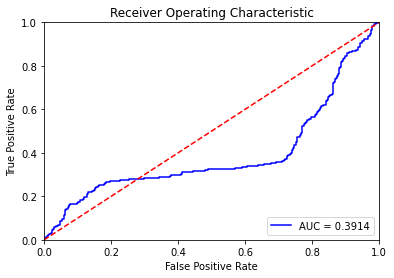

accuracy of qeury image from seen classes: 0.738


In [50]:
test_evaluation(k_shot=5,n_way=6,n_query_img=1000,seen_classes=list(range(6)),ood_classes=[8,9],
                    ood_dataset = 'cifar10_test', train_class_center = train_class_center, seed=2021);

test set distance distribution for all test pairs

mean_same = 6.60450553894043, mean_diff_seen = 15.547590255737305, mean_diff_ood = 13.654158592224121


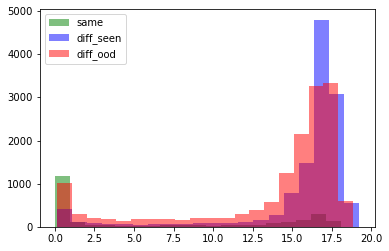

auroc of test pair_is_diff
auroc: 0.8146377963636364


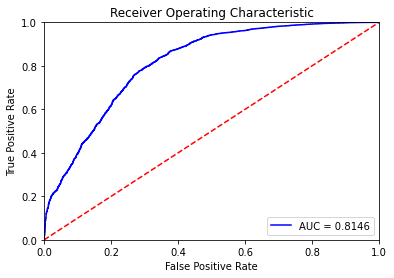

auroc of test pair_is_ood
auroc: 0.4200942


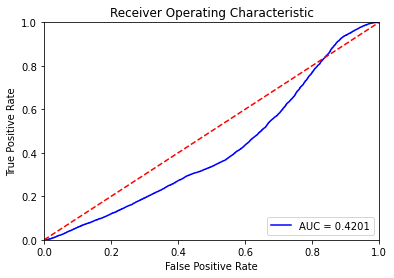

distribution of test ood score


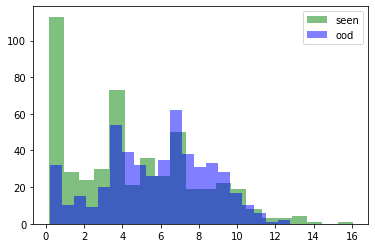

auroc of query image ood score (mean class distance)
auroc: 0.6344679999999999


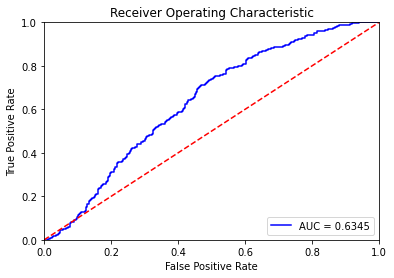

auroc of query image ood score (distance to support class center))
auroc: 0.590324


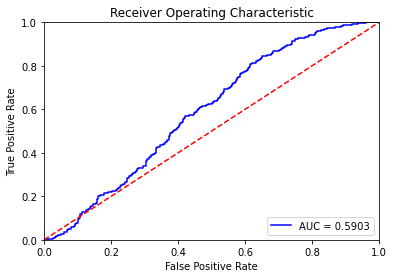

auroc of query image ideal ood score (distance to train class center)
auroc: 0.7009799999999999


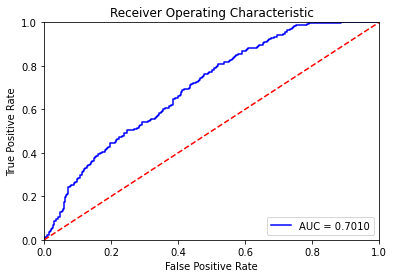

accuracy of qeury image from seen classes: 0.738


In [51]:
test_evaluation(k_shot=5,n_way=6,n_query_img=1000,seen_classes=list(range(6)),ood_classes=[6,7],
                    ood_dataset = 'cifar10_test', train_class_center = train_class_center, seed=2021);

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


test set distance distribution for all test pairs

mean_same = 6.727859973907471, mean_diff_seen = 15.818307876586914, mean_diff_ood = 13.967147827148438


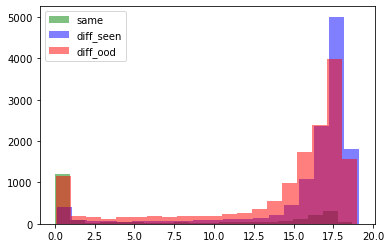

auroc of test pair_is_diff
auroc: 0.8195975636363637


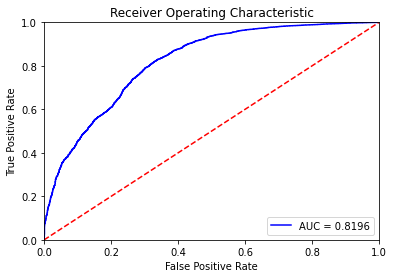

auroc of test pair_is_ood
auroc: 0.4368832088888889


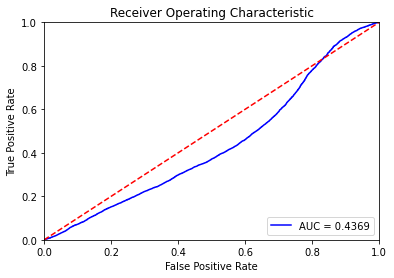

distribution of test ood score


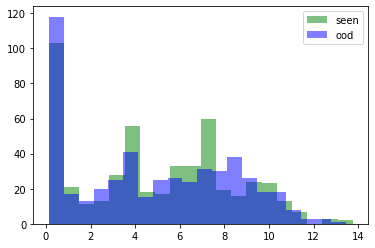

auroc of query image ood score (mean class distance)
auroc: 0.501984


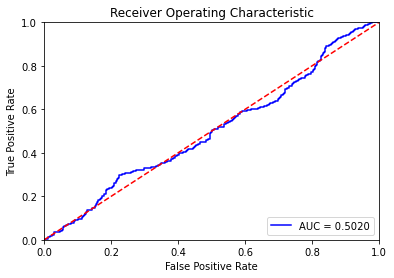

auroc of query image ood score (distance to support class center))
auroc: 0.478256


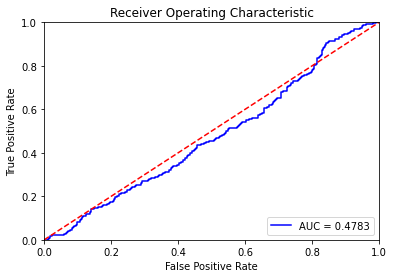

auroc of query image ideal ood score (distance to train class center)
auroc: 0.6330520000000001


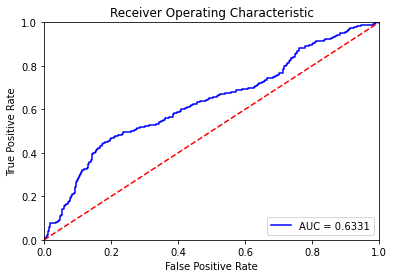

accuracy of qeury image from seen classes: 0.764


mean_same_dist,6.72786
mean_diff_seen_dist,15.81831
mean_diff_ood_dist,13.96715
auroc_pair_is_diff,0.8196
auroc_pair_is_ood,0.43688
auroc_query_is_ood,0.50198
auroc_query_is_ood_sc,0.47826
auroc_query_is_ood_ideal,0.63305
accuracy_query_seen,0.764
_runtime,56
_timestamp,1625840338


mean_same_dist,▁
mean_diff_seen_dist,▁
mean_diff_ood_dist,▁
auroc_pair_is_diff,▁
auroc_pair_is_ood,▁
auroc_query_is_ood,▁
auroc_query_is_ood_sc,▁
auroc_query_is_ood_ideal,▁
accuracy_query_seen,▁
_runtime,▁
_timestamp,▁


In [27]:
wandb.init(name= 'test',   #'5-shot 6-way tinyimagenet - without OE', 
           project= 'test',  #'Siamese_without_OE - Testing Evaluation',
           tags = ['5-shot', '6-way', 'tinyimagenet', 'without OE'],
           config={"k_shot": 5,                                      #5,20,100
                   "n_way": 6,                                       #1,2,3,4,5,6
                   "n_query_image": 1000,
                   "seen_classes": [0,1,2,3,4,5],                              # [0,1,2,3,4,5]
                   "ood_classes": [999],                             #[999] if not cifar10_test, [8,9] if cifarr10_test
                   "ood_dataset": "tinyimagenet",                        #'cifar10_test', 'tinyimagenet', 'lsun', 'gaussian'
                   "seed": 2021
                  })

pair_stat, query_img_stat, test_metrics = test_evaluation(
    wandb.config.k_shot,
    wandb.config.n_way,
    wandb.config.n_query_image,
    wandb.config.seen_classes,
    wandb.config.ood_classes,
    wandb.config.ood_dataset,
    train_class_center,
    wandb.config.seed)


wandb.log({
        "mean_same_dist": test_metrics['mean_same_dist'],
        "mean_diff_seen_dist": test_metrics['mean_diff_seen_dist'],
        "mean_diff_ood_dist": test_metrics['mean_diff_ood_dist'],
        "auroc_pair_is_diff": test_metrics['auroc_pair_is_diff'],
        "auroc_pair_is_ood": test_metrics['auroc_pair_is_ood'],
        "auroc_query_is_ood": test_metrics['auroc_query_is_ood'],
        "auroc_query_is_ood_sc": test_metrics['auroc_query_is_ood_sc'],
        "auroc_query_is_ood_ideal": test_metrics['auroc_query_is_ood_ideal'],
        "accuracy_query_seen": test_metrics['accuracy_query_seen']
        })

wandb.finish()